# Route Optimization with Chicago Dataset

### Import libraries

In [ ]:
!pip install dask

In [ ]:
!pip install scikit-plot

In [ ]:
!pip install statsmodels

In [ ]:
!pip install prophet

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns  
import folium  
from folium import plugins
from folium import Choropleth, Circle, Marker
import plotly.express as px
import json
import osmnx as ox  
import networkx as nx 
import geopandas as gpd
import re
import random
from sklearn.cluster import KMeans 
from scikitplot.cluster import plot_elbow_curve
import dask.dataframe as dd
from statsmodels.tsa.seasonal import seasonal_decompose
import gc
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, make_scorer
from skopt import BayesSearchCV
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import TimeSeriesSplit
import joblib

# Table of Contents
- [Chapter 1 Match Real Trip Routes with Calculated Shortest Routes from OSMnx](#Chapter-1-Match-Real-Trip-Routes-with-Calculated-Shortest-Routes-from-OSMnx)
  - [1.1 Data preparation and OSMnx graph creation](#1.1-Data-preparation-and-OSMnx-graph-creation)
  - [1.2 Match the end points of each trip with the nodes from the OSMnx graph and calculate the shortest route with the obtained nodes](#1.2-Match-the-end-points-of-each-trip-with-the-nodes-from-the-OSMnx-graph-and-calculate-the-shortest-route-with-the-obtained-nodes)
  - [1.3 Filter trips based on the match result](#1.3-Filter-trips-based-on-the-match-result)
    - [1.3.1 Filter trips by the point-to-nearest-node distance](#1.3.1-Filter-trips-by-the-point-to-nearest-node-distance)
    - [1.3.2 Filter trips by the absolute difference between the real trip miles and the calculated shortest route length](#1.3.2-Filter-trips-by-the-absolute-difference-between-the-real-trip-miles-and-the-calculated-shortest-route-length)
      - [1.3.2.1 compare the trip features before and after filter with different thresholds](#1.3.2.1-compare-the-trip-features-before-and-after-filter-with-different-thresholds)
      - [1.3.2.2 compare the temporal traffic pattern before and after filter with the 500m threshold](#1.3.2.2-compare-the-temporal-traffic-pattern-before-and-after-filter-with-the-500m-threshold)    
- [Chapter 2 Create Segment Level Dataset](#Chapter-2-Create-Segment-Level-Dataset)
  - [2.1 Cluster all road segments of Chicago into regions](#2.1-Cluster-all-road-segments-of-Chicago-into-regions)
  - [2.2 Extract the road segments details from G](#2.2-Extract-the-road-segments-details-from-G)
  - [2.3 Display the road segments in our dataset on OSMnx graph and check their coverage ratio in each region](#2.3-Display-the-road-segments-in-our-dataset-on-OSMnx-graph-and-check-their-coverage-ratio-in-each-region)
  - [2.4 Complete the segment level traffic information](#2.4-Complete-the-segment-level-traffic-information)
  
- [Chapter 3 Check the Temporal Traffic Pattern Completeness for Each Region](#Chapter-3-Check-the-Temporal-Traffic-Pattern-Completeness-for-Each-Region)
- [Chapter 4 Road Segments Clustering within Each Region](#Chapter-4-Road-Segments-Clustering-within-Each-Region)
  - [4.1 Data preparation for KMeans clustering](#4.1-Data-preparation-for-KMeans-clustering)
  - [4.2 Use elbow method to determine K for each region](#4.2-Use-elbow-method-to-determine-K-for-each-region)
  - [4.3 Save the obtained cluster information for each region to the segment level dataframe](#4.3-Save-the-obtained-cluster-information-for-each-region-to-the-segment-level-dataframe)
  - [4.4 Display the above plotted results onto map](#4.4-Display-the-above-plotted-results-onto-map)
    - [4.4.1 Region data preparation](#4.4.1-Region-data-preparation)
    - [4.4.2 Plot road segments on map, colored by congestion level](#4.4.2-Plot-road-segments-on-map,-colored-by-congestion-level)
- [Chapter 5  Build ML models for predicting the  travel time for each road segment cluster](#Chapter-5--Build-ML-models-for-predicting-the--travel-time-for-each-road-segment-cluster)
  - [5.1 Check the clustering accuracy by plotting the inferred travel time histogram for each cluster](#5.1-Check-the-clustering-accuracy-by-plotting-the-inferred-travel-time-histogram-for-each-cluster)
  - [5.2 EDA for feature engineering](#5.2-EDA-for-feature-engineering)
    - [5.2.1 fill up missing hours](#5.2.1-fill-up-missing-hours)
    - [5.2.2 Generate lag and rolling features](#5.2.2-Generate-lag-and-rolling-features)
    - [5.2.3 EDA on individual features and correlation between features](#5.2.3-EDA-on-individual-features-and-correlation-between-features)
      - [5.2.3.1 Exploring single numerical features](#5.2.3.1-Exploring-single-numerical-features)
      - [5.2.3.2 Exploring the correlation between features](#5.2.3.2-Exploring-the-correlation-between-features)
      - [5.2.3.3 Use Xgboost as the base model to do feature engneering](#5.2.3.3-Use-Xgboost-as-the-base-model-to-do-feature-engneering)
   - [5.3 Machine Learning Modeling](#5.3-Machine-Learning-Modeling)
     - [5.3.1 Xgboost model with Bayesian optimization (BayesSearchCV)](#5.3.1-Xgboost-model-with-Bayesian-optimization-(BayesSearchCV))
     - [5.3.2 Prophet model](#5.3.2-Prophet-model)
   - [5.4 Use the prediction results to do route optimization and compare the results with that based on the inferred travel time](#5.4-Use-the-prediction-results-to-do-route-optimization-and-compare-the-results-with-that-based-on-the-inferred-travel-time)
     - [5.4.1 Merge the prediction results for each cluster to the original regional dataset](#5.4.1-Merge-the-prediction-results-for-each-cluster-to-the-original-regional-dataset)
     - [5.4.2 Compare the route optimization results by using the predition results on cluster level and the inferred travel time on segment level](#5.4.2-Compare-the-route-optimization-results-by-using-the-predition-results-on-cluster-level-and-the-inferred-travel-time-on-segment-level)
       - [5.4.2.1 Analyze the difference between the inferred_travel_time_sec and the predicted travel time for each segment](#5.4.2.1-Analyze-the-difference-between-the-inferred_travel_time_sec-and-the-predicted-travel-time-for-each-segment)
       - [5.4.2.2 Compare the route optimization results by the prediction and the inferred travel time](#5.4.2.2-Compare-the-route-optimization-results-by-the-prediction-and-the-inferred-travel-time)
      

## Chapter 1 Match Real Trip Routes with Calculated Shortest Routes from OSMnx

### 1.1 Data preparation and OSMnx graph creation

In [2]:
# import the original chicago dataset
df = pd.read_csv('chicago_data_5.2_perc_sample.csv')

In [3]:
df.head()

Unnamed: 0     trip_start_timestamp       trip_end_timestamp  trip_seconds  \
0      453863  2023-05-14T09:00:00.000  2023-05-14T09:00:00.000         314.0   
1      681723  2023-05-06T22:15:00.000  2023-05-06T22:15:00.000         615.0   
2      548264  2023-05-09T10:15:00.000  2023-05-09T10:45:00.000        1475.0   
3      199697  2023-05-12T17:30:00.000  2023-05-12T18:00:00.000        1413.0   
4      165024  2023-05-08T20:30:00.000  2023-05-08T20:45:00.000         335.0   

   trip_miles  percent_time_chicago  percent_distance_chicago  \
0        1.37                0.9937                    0.9920   
1        2.43                0.9985                    1.0000   
2       13.36                0.9985                    0.9956   
3        6.52                0.9995                    0.9880   
4        1.33                1.0000                    1.0000   

   pickup_census_tract  dropoff_census_tract  pickup_community_area  ...  \
0         1.703183e+10          1.703106e+10                    7.0  ...   
1         1.703132e+10          1.703183e+10                   32.0  ...   
2         1.703105e+10          1.703198e+10                    5.0  ...   
3         1.703106e+10          1.703108e+10                    6.0  ...   
4         1.703184e+10          1.703141e+10                   41.0  ...   

   trips_pooled              pickup_centroid_location  \
0             1  POINT (-87.6640782395 41.9218774613)   
1             1  POINT (-87.6219716519 41.8774061234)   
2             1  POINT (-87.6835062305 41.9504425991)   
3             1  POINT (-87.6665362813 41.9506733576)   
4             1  POINT (-87.6012851221 41.7904693995)   

              dropoff_centroid_location  temp  dwpt  rhum  prcp   wdir wpgt  \
0  POINT (-87.6467297286 41.9346591566)  14.4   7.9  65.0   0.0   20.0  NaN   
1  POINT (-87.6540926517 41.8716894745)  25.0  12.9  47.0   0.0  150.0  NaN   
2  POINT (-87.9030396611 41.9790708201)   8.9   7.2  89.0   0.0  340.0  NaN   
3  POINT (-87.6318639497 41.8920421365)  25.0  16.7  60.0   0.0  140.0  NaN   
4  POINT (-87.5853031602 41.8012268363)  12.8  11.0  89.0   2.1   30.0  NaN   

     pres  
0  1024.0  
1  1012.5  
2  1018.0  
3  1016.0  
4  1014.0  

[5 rows x 27 columns]

In [4]:
# create an OSMnx graph for Chicago city
place = 'Chicago, Illinois, USA'
G = ox.graph_from_place(place, network_type='drive')

#add speed limit and free flow travel_time attributes to the edges.
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
# create geo-dataframe for both nodes and edges 
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

### 1.2 Match the end points of each trip with the nodes from the OSMnx graph and calculate the shortest route with the obtained nodes

In [5]:
# drop na values in pickup_centroid_location or dropoff_centroid_location
data=df.dropna(subset=['pickup_centroid_location', 'dropoff_centroid_location'])
# create a dataframe data_group to only include the unique ('pickup_centroid_location', 'dropoff_centroid_location') 
data_group=data.drop_duplicates(['pickup_centroid_location', 'dropoff_centroid_location'])

In [ ]:
#convert the end points of each trip into nodes of the graph by finding the nearest node corresponding to each endpoint:
pattern=r'-?\d+\.\d+'
data_group['start_node']=data_group.apply(lambda row: 
                                                        ox.distance.nearest_nodes(
                                                            G, 
                                                            float(re.findall(pattern, row['pickup_centroid_location'])[0]),
                                                            float(re.findall(pattern, row['pickup_centroid_location'])[1])),
                                                            axis=1)
data_group['end_node']=data_group.apply(lambda row: 
                                                        ox.distance.nearest_nodes(
                                                            G, 
                                                            float(re.findall(pattern, row['dropoff_centroid_location'])[0]),
                                                            float(re.findall(pattern, row['dropoff_centroid_location'])[1])),
                                                            axis=1)

In [ ]:
# Calculate the distance between the point and its nearest node

##great_circle_vec is used to calculate the distance by considering the earth is spherical , which provides more accuracy
data_group['start_node_distance'] = data_group.apply(lambda row: 
                                                                       ox.distance.great_circle_vec(
                                                                       float(re.findall(pattern, row['pickup_centroid_location'])[1]),
                                                                       float(re.findall(pattern, row['pickup_centroid_location'])[0]),
                                                                       G.nodes[row['start_node']]['y'], G.nodes[row['start_node']]['x']),
                                                                   axis=1)
data_group['end_node_distance'] = data_group.apply(lambda row: 
                                                                       ox.distance.great_circle_vec(
                                                                       float(re.findall(pattern, row['dropoff_centroid_location'])[1]),
                                                                       float(re.findall(pattern, row['dropoff_centroid_location'])[0]),
                                                                       G.nodes[row['end_node']]['y'], G.nodes[row['end_node']]['x']),
                                                                   axis=1)

In [ ]:
# calculate the shortest route by length for each pair of the obtained nodes 
def get_shortest_route(row):
    try:
        shortest_route=nx.shortest_path(G, row['start_node'], row['end_node'], weight='length')
        shortest_route_length=nx.shortest_path_length(G, row['start_node'], row['end_node'], weight='length')   
    except nx.NetworkXNoPath:
        shortest_route=np.nan
        shortest_route_length=np.nan
    return shortest_route, shortest_route_length
data_group[['shortest_route','shortest_route_length']]= data_group.apply(
                                                                                                                                 lambda row:
                                                                                                                                pd.Series(get_shortest_route(row)), axis=1)

In [ ]:
# merge the new generated columns in above with the original data dataframe and rename it as data_merged
data_group_col=data_group[['pickup_centroid_location', 'dropoff_centroid_location', 'start_node','end_node',
                           'start_node_distance', 'end_node_distance','shortest_route', 'shortest_route_length']]
data_merged=pd.merge(data, data_group_col, on=['pickup_centroid_location', 'dropoff_centroid_location'])

In [ ]:
# save this dataframe for an easier access in the future
data_merged.to_csv('Chicago_orig.csv')

In [6]:
data_merged=pd.read_csv('Chicago_orig.csv')

### 1.3 Filter trips based on the match result 

#### 1.3.1 Filter trips by the point-to-nearest-node distance

In [7]:
# obtain the statistics info of the distance between the pickup point and the found nearest node
data_merged['start_node_distance'].describe().drop('count')

mean     188.111752
std      692.229153
min        0.082483
25%       28.306835
50%       50.034889
75%       80.832069
max     4761.977022
Name: start_node_distance, dtype: float64

In [8]:
# obtain the statistics info of the distance between the dropoff point and the found nearest node
data_merged['end_node_distance'].describe().drop('count')

mean     241.221905
std      825.629643
min        0.082483
25%       28.881361
50%       51.235606
75%       81.084333
max     4761.977022
Name: end_node_distance, dtype: float64

Analysis: 
- the distance of ~82m between the closest node and the pickup/dropoff location corresponds to 75 percentile, we can start with  82m as the threshold to filter trips, and then try other thresholds based on the result.

In [9]:
# calculate the retained data ratio by trying different thresholds
data_ratio_thre_82m=len(data_merged[(data_merged['start_node_distance']<82) 
                         & (data_merged['end_node_distance']<82)])/len(data_merged)
data_ratio_thre_100m=len(data_merged[(data_merged['start_node_distance']<100) & 
                (data_merged['end_node_distance']<100)])/len(data_merged)
data_ratio_thre_150m=len(data_merged[(data_merged['start_node_distance']<150) 
                & (data_merged['end_node_distance']<150)])/len(data_merged)
data_ratio_thre_200m=len(data_merged[(data_merged['start_node_distance']<200) 
                & (data_merged['end_node_distance']<200)])/len(data_merged)
data_ratio_thre_500m=len(data_merged[(data_merged['start_node_distance']<500) 
                & (data_merged['end_node_distance']<500)])/len(data_merged)
data_ratio_thre_1000m=len(data_merged[(data_merged['start_node_distance']<1000) 
                                     & (data_merged['end_node_distance']<1000)])/len(data_merged)
print(f'data_ratio_thre_82m: {data_ratio_thre_82m},\
    data_ratio_thre_100m: {data_ratio_thre_100m},\
     data_ratio_thre_150m: {data_ratio_thre_150m},\
     data_ratio_thre_200m: {data_ratio_thre_200m},\
     data_ratio_thre_500m: {data_ratio_thre_500m},\
     data_ratio_thre_1000m: {data_ratio_thre_1000m}')

data_ratio_thre_82m: 0.5839708039184665,    data_ratio_thre_100m: 0.6915845865385026,     data_ratio_thre_150m: 0.8499863170092403,     data_ratio_thre_200m: 0.8806760359520582,     data_ratio_thre_500m: 0.9045777086976786,     data_ratio_thre_1000m: 0.9249728478152112


Analysis:
- from the above result, it is evident that beyond a threshold of 150 meters, the increase in retained data proportion becomes insignificant. This indicates that a threshold of 150 meters effectively captures the majority of the data. Given that 150 meters is a reasonable distance for approximation, we selected it as the threshold for filtering trips

In [10]:
 # create a new dataframe called data_merged_nodes reflecting the filter by nodes as mentioned above. 
data_merged_nodes=data_merged[(data_merged['start_node_distance']<150) &
                                                                     (data_merged['end_node_distance']<150)  &
                                                                     (data_merged['start_node'] != data_merged['end_node'])
                              ]
# drop the invalid routes 
data_merged_nodes.dropna(subset=['shortest_route'], inplace=True)
# add a new column about the absolute difference between the actual trip_miles and the calculated shortest route length
data_merged_nodes['absdiff_trip_shortest_meters']=abs(data_merged_nodes['trip_miles']*1609.344-data_merged_nodes['shortest_route_length'])

C:\Users\cclin\AppData\Local\Temp\ipykernel_16092\1206544624.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_merged_nodes.dropna(subset=['shortest_route'], inplace=True)
C:\Users\cclin\AppData\Local\Temp\ipykernel_16092\1206544624.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_merged_nodes['absdiff_trip_shortest_meters']=abs(data_merged_nodes['trip_miles']*1609.344-data_merged_nodes['shortest_route_length'])


#### 1.3.2 Filter trips by the absolute difference between the real trip miles and the calculated shortest route length

In [11]:
# obtain the statistics info of the absolute difference between the real trip miles and the calcuated shortest route length
data_merged_nodes['absdiff_trip_shortest_meters'].describe().drop('count')

mean      1240.870544
std       1673.576083
min          0.000184
25%        317.109980
50%        738.364384
75%       1607.069950
max     673816.650000
Name: absdiff_trip_shortest_meters, dtype: float64

<Axes: >

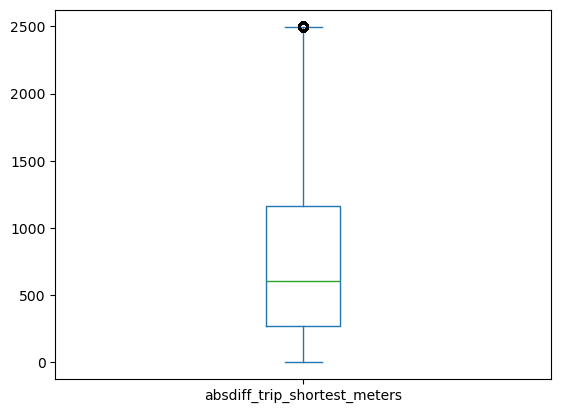

In [12]:
# plot the boxplot by focusing on the difference range within 2500 meters for a better visualization
Y=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<2500]
Y['absdiff_trip_shortest_meters'].plot(kind='box')

Analysis:
- it seems we can consider 1610 as the maximum threshold since it retains 75% data.
- we can also try 1000m and 500m for comparison since both thresholds retain at least ~50% data and are more reasonable than 1610m.

In [13]:
# data_merged_routes_diffXXX was obtained after filtering trips with the threshold of XXXm 
data_merged_routes_diff1610=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<1610]
data_merged_routes_diff500=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<500]
data_merged_routes_diff1000=data_merged_nodes[data_merged_nodes['absdiff_trip_shortest_meters']<1000]

##### 1.3.2.1 compare the trip features before and after filter with different thresholds

In [14]:
#trip related features include trip_miles, trip_seconds, percent_time_chicago, percent_distance_chicago.
#filter_nodes reflects the dataset after node filter
#filter_routes_diffXXX reflects the dataset after the further route filter with XXX m threshold in route length difference
filter_nodes=data_merged_nodes[['trip_miles', 'trip_seconds', 'percent_time_chicago', 
                                'percent_distance_chicago']].describe().drop('count')
filter_routes_diff500=data_merged_routes_diff500[['trip_miles', 'trip_seconds', 'percent_time_chicago',
                            'percent_distance_chicago']].describe().drop('count')
filter_routes_diff1000=data_merged_routes_diff1000[['trip_miles', 'trip_seconds', 'percent_time_chicago',
                            'percent_distance_chicago']].describe().drop('count')
filter_routes_diff1610=data_merged_routes_diff1610[['trip_miles', 'trip_seconds', 'percent_time_chicago',
                            'percent_distance_chicago']].describe().drop('count')
m1=filter_nodes.merge(filter_routes_diff500, left_index=True, right_index=True, suffixes=['_filter_nodes', '_filter_routes_diff500'])
m2=filter_routes_diff1000.merge(filter_routes_diff1610, left_index=True, right_index=True, suffixes=['_filter_routes_diff1000', '_filter_routes_diff1610'])
compare=m1.merge(m2, left_index=True, right_index=True)

In [15]:
#trip_miles comparison
com_trip_miles=compare[['trip_miles_filter_nodes',
                        'trip_miles_filter_routes_diff500',
                        'trip_miles_filter_routes_diff1000',
                        'trip_miles_filter_routes_diff1610'
        ]]
com_trip_miles

trip_miles_filter_nodes  trip_miles_filter_routes_diff500  \
mean                 4.204943                          2.715538   
std                  3.509475                          2.086580   
min                  0.000000                          0.020300   
25%                  1.712000                          1.321000   
50%                  3.120000                          2.121000   
75%                  5.570000                          3.410000   
max                421.000000                         25.030000   

      trip_miles_filter_routes_diff1000  trip_miles_filter_routes_diff1610  
mean                           2.952307                           3.242515  
std                            2.242881                           2.439331  
min                            0.000000                           0.000000  
25%                            1.420000                           1.526000  
50%                            2.310000                           2.550000  
75%                            3.750000                           4.195000  
max                           26.620000                          26.620000

In [16]:
com_trip_seconds=compare[['trip_seconds_filter_nodes', 
                          'trip_seconds_filter_routes_diff500',
                          'trip_seconds_filter_routes_diff1000',
                          'trip_seconds_filter_routes_diff1610'
 ]]
com_trip_seconds

trip_seconds_filter_nodes  trip_seconds_filter_routes_diff500  \
mean                 889.327850                          706.745054   
std                  542.040662                          403.729375   
min                    0.000000                            0.000000   
25%                  507.000000                          423.000000   
50%                  769.000000                          619.000000   
75%                 1132.000000                          891.000000   
max                28270.000000                        20700.000000   

      trip_seconds_filter_routes_diff1000  trip_seconds_filter_routes_diff1610  
mean                           739.893322                           776.880961  
std                            420.261479                           440.584969  
min                              0.000000                             0.000000  
25%                            444.000000                           466.000000  
50%                            649.000000                           684.000000  
75%                            931.000000                           981.000000  
max                          20700.000000                         20700.000000

In [17]:
com_percent_time_chicago=compare[['percent_time_chicago_filter_nodes',
                                  'percent_time_chicago_filter_routes_diff500',
                                  'percent_time_chicago_filter_routes_diff1000',
                                  'percent_time_chicago_filter_routes_diff1610'
     ]]
com_percent_time_chicago

percent_time_chicago_filter_nodes  \
mean                           0.996344   
std                            0.021641   
min                            0.000000   
25%                            0.996600   
50%                            0.998500   
75%                            1.000000   
max                            6.137000   

      percent_time_chicago_filter_routes_diff500  \
mean                                    0.996526   
std                                     0.018065   
min                                     0.000000   
25%                                     0.996600   
50%                                     0.998500   
75%                                     1.000000   
max                                     3.734000   

      percent_time_chicago_filter_routes_diff1000  \
mean                                     0.996531   
std                                      0.019311   
min                                      0.000000   
25%                                      0.996600   
50%                                      0.998500   
75%                                      1.000000   
max                                      6.137000   

      percent_time_chicago_filter_routes_diff1610  
mean                                     0.996506  
std                                      0.019885  
min                                      0.000000  
25%                                      0.996600  
50%                                      0.998500  
75%                                      1.000000  
max                                      6.137000

In [18]:
com_percent_distance_chicago=compare[['percent_distance_chicago_filter_nodes',
                                      'percent_distance_chicago_filter_routes_diff500',
                                      'percent_distance_chicago_filter_routes_diff1000',
                                      'percent_distance_chicago_filter_routes_diff1610'
   ]]
com_percent_distance_chicago

percent_distance_chicago_filter_nodes  \
mean                               0.993805   
std                                0.087211   
min                                0.000000   
25%                                0.995600   
50%                                1.000000   
75%                                1.000000   
max                              143.100000   

      percent_distance_chicago_filter_routes_diff500  \
mean                                        0.995095   
std                                         0.024359   
min                                         0.000000   
25%                                         0.997000   
50%                                         1.000000   
75%                                         1.000000   
max                                         4.676000   

      percent_distance_chicago_filter_routes_diff1000  \
mean                                         0.994880   
std                                          0.025075   
min                                          0.000000   
25%                                          0.996600   
50%                                          1.000000   
75%                                          1.000000   
max                                          4.676000   

      percent_distance_chicago_filter_routes_diff1610  
mean                                         0.994691  
std                                          0.098424  
min                                          0.000000  
25%                                          0.996600  
50%                                          1.000000  
75%                                          1.000000  
max                                        143.100000

Analysis: 
- trip_miles statistical features have been changed obviously after the route filter with different thresholds. However, we can see that the 1610m threshod doesnt have a significant difference from the 500m threshod, which implies the retained trips by using the 500m threshold already kept most of the segment types. Thus, we can consider using the 500m threshod for the route filtering.
- trip_seconds statistical features dont have significant changes after the route filter with different thresholds, which makes sense because a lot of factors can contribute to the travel time, like the weather, the traffic, and some unexpected events, so even if we have lost some diversity of road types after the route filter, the trip_seconds might still remain similar.
- both percent_time_chicago and percent_distance_chicago are retained well after route filter with different thresholds, which makes sense if most of  the trips occurred within Chicago city limit. 

Conclusion:
- it seems 500m threshold works well by comparing the trip related features before and after filter. 

##### 1.3.2.2 compare the temporal traffic pattern before and after filter with the 500m threshold

In [19]:
# convert the timestamp columns into datetime object
# comparison is between the orginal dataset without any filter and the two-step trip filter(node and the route (500m threshold) filters)  
df['trip_start_timestamp']=pd.to_datetime(df['trip_start_timestamp'])
df['trip_end_timestamp']=pd.to_datetime(df['trip_end_timestamp'])
data_merged_routes_diff500['trip_start_timestamp']=pd.to_datetime(data_merged_routes_diff500['trip_start_timestamp'])
data_merged_routes_diff500['trip_end_timestamp']=pd.to_datetime(data_merged_routes_diff500['trip_end_timestamp'])

C:\Users\cclin\AppData\Local\Temp\ipykernel_16092\363891289.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_merged_routes_diff500['trip_start_timestamp']=pd.to_datetime(data_merged_routes_diff500['trip_start_timestamp'])
C:\Users\cclin\AppData\Local\Temp\ipykernel_16092\363891289.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_merged_routes_diff500['trip_end_timestamp']=pd.to_datetime(data_merged_routes_diff500['trip_end_timestamp'])


In [20]:
# extract year, month, day of week, hour features.
df['year']=df['trip_start_timestamp'].dt.year
df['month']=df['trip_start_timestamp'].dt.month
df['dayname']=df['trip_start_timestamp'].dt.day_name()
df['hour_start']=df['trip_start_timestamp'].dt.hour
df['hour_end']=df['trip_end_timestamp'].dt.hour
data_merged_routes_diff500['year']=data_merged_routes_diff500['trip_start_timestamp'].dt.year
data_merged_routes_diff500['month']=data_merged_routes_diff500['trip_start_timestamp'].dt.month
data_merged_routes_diff500['dayname']=data_merged_routes_diff500['trip_start_timestamp'].dt.day_name()
data_merged_routes_diff500['hour_start']=data_merged_routes_diff500['trip_start_timestamp'].dt.hour
data_merged_routes_diff500['hour_end']=data_merged_routes_diff500['trip_end_timestamp'].dt.hour

C:\Users\cclin\AppData\Local\Temp\ipykernel_16092\1697043782.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_merged_routes_diff500['year']=data_merged_routes_diff500['trip_start_timestamp'].dt.year
C:\Users\cclin\AppData\Local\Temp\ipykernel_16092\1697043782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_merged_routes_diff500['month']=data_merged_routes_diff500['trip_start_timestamp'].dt.month
C:\Users\cclin\AppData\Local\Temp\ipykernel_16092\1697043782.py:9: SettingWithCopyWarning: 
A va

In [21]:
# compare the yearly temporal traffic pattern between the original dataset df without any filtering and the dataset after both nodes and routes filter
org_year=df['year'].value_counts(normalize=True)
routes500_year=data_merged_routes_diff500['year'].value_counts(normalize=True)
pd.DataFrame({'org_year': org_year, 'routes500_year': routes500_year})

org_year  routes500_year
year                          
2023  0.660295        0.655932
2024  0.339705        0.344068

In [22]:
# compare the monthly temporal traffic pattern 
org_month=df['month'].value_counts(normalize=True).sort_index()
routes500_month=data_merged_routes_diff500['month'].value_counts(normalize=True)
pd.DataFrame({'org_month': org_month,  
              'routes500_month': routes500_month,
              })

org_month  routes500_month
month                            
1       0.081326         0.083293
2       0.081694         0.082718
3       0.091796         0.094069
4       0.084889         0.083988
5       0.080446         0.078568
6       0.080299         0.078643
7       0.081946         0.081800
8       0.082186         0.080486
9       0.082114         0.080949
10      0.086937         0.086869
11      0.080641         0.079848
12      0.085726         0.088769

In [23]:
# compare the day of week temporal traffic pattern 
org_dayname=df['dayname'].value_counts(normalize=True).reindex(['Monday', 'Tuesday', 'Wednesday',
                                                    'Thursday', 'Friday','Saturday', 'Sunday'])
                                                                                               
routes500_dayname=data_merged_routes_diff500['dayname'].value_counts(normalize=True).reindex(['Monday',
                                                                                                'Tuesday', 'Wednesday','Thursday', 'Friday','Saturday', 'Sunday'])

pd.DataFrame({'org_dayname': org_dayname, 
              'routes500_dayname': routes500_dayname})

org_dayname  routes500_dayname
dayname                                  
Monday        0.118356           0.100386
Tuesday       0.123900           0.114793
Wednesday     0.130027           0.122586
Thursday      0.141432           0.136031
Friday        0.165613           0.174898
Saturday      0.181221           0.211743
Sunday        0.139450           0.139564

In [24]:
# compare the hourly temporal traffic pattern 
org_hour_start=df['hour_start'].value_counts(normalize=True).sort_index()
routes500_hour_start=data_merged_routes_diff500['hour_start'].value_counts(normalize=True).sort_index()
pd.DataFrame({'org_hour_start': org_hour_start, 'routes500_hour_start': routes500_hour_start,
              })

org_hour_start  routes500_hour_start
hour_start                                      
0                 0.032635              0.036488
1                 0.023335              0.025593
2                 0.016181              0.015987
3                 0.012068              0.008729
4                 0.012278              0.005614
5                 0.017005              0.006581
6                 0.025500              0.013791
7                 0.035359              0.026861
8                 0.045173              0.041034
9                 0.045891              0.042488
10                0.044368              0.038436
11                0.044917              0.039832
12                0.047292              0.042773
13                0.048093              0.044453
14                0.050146              0.046953
15                0.053670              0.051535
16                0.055600              0.056750
17                0.061289              0.068478
18                0.064853              0.078443
19                0.061981              0.074710
20                0.054798              0.063552
21                0.052707              0.061337
22                0.051490              0.060200
23                0.043370              0.049380

Analysis:
- it seems the temporal pattern has been retained well after the filter.
- since the temporal features are well retained, the weather related features are also supposed to be well retained.
- obvious difference in trip related features but high similarity in temporal patterns implies the remained trips after filter are common trips with good representative. 

In [ ]:
# save the data filted by both nodes and routes to a csv file for an easier access in the future
data_merged_routes_diff500.to_csv('Chicago_routes_filter.csv')

In [ ]:
data_merged_routes_diff500=pd.read_csv('Chicago_routes_filter.csv')

In [ ]:
#averge trip duration in min 
trip_duration_min=data_merged_routes_diff500['trip_seconds'].mean()/60
trip_duration_min

## Chapter 2 Create Segment Level Dataset

### 2.1 Cluster all road segments of Chicago into regions

In [25]:
# define a function to remove the list object to avoid bugs in the following operation
def remove_list_obj (col):
    col=col.apply(lambda x: tuple(x) if isinstance(x, list) else x)
    return col
# apply this function to edges gdf for easier operation in the following
edges=edges.apply(remove_list_obj)

In [26]:
# Extract centroids of each road segment in edges
edges['centroid'] = edges['geometry'].centroid
edges['x'] = edges['centroid'].x
edges['y'] = edges['centroid'].y

#Use the centroids' coordinates to cluster all road segments of Chicago into regions.
n_clusters = 29  
# Apply K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# add the region cluster information to the edges geo-dataframe
edges['region'] = kmeans.fit_predict(edges[['x', 'y']])

C:\Users\cclin\AppData\Local\Temp\ipykernel_16092\1367824769.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edges['centroid'] = edges['geometry'].centroid


**Note**: I used 29 because I referenced the region division information from website https://data.cityofchicago.org/api/assets/3F039704-BD76-4E6E-8E42-5F2BB01F0AF8

In [27]:
# Iterate through the edges in edges gdf and update G with region cluster  so that we can extract this information from G in the following
edges=edges.reset_index()
for _, row in edges.iterrows():
    u, v, region = row['u'], row['v'], row['region']
    for key in G[u][v]:
        G[u][v][key]['region'] = region

In [28]:
#add Geometry from edge GeoDataFrame to G for the plot in the following
for idx, row in edges.iterrows():
    u, v, key = row['u'], row['v'], row['key']
    G[u][v][key]['geometry'] = row['geometry']

Text(0.5, 1.0, 'Road Segments Clustered into 29 Regions (K-Means)')

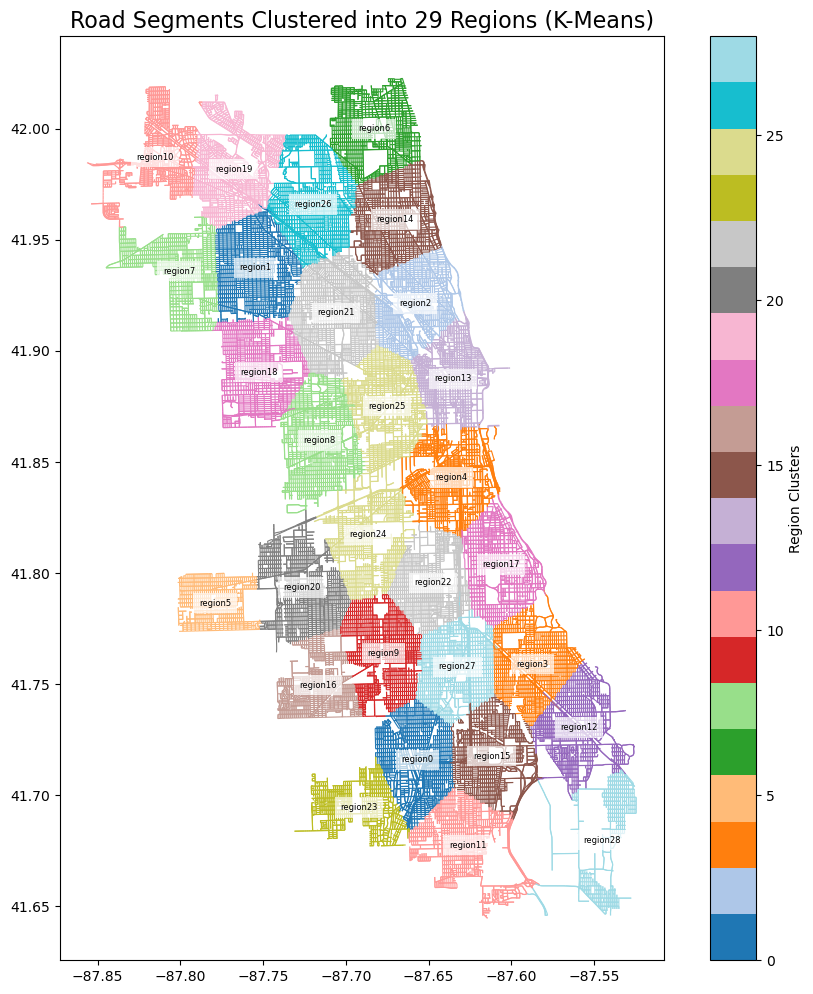

In [29]:
# Plot road segments on OSMnx, colored by their cluster (region)
fig, ax = plt.subplots(figsize=(12, 12))
# Calculate and plot region labels
region_centroids = edges.groupby('region')['geometry'].apply(lambda x: x.unary_union.centroid)

for region, centroid in region_centroids.items():
    ax.text(centroid.x, centroid.y, f'region{region}',  
            fontsize=6, ha='center', va='center', color='black', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

edges.plot(ax=ax, column='region', cmap='tab20', legend=True, linewidth=0.8, 
           legend_kwds={'label': "Region Clusters"})

# Add title
plt.title('Road Segments Clustered into 29 Regions (K-Means)', fontsize=16)

### 2.2 Extract the road segments details from G 

In [30]:
# create a new dataframe called data_merged_routes_diff500_chopped to only contain the unique routes
data_merged_routes_diff500_chopped=data_merged_routes_diff500.drop_duplicates(['shortest_route'])

In [ ]:
# define a function to extract the road segments details from each calculated shortest route in G
def extract_road_segments_details(row):
   # if the data was obtained by reading a csv file, the list of nodes would be string. Otherwise, it is a list of integers and can be used directly.   
    if isinstance(row['shortest_route'], str):
        shortest_route_str=row['shortest_route']
        nodes_str=re.findall(r'\d+', shortest_route_str)
        nodes_int=[int(x) for x in nodes_str]
    else:
        nodes_int=row['shortest_route']
    road_segments = []
    for u, v in zip(nodes_int[:-1], nodes_int[1:]):
        # by default, it wll be multi-edges between u and v 
        edgs = G[u][v]
        # If there's only one edge, take it
        if len(edgs) == 1:
            edge_data = list(edgs.values())[0]
        else:
            # For multiple edges, select the one with the minimum 'length' since this matches how we calculated the shortest route earlier
            edge_data = min(edgs.values(), key=lambda x: x.get('length', np.inf))
        # feed (u,v) info into edge_data which didnt contain it by default
        edge_data['u'] = u
        edge_data['v'] = v
        road_segments.append((u, v, edge_data))       
    edge_data_ls=[]
    free_travel_time_sec_ls=[]
    for segment in road_segments:
        u,v,edge_data=segment
        edge_data_ls.append(edge_data)
        free_travel_time_sec_ls.append(edge_data.get('travel_time', np.nan))
    free_travel_time_total_sec=sum(free_travel_time_sec_ls)
    return (free_travel_time_total_sec,  edge_data_ls)

In [ ]:
# application
data_merged_routes_diff500_chopped[['free_travel_time_total_sec', 
                                                               'edge_data_ls', 
                                                              ]]=data_merged_routes_diff500_chopped.apply(lambda row:
                                                                                                                          pd.Series(extract_road_segments_details(row)),
                                                                                                                          axis=1)

In [ ]:
# add the 'free_travel_time_total_sec' and 'edge_data_ls' columns to data_merged_routes_diff500 and rename it as trips_segs_merge
data_merged_routes_diff500_chopped_subcols=data_merged_routes_diff500_chopped[['free_travel_time_total_sec', 
                                                               'edge_data_ls', 'shortest_route']]
trips_segs_merge=pd.merge(data_merged_routes_diff500, data_merged_routes_diff500_chopped_subcols, on='shortest_route')

### 2.3 Display the road segments in our dataset on OSMnx graph and check their coverage ratio in each region

In [ ]:
# combine all road segments extracted from the existing dataset into a list 
shortest_routes_segs_ls=[]
for x in data_merged_routes_diff500_chopped['edge_data_ls'].values:
    shortest_routes_segs_ls.extend(x)

# use chuncks to deal with memory error
chunk_size = 100000  # Adjust based on available memory
chunks = []
for i in range(0, len(shortest_routes_segs_ls), chunk_size):
    chunk = pd.DataFrame(shortest_routes_segs_ls[i:i + chunk_size])
    chunks.append(chunk)

shortest_routes_segs_df = pd.concat(chunks, ignore_index=True)
# remove list object 
shortest_routes_segs_df=shortest_routes_segs_df.apply(remove_list_obj)
# remove duplicated segments
shortest_routes_segs_df_group=shortest_routes_segs_df.drop_duplicates()

In [ ]:
# Plot the road segments in our dataset on OSMnx graph to check their coverage
fig, ax = plt.subplots(figsize=(12, 12))

# define a function to plot the segments from the calculated shortest routes in our dataset
def plot_shortest_routes(row, graph=G, ax=ax, color='black', linewidth=0.5):
    geometry=row['geometry']
    ax.plot(*geometry.xy, color=color, linewidth=linewidth)

# plot all the edges in Chicago with their region label
region_centroids = edges.groupby('region')['geometry'].apply(lambda x: x.unary_union.centroid)
for region, centroid in region_centroids.items():
    ax.text(centroid.x, centroid.y, f'region{region}',  
            fontsize=6, ha='center', va='center', color='black', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
edges.plot(ax=ax, column='region', cmap='tab20', legend=True, linewidth=0.8, legend_kwds={'label': "Region Clusters"})

# Add title
plt.title('Road Segments Coverage Check', fontsize=16)
#apply the defined plot function to the extracted segments df
shortest_routes_segs_df_group.apply(lambda row: plot_shortest_routes(row), axis=1)

Analysis: from above plot, we can clearly see the following regions have relatively lower data coverage:
- region 5
- region 16
- region 23
- region 28

### 2.4 Complete the segment level traffic information   

In [ ]:
# define a function to create segment level dataframe while distributing the trip_secs to each road segment proportionally
def create_seg_level_df (row):
    total_free_travel_time=row['free_travel_time_total_sec']
    X=pd.DataFrame(row['edge_data_ls'])[['highway', 
        'speed_kph', 'travel_time', 'region',  'u', 'v']]
    X['inferred_travel_time_sec']=np.maximum(X['travel_time'], X['travel_time']/total_free_travel_time*row['trip_seconds'])
    X[['Unnamed: 0', 'trip_start_timestamp', 'trip_end_timestamp', 
       'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wpgt', 'pres']]=row[['Unnamed: 0', 'trip_start_timestamp', 'trip_end_timestamp', 
       'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wpgt', 'pres']]
    return X

**Note: if you run the following cell in notebook, it probably will cause page snapped (the data size is over 6GB). You can run it in Anaconda prompt instead**

In [ ]:
chunk_size = 100  # Adjust based on available memory
# Open the file in append mode and write chunks incrementally
for i in range(0, len(trips_segs_merge), chunk_size):
    chunk = trips_segs_merge.iloc[i:i + chunk_size]
    chunk_result = pd.concat(chunk.apply(create_seg_level_df, axis=1).to_list(), ignore_index=True)   
    # Write chunk results to file
    chunk_result.to_csv('segment_level_data.csv', mode='a', index=False, header=(i == 0));  

## Chapter 3 Check the Temporal Traffic Pattern Completeness for Each Region 

In [ ]:
# Load the CSV lazily with Dask due to the large size of the dataset
ddf = dd.read_csv('segment_level_data.csv')

In [ ]:
# split the huge dataset into 29 smaller datasets representing 29 regions
for region in range(29):
    print(region)
    filtered_region = ddf[ddf['region'] == region]   
    # Save the filtered data directly to a file
    filtered_region.to_csv(f'filtered_region_{region}.csv', single_file=True, index=False)

In [32]:
# load the trip level dataset for comparison
data_merged_routes_diff500=pd.read_csv('Chicago_routes_filter.csv')
# convert the timestamp columns into datetime object and extract year, month, day of week, and hour temporal infornation
data_merged_routes_diff500['trip_start_timestamp']=pd.to_datetime(data_merged_routes_diff500['trip_start_timestamp'])
data_merged_routes_diff500['trip_end_timestamp']=pd.to_datetime(data_merged_routes_diff500['trip_end_timestamp'])
data_merged_routes_diff500['year']=data_merged_routes_diff500['trip_start_timestamp'].dt.year
data_merged_routes_diff500['month']=data_merged_routes_diff500['trip_start_timestamp'].dt.month
data_merged_routes_diff500['dayname']=data_merged_routes_diff500['trip_start_timestamp'].dt.day_name()
data_merged_routes_diff500['hour_start']=data_merged_routes_diff500['trip_start_timestamp'].dt.hour
data_merged_routes_diff500['hour_end']=data_merged_routes_diff500['trip_end_timestamp'].dt.hour
# generate yearly traffic pattern 
total_yearly=data_merged_routes_diff500['year'].value_counts(normalize=True).sort_index()
yearly_comp=pd.DataFrame({'total_yearly': total_yearly})
# generate monthly traffic pattern 
total_monthly=data_merged_routes_diff500['month'].value_counts(normalize=True).sort_index()
monthly_comp=pd.DataFrame({'total_monthly': total_monthly})
# generate day of week traffic pattern 
total_daily=data_merged_routes_diff500['dayname'].value_counts(normalize=True).reindex(['Monday', 'Tuesday','Wednesday', 
                                                                                        'Thursday', 'Friday', 'Saturday', 'Sunday'], axis=1)
daily_comp=pd.DataFrame({'total_daily': total_daily})
# generate hourly traffic pattern 
total_hourly=data_merged_routes_diff500['hour_start'].value_counts(normalize=True).sort_index()
hourly_comp=pd.DataFrame({'total_hourly': total_hourly})

In [33]:
# Loop through each region for the same operation as above
for region in range(29):
    filtered_region=pd.read_csv(f'filtered_region_{region}.csv')   
    filtered_region['trip_start_timestamp']=pd.to_datetime(filtered_region['trip_start_timestamp'])
    filtered_region['trip_end_timestamp']=pd.to_datetime(filtered_region['trip_end_timestamp'])
    filtered_region['year']=filtered_region['trip_start_timestamp'].dt.year
    filtered_region['month']=filtered_region['trip_start_timestamp'].dt.month
    filtered_region['dayname']=filtered_region['trip_start_timestamp'].dt.day_name()
    filtered_region['hour_start']=filtered_region['trip_start_timestamp'].dt.hour
    filtered_region['hour_end']=filtered_region['trip_end_timestamp'].dt.hour
    
    # temporal pattern comparison
    region_yearly=filtered_region['year'].value_counts(normalize=True).sort_index()
    yearly_comp[f'region_{region}_yearly']=region_yearly
    region_monthly=filtered_region['month'].value_counts(normalize=True).sort_index()
    monthly_comp[f'region_{region}_monthly']=region_monthly
    region_daily=filtered_region['dayname'].value_counts(normalize=True).reindex(['Monday', 'Tuesday','Wednesday', 'Thursday', 
                                                                                  'Friday', 'Saturday', 'Sunday'], axis=1)
    daily_comp[f'region_{region}_daily']=region_daily
    region_hourly=filtered_region['hour_start'].value_counts(normalize=True).sort_index()
    hourly_comp[f'region_{region}_hourly']=region_hourly 
    # Clear memory by deleting the current region's dataframe
    del filtered_region
    # Force garbage collection
    gc.collect()
    print(f"Processed and cleared region {region}")

Processed and cleared region 0
Processed and cleared region 1
Processed and cleared region 2
Processed and cleared region 3
Processed and cleared region 4
Processed and cleared region 5
Processed and cleared region 6
Processed and cleared region 7
Processed and cleared region 8
Processed and cleared region 9
Processed and cleared region 10
Processed and cleared region 11
Processed and cleared region 12
Processed and cleared region 13
Processed and cleared region 14
Processed and cleared region 15
Processed and cleared region 16
Processed and cleared region 17
Processed and cleared region 18
Processed and cleared region 19
Processed and cleared region 20
Processed and cleared region 21
Processed and cleared region 22
Processed and cleared region 23
Processed and cleared region 24
Processed and cleared region 25
Processed and cleared region 26
Processed and cleared region 27
Processed and cleared region 28


Text(0.5, 1.0, 'montly temporal pattern comparison between regional and overall datasets')

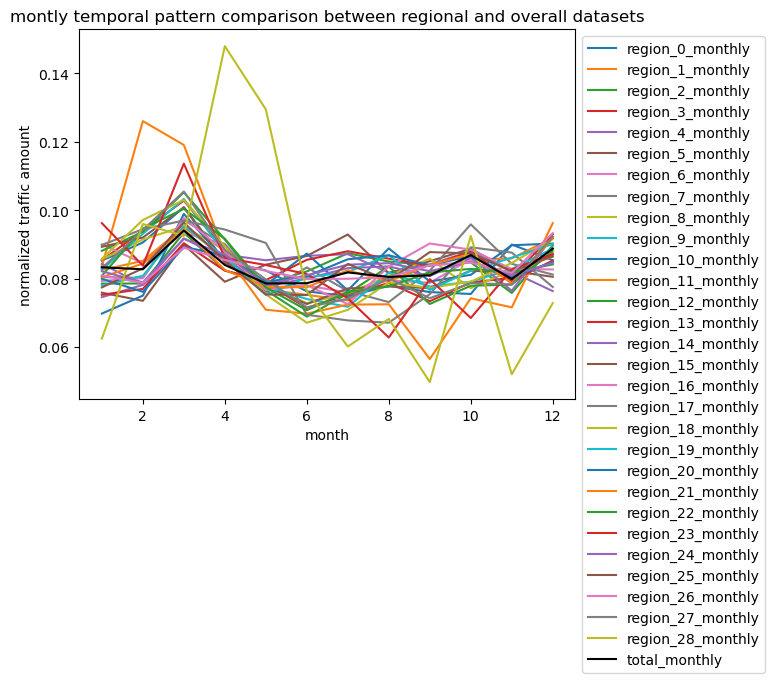

In [34]:
# monthly temporal pattern comparison between each regional dataset and the overall dataset
monthly_comp.iloc[:, 1:].plot(kind='line')
monthly_comp['total_monthly'].plot(kind='line', color='black')
plt.ylabel('normalized traffic amount')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Position legend outside the plot
plt.title('montly temporal pattern comparison between regional and overall datasets')

Text(0.5, 1.0, 'daily temporal pattern comparison between regional and overall datasets')

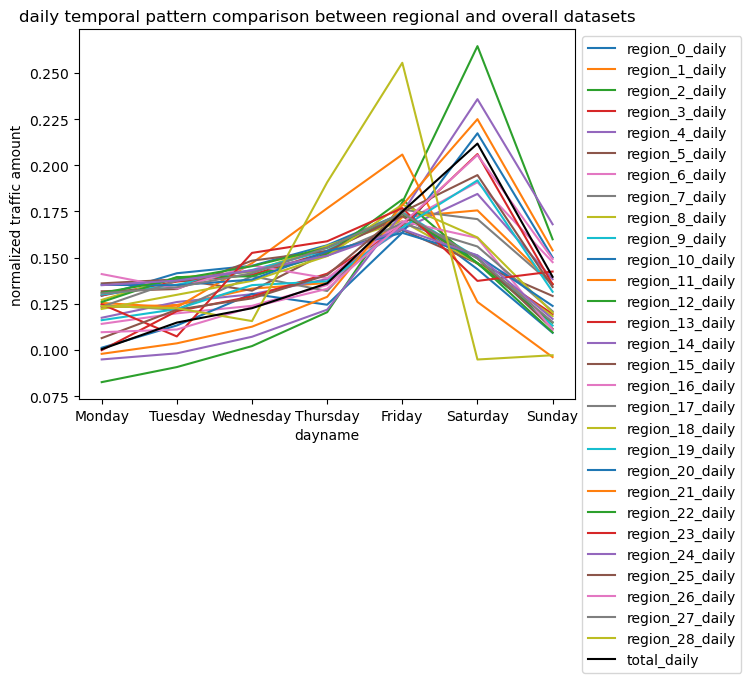

In [35]:
# daily temporal pattern comparison between each regional dataset and the overall dataset
daily_comp.iloc[:, 1:].plot(kind='line')
daily_comp['total_daily'].plot(kind='line', color='black')
plt.ylabel('normalized traffic amount')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('daily temporal pattern comparison between regional and overall datasets')

Text(0.5, 1.0, 'hourly temporal pattern comparison between regional and overall datasets')

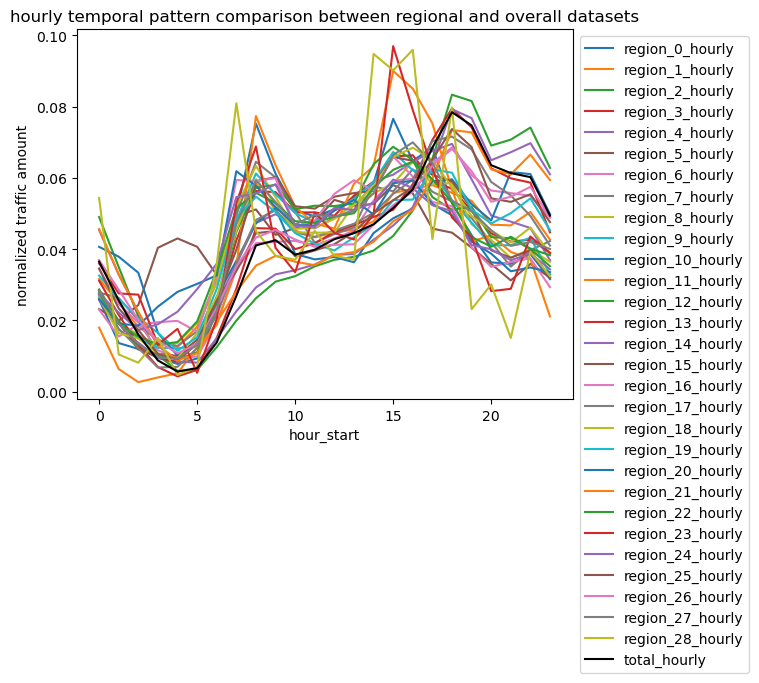

In [36]:
# hourly temporal pattern comparison between each regional dataset and the overall dataset
hourly_comp.loc[:, 'region_0_hourly':].plot(kind='line')
hourly_comp.loc[:, 'total_hourly'].plot(kind='line', color='black')
plt.ylabel('normalized traffic amount')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('hourly temporal pattern comparison between regional and overall datasets')

Analysis:
- we can see each region follows a similar temporal traffic patten to the overall dataset by monthly, daily, and hourly, although we also observe outlier plots, the temporal completeness looks good. 

## Chapter 4 Road Segments Clustering within Each Region

### 4.1 Data preparation for KMeans clustering

In [37]:
#define regions_timeframe dictionary is to save each regional data after aggregating the inferred travel time by timeframe for each segment
##timeframe here represents morning, afternoon, and night timeframes
regions_timeframe={}
#define regions_hourly dictionary is to save each regional data after aggregating the inferred travel time by hourly for each segment
regions_hourly={}
# Loop through each region
for region in range(29):
    filtered_region=pd.read_csv(f'filtered_region_{region}.csv')   
    filtered_region['trip_start_timestamp']=pd.to_datetime(filtered_region['trip_start_timestamp'])
    filtered_region['trip_end_timestamp']=pd.to_datetime(filtered_region['trip_end_timestamp'])
    filtered_region['year']=filtered_region['trip_start_timestamp'].dt.year
    filtered_region['month']=filtered_region['trip_start_timestamp'].dt.month
    filtered_region['dayname']=filtered_region['trip_start_timestamp'].dt.day_name()
    filtered_region['hour_start']=filtered_region['trip_start_timestamp'].dt.hour
    filtered_region['hour_end']=filtered_region['trip_end_timestamp'].dt.hour
    filtered_region['inferred_travel_time_sec'] = np.maximum(filtered_region['inferred_travel_time_sec'], filtered_region['travel_time'])
# add a new column 'morning_afternoon_night' to group hours of day to morning, afternoon, and night time frames 
    filtered_region['morning_afternoon_night'] = filtered_region['hour_start'].apply(
    lambda x: 'morning' if 6 <= x < 12 
              else 'afternoon' if 12 <= x <18 
              else 'night' )
   # aggregate the inferred_travel_time_sec by each timeframe for each segment 
    filtered_region_timeframe=filtered_region.groupby(
    ['u', 'v', 'morning_afternoon_night']
    )['inferred_travel_time_sec'].median().unstack().reindex(['morning', 'afternoon', 'night'], axis=1)
    regions_timeframe[f'filtered_region_{region}_timeframe']=filtered_region_timeframe
    # aggregate the inferred_travel_time_sec by hourly for each segment 
    filtered_region_hourly=filtered_region.groupby(
    ['u', 'v', 'hour_start']
    )['inferred_travel_time_sec'].median().unstack()
    regions_hourly[f'filtered_region_{region}_hourly']=filtered_region_hourly
    
    # Clear memory by deleting the current region's dataframe
    del filtered_region
    # Force garbage collection
    gc.collect()
    print(f"Processed and cleared region {region}")

Processed and cleared region 0
Processed and cleared region 1
Processed and cleared region 2
Processed and cleared region 3
Processed and cleared region 4
Processed and cleared region 5
Processed and cleared region 6
Processed and cleared region 7
Processed and cleared region 8
Processed and cleared region 9
Processed and cleared region 10
Processed and cleared region 11
Processed and cleared region 12
Processed and cleared region 13
Processed and cleared region 14
Processed and cleared region 15
Processed and cleared region 16
Processed and cleared region 17
Processed and cleared region 18
Processed and cleared region 19
Processed and cleared region 20
Processed and cleared region 21
Processed and cleared region 22
Processed and cleared region 23
Processed and cleared region 24
Processed and cleared region 25
Processed and cleared region 26
Processed and cleared region 27
Processed and cleared region 28


In [38]:
# define a function to fill NaN values in the aggregated hourly traffic distribution for each segment:
## fill each hourly missing data by the corresponding morning or afternoon or night aggregated traffic data for each segment 
## if the morning or afternoon or night aggregated traffic data is also missing, fill it by using the average over the existing other timeframes.
morning_hours=[6,7,8,9,10,11]
afternoon_hours=[12,13,14,15,16,17]
night_hours=[18,19,20,21,22,23,0,1,2,3,4,5]
def fill_na(row):
    for hour_col in range(24):
        if pd.isna(row[hour_col]):
            if hour_col in morning_hours:
                if not pd.isna(row['morning']):
                    row[hour_col]=row['morning']
                else:
                    row[hour_col]=np.nanmean([row['afternoon'], row['night']])
            elif hour_col in afternoon_hours:
                if not pd.isna(row['afternoon']):
                    row[hour_col]=row['afternoon']
                else:
                    row[hour_col]=np.nanmean([row['morning'], row['night']])
            else:
                if not pd.isna(row['night']):
                    row[hour_col]=row['night']
                else:
                    row[hour_col]=np.nanmean([row['morning'], row['afternoon']])
    return row

In [39]:
#application
regions_hourly_fillna={}
for region in range(29):
    filtered_region_merge=pd.merge(regions_hourly[f'filtered_region_{region}_hourly'],
                                              regions_timeframe[f'filtered_region_{region}_timeframe'], left_index=True, right_index=True)
    regions_hourly_fillna[f'filtered_region_{region}_hourly_fillna']=filtered_region_merge.apply(fill_na, axis=1).loc[:, :23]    

### 4.2 Use elbow method to determine K for each region

In [40]:
#select a specific region
region=0
X=regions_hourly_fillna[f'filtered_region_{region}_hourly_fillna']

# Extract aggregated hourly travel time data
hourly_data = X.values

# Normalize each segment by its total travel time to capture patterns
pattern_data = hourly_data / np.sum(hourly_data, axis=1, keepdims=True)

# Add the sum (scale) back as a feature
scale_feature = np.sum(hourly_data, axis=1).reshape(-1, 1)

# Combine pattern and scale features
combined_features = np.hstack((pattern_data, scale_feature))

C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

<Axes: title={'center': 'Elbow Plot'}, xlabel='Number of clusters', ylabel='Sum of Squared Errors'>

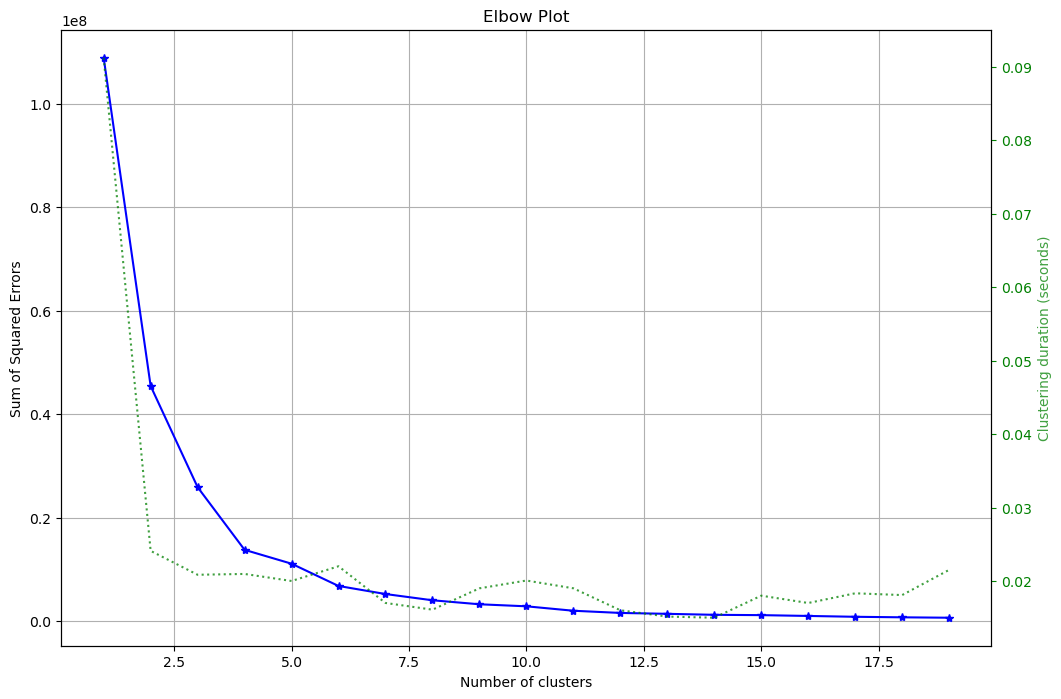

In [41]:
# plot the elbow plot
model = KMeans()
plot_elbow_curve(model, combined_features, cluster_ranges=range(1, min(20, len(X))), figsize=(12, 8))

Analysis:
- from the above plot, we can start with the K corresponding to the last elbow. In the above example where region=0, K=6.

In [42]:
# use KMeans to do clustering based on the obtained K
kmeans = KMeans(n_clusters=6, random_state=42) 
X['cluster']=kmeans.fit_predict(combined_features) 
X['cluster'].value_counts()

C:\Users\cclin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


cluster
0    551
4    437
2    344
3    250
1     50
5     13
Name: count, dtype: int64

In [ ]:
# Due to memory limitation, we have to delete the old region data after done with clustering before loading the new region in the following cell
del filtered_region
del merge
# Force garbage collection
gc.collect()

In [43]:
# check the clustering performance of the current K for the current region data
# load region data, we have to load regional data here since in the above code, 
## we deleted each region data right away after each processing
filtered_region=pd.read_csv(f'filtered_region_{region}.csv')   
filtered_region['trip_start_timestamp']=pd.to_datetime(filtered_region['trip_start_timestamp'])
filtered_region['trip_end_timestamp']=pd.to_datetime(filtered_region['trip_end_timestamp'])
filtered_region['year']=filtered_region['trip_start_timestamp'].dt.year
filtered_region['month']=filtered_region['trip_start_timestamp'].dt.month
filtered_region['dayname']=filtered_region['trip_start_timestamp'].dt.day_name()
filtered_region['hour_start']=filtered_region['trip_start_timestamp'].dt.hour
filtered_region['hour_end']=filtered_region['trip_end_timestamp'].dt.hour
filtered_region['inferred_travel_time_sec'] = np.maximum(filtered_region['inferred_travel_time_sec'], 
                                                         filtered_region['travel_time'])
filtered_region=filtered_region.set_index(['u', 'v'])

In [44]:
# merge the cluster column to the loaded region data
merge=pd.merge(filtered_region, X[['cluster']], left_index=True, right_index=True)
merge['cluster'].value_counts()

cluster
0    96449
4    54403
3    50219
2    37644
1     3517
5     1402
Name: count, dtype: int64

Text(0.5, 1.0, 'hourly aggregated inferred_travel_time_sec distribution for each cluster in region 0')

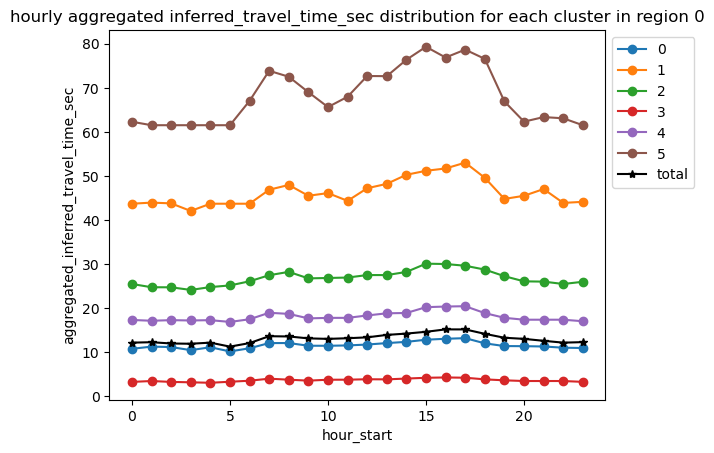

In [45]:
# plot the hourly aggregated inferred_travel_time_sec for each cluster 
time='hour_start'
df_plt=merge.groupby(['cluster', time])['inferred_travel_time_sec'].median().unstack().T
df_plt['total']=merge.groupby(time)['inferred_travel_time_sec'].median()
df_plt.iloc[:,:-1].plot(marker='o')
df_plt['total'].plot(marker='*', color='black', label='total')
plt.ylabel('aggregated_inferred_travel_time_sec')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title(f'hourly aggregated inferred_travel_time_sec distribution for each cluster in region {region}')

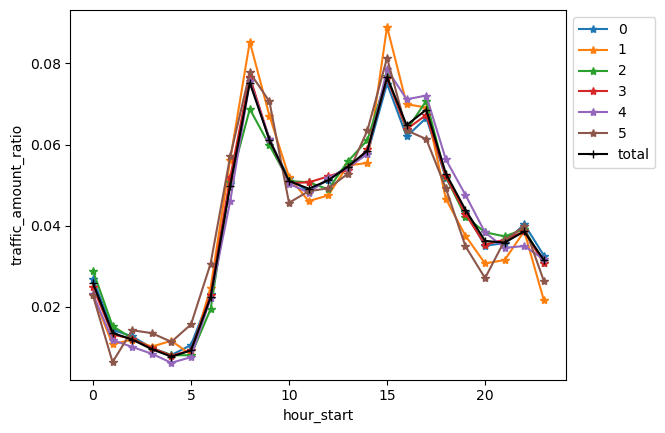

In [46]:
# plot the hourly traffic pattern for each cluster
df_plt2=merge.groupby('cluster')[time].value_counts(normalize=True).unstack().T
df_plt2['total']=merge[time].value_counts(normalize=True)
df_plt2.iloc[:,:-1].plot(marker='*')
df_plt2['total'].plot(marker='+', color='black', label='total')
plt.ylabel('traffic_amount_ratio')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

Analysis:
- by combining with the above two plots, we can determine whether to adjust K further. For example, if we noticed there exist clusters close to each other in the first plot (the inferred_travel_time_sec hourly distribution), we may want to reduce K, and if we noticed there exist incomplete lines for some clusters in both plots, we can also consider reducing K to try to merge these outliers with other clusters if reasonably. Our objective is to see  well separated complete lines in the first plot and high overlapped complete lines in the second plot. 

Cluster Result: based on checking the clustering result for each of 29 regions one by one, I got the following result. There exist some outliers I didnt merge into other clusters (marked by red) since I didnt want to sacrifice the clustering accuracy.

---

###### Region 0: 6 Clusters
- 0:    96,449 rows
- 4:   54,403
- 3:    50,219
- 2:    37,644
- 1:      **<span style="color:red;">3,517</span>**
- 5:     **<span style="color:red;">1,402</span>**

---

###### Region 1: 5 Clusters

- 2:    332,363
- 0:    161,706
- 4:     80,164
- 1:     76,591
- 3:     **<span style="color:red;">7,188</span>**
---

###### Region 2: 4 Clusters
- 1:    3,380,709
- 3:    2,380,233
- 0:    1,303,532
- 2:      88,891
---

###### Region 3: 5 Clusters
- 1:    401,577
- 3:    209,233
- 2:    154,352
- 0:     89,029
- 4:     **<span style="color:red;">7,300</span>** 
---

###### Region 4: 5 Clusters
- 0    700,478
- 2    532,191
- 1    281,492
- 4     43,570
- 3     **<span style="color:red;">5,098</span>**
---

###### Region 5: 5 Clusters
- 0    37,532
- 4     **<span style="color:red;">7,376</span>**
- 2     **<span style="color:red;">7,071</span>**
- 3     **<span style="color:red;">6,707</span>**
- 1     **<span style="color:red;">5,446</span>**


---

###### Region 6: 5 Clusters

- 4    440,870
- 2    270,005
- 0    146,883
- 1    117,562
- 3     10,666

---

###### Region 7: 5 Clusters

- 4    36,195
- 0    34,550
- 3    18,996
- 2    12,045
- 1    **<span style="color:red;">3,185</span>**


---

###### Region 8: 4 Clusters
- 2    372,019
- 0    221,825
- 1    100,684
- 3     36,581



---

###### Region 9: 5 Clusters
- 1    233,719
- 0     62,952
- 2     42,501
- 4     26,054
- 3      **<span style="color:red;">4,746</span>**


---

###### Region 10: 5 Clusters
- 1    44,793
- 0    26,938
- 3    11,885
- 2     **<span style="color:red;">2,402</span>**
- 4     **<span style="color:red;">13</span>**
---

###### Region 11: 5 Clusters
- 2    40,320
- 0    11,656
- 3     **<span style="color:red;">1,609</span>**
- 1     **<span style="color:red;">125</span>**  
- 4     **<span style="color:red;">71</span>**  
---

###### Region 12: 5 Clusters

- 0    116,669
- 4     48,947
- 2     37,257
- 1     **<span style="color:red;">518</span>**
- 3     **<span style="color:red;">3</span>**

---

###### Region 13: 5 Clusters

- 2    6,148,668
- 1    3,088,207
- 0    3,056,195
- 3     619,525
- 4      98,524

---

###### Region 14: 6 Clusters

- 5    1,157,573
- 0     765,385
- 4     525,156
- 3     520,131
- 1     287,293
- 2      11,593

---

###### Region 15: 5 Clusters
- 4    137,890
- 1     99,674
- 0     40,213
- 3      **<span style="color:red;">7,868</span>**
- 2      **<span style="color:red;">8</span>**

---

###### Region 16: 5 Clusters
- 0    35,594
- 3    19,156
- 4    10,396
- 1    **<span style="color:red;">4,800</span>**
- 2    **<span style="color:red;">2,892</span>**

---

###### Region 17: 5 Clusters

- 3    451,983
- 1    379,076
- 0    351,754
- 2    183,072
- 4     20,732


---

###### Region 18: 6 Clusters

- 5    128,354
- 0    100,929
- 2     85,153
- 1     78,779
- 4     35,143
- 3     **<span style="color:red;">1,168</span>**

---

###### Region 19: 4 Clusters

- 2    139,630
- 0     94,054
- 3     28,192
- 1     **<span style="color:red;">3,220</span>**


---

###### Region 20: 5 Clusters
- 4    180,024
- 0     70,587
- 1     43,093
- 2      **<span style="color:red;">2,896</span>**
- 3      **<span style="color:red;">1</span>**

---

###### Region 21: 5 Clusters
- 0    1,289,560
- 4    1,005,728
- 2     450,651
- 1     237,195
- 3      38,688

---

###### Region 22: 5 Clusters 
- 2    218,782
- 0    105,606
- 1     80,935
- 4     17,964
- 3     **<span style="color:red;">2,342</span>**
---

###### Region 23: 4 Clusters
- 3    12,658
- 1     **<span style="color:red;">8,365</span>**
- 0     **<span style="color:red;">5,909</span>**
- 2    **<span style="color:red;">425</span>**  


---

###### Region 24: 5 Clusters
- 0    304,168
- 4    170,309
- 3     59,218
- 2      **<span style="color:red;">4,870</span>**
- 1      **<span style="color:red;">2,257</span>**

---

###### Region 25: 5 Clusters
- 1    1,045,304
- 3     546,643
- 2     412,322
- 0     166,239
- 4      11,376



---

###### Region 26: 6 Clusters 
- 1    542,353
- 5    176,423
- 0    108,009
- 4     78,770
- 3     16,192
- 2      **<span style="color:red;">6</span>**

---

###### Region 27: 5 Clusters
- 1    398,144
- 3    200,025
- 0    154,587
- 2     70,160
- 4     **<span style="color:red;">961</span>**

---

###### **<span style="color:red;">Region 28: 4 Clusters</span>**
- 2    570
- 0    223
- 1     52
- 3     20

### 4.3 Save the obtained cluster information for each region to the segment level dataframe

In [ ]:
#obtained the number of clusters for each region from above
cluster_result=[6,5,4,5,5,5,5,5,4,5,5,5,5,5,6,5,5,5,6,4,5,5,5,4,5,5,6,5,4]
#since we deleted each region data right away due to memory limitation,
##we have to repeat the similar code as above in the following

# define time for the hourly aggregation 
time='hour_start'
# define regions_traveltime is to save each regional data by hourly aggregating the travel time for each cluster 
regions_traveltime={}
# define regions_traffic is to save each regional data by hourly aggregating the traffic amount for each cluster 
regions_traffic={}
#loop through each region, 
##which is repeating the above code but have to do this repeating for displaying all the plots together in the following
for region in range(29):
    X=regions_hourly_fillna[f'filtered_region_{region}_hourly_fillna']
    # Extract hourly travel time data
    hourly_data=X.values
    # Normalize each road segment by its total travel time to capture patterns
    pattern_data=hourly_data/np.sum(hourly_data, axis=1, keepdims=True)
    # Add the sum (scale) back as a feature
    scale_feature=np.sum(hourly_data, axis=1).reshape(-1,1)
    # Combine pattern and scale features
    combined_features=np.hstack((pattern_data, scale_feature))
    kmeans=KMeans(n_clusters=cluster_result[region], random_state=42)
    X['cluster']=kmeans.fit_predict(combined_features)
    filtered_region=pd.read_csv(f'filtered_region_{region}.csv')
    filtered_region['trip_start_timestamp']=pd.to_datetime(filtered_region['trip_start_timestamp'])
    filtered_region['trip_end_timestamp']=pd.to_datetime(filtered_region['trip_end_timestamp'])
    filtered_region['year']=filtered_region['trip_start_timestamp'].dt.year
    filtered_region['month']=filtered_region['trip_start_timestamp'].dt.month
    filtered_region['dayname']=filtered_region['trip_start_timestamp'].dt.day_name()
    filtered_region['hour_start']=filtered_region['trip_start_timestamp'].dt.hour
    filtered_region['hour_end']=filtered_region['trip_end_timestamp'].dt.hour
    filtered_region['inferred_travel_time_sec'] = np.maximum(filtered_region['inferred_travel_time_sec'], filtered_region['travel_time'])
    filtered_region=filtered_region.set_index(['u', 'v'])
    merge=pd.merge(filtered_region, X[['cluster']], left_index=True, right_index=True)
    df_traveltime=merge.groupby(['cluster', time])['inferred_travel_time_sec'].median().unstack().T
    df_traveltime['total']=merge.groupby(time)['inferred_travel_time_sec'].median()
    regions_traveltime[f'region_{region}']=df_traveltime
    df_traffic=merge.groupby('cluster')[time].value_counts(normalize=True).unstack().T
    df_traffic['total']=merge[time].value_counts(normalize=True)
    regions_traffic[f'region_{region}']=df_traffic
    merge.to_csv(f'region_{region}_withcluster.csv', index=True)
    # Clear memory by deleting the current region's dataframe
    del filtered_region
    del merge
    # Force garbage collection
    gc.collect()
    print(f"Processed and cleared region {region}")

In [ ]:
# compare the inferred travel time hourly distribution for each cluster with the corresponding total regional dataset 
fig, axs=plt.subplots(10, 3, figsize=(20,60))
for region in range(29):
    row_ind=region//3
    col_ind=region%3
    ax=axs[row_ind, col_ind]
    regions_traveltime[f'region_{region}'].iloc[:,:-1].plot(marker='o', ax=ax)
    regions_traveltime[f'region_{region}']['total'].plot(marker='*', color='black', label='total', ax=ax)
    ax.set_title(f'Region {region}', fontsize=10)
    ax.set_ylabel('aggregated_inferred_travel_time_sec', fontsize=8)
    ax.legend(fontsize=8)
# Hide unused subplot
axs[9, 2].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# compare the hourly traffic pattern  for each cluster with the corresponding total regional dataset 
fig, axs=plt.subplots(10, 3, figsize=(20,60))
for region in range(29):
    row_ind=region//3
    col_ind=region%3
    ax=axs[row_ind, col_ind]
    regions_traffic[f'region_{region}'].iloc[:,:-1].plot(marker='*', ax=ax)
    regions_traffic[f'region_{region}']['total'].plot(marker='+', color='black', label='total', ax=ax)
    ax.set_title(f'Region {region}', fontsize=10)
    ax.set_ylabel('normalized traffic amount', fontsize=8)
    ax.legend(fontsize=8)
# Hide unused subplot
axs[9, 2].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

### 4.4 Display the above plotted results onto map

#### 4.4.1 Region data preparation

In [48]:
# select a specific region dataset to display
region=1
region_withcluster=pd.read_csv(f'region_{region}_withcluster.csv')
region_withcluster.head()

u          v  lanes      highway  speed_kph  travel_time  region  \
0  256171157  256171159    5.0    secondary       43.8         16.7       1   
1  256171159  261250154    3.0    secondary       43.8          8.3       1   
2  261250154  261145124    3.0    secondary       43.8          8.5       1   
3  261145124  261200366    3.0    secondary       43.8          8.3       1   
4  261210232  289549940    2.0  residential       31.9         11.5       1   

  junction bridge tunnel  ... prcp   wdir  wpgt    pres  year  month  dayname  \
0       no     no     no  ...  0.0  300.0   NaN  1009.0  2023      5  Tuesday   
1       no     no     no  ...  0.0  300.0   NaN  1009.0  2023      5  Tuesday   
2       no     no     no  ...  0.0  300.0   NaN  1009.0  2023      5  Tuesday   
3       no     no     no  ...  0.0  300.0   NaN  1009.0  2023      5  Tuesday   
4       no     no     no  ...  0.0  260.0   NaN  1015.5  2023      5  Tuesday   

   hour_start  hour_end  cluster  
0          19        20        1  
1          19        20        4  
2          19        20        4  
3          19        20        4  
4           9         9        2  

[5 rows x 28 columns]

In [49]:
# aggregate both the inferred travel time and the free flow travel time by the same hour for each specific road segment
region_data=region_withcluster.groupby(['cluster', 'u', 'v', 'hour_start'])[['inferred_travel_time_sec', 'travel_time']].median()
region_data.head()

inferred_travel_time_sec  travel_time
cluster u        v          hour_start                                       
0       35034233 1316564940 0                           2.075819          1.5
                            1                           1.954976          1.5
                            2                           1.899238          1.5
                            3                           1.831912          1.5
                            4                           1.878692          1.5

In [50]:
# Add a congestion level column by comparing inferred_travel_time_sec with travel_time
def calculate_congestion_level(row):
    if pd.isna(row['inferred_travel_time_sec']):
        ratio==1
        return (ratio, 'lightgreen', 'free-flow')  # Mark NaN values as free flow
    ratio = row['inferred_travel_time_sec'] / row['travel_time']
    if ratio <= 1.2:
        return (ratio, 'lightgreen', 'free_flow')  # Free flow
    elif ratio <= 1.5:
        return (ratio, 'green', 'slight congestion')  # Slight congestion
    elif ratio <= 2.0:
        return (ratio, '#E65100', 'medium congestion')  # Medium congestion
    elif ratio >2:
        return (ratio, 'darkred', 'severe congestion')  # Severe congestion
#application
region_data[['congestion_ratio', 'congestion_level', 'congestion_level_explanation']] = region_data.apply(lambda row: pd.Series(
                                                                                                                                        calculate_congestion_level(row)), axis=1)

In [51]:
# combine 'highway' column to region_data to reflect the road type information on map
m1=region_data.reset_index()
m2=region_withcluster.drop_duplicates(['u','v'])[['u', 'v', 'highway']]
merge=pd.merge(m1, m2, on=['u', 'v'])
region_data=merge.set_index(['cluster', 'u', 'v','hour_start'])

#### 4.4.2 Plot road segments on map, colored by congestion level

In [ ]:
#create an OSMnx graph for Chicago city
place = 'Chicago, Illinois, USA'
G = ox.graph_from_place(place, network_type='drive')

#add speed limit and free flow travel_time attributes to the edges.
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
# create geo-dataframe for both nodes and edges 
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
# add geometry from edges to G for plot in the following
for idx, row in edges.reset_index().iterrows():
    u, v, key = row['u'], row['v'], row['key']
    G[u][v][key]['geometry'] = row['geometry']

In [ ]:
# Define a function to plot road segments of a region with cluster and hour-based filtering on map
def plot_region_with_filters(region_data, region_id, G):
    # Initialize map centered on Chicago
    m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

    # Add a base layer with no visible data
    folium.TileLayer("cartodbdark_matter", name="No Data Visible", control=True).add_to(m)

    # Iterate through clusters and hours
    clusters = region_data.index.get_level_values("cluster").unique()

    for cluster in clusters:
        # Filter data for the current cluster 
        cluster_data = region_data[region_data.index.get_level_values("cluster") == cluster]
        for hour in range(24):  # Loop through hours from 0 to 23
            hour_data = cluster_data[cluster_data.index.get_level_values("hour_start") == hour]    
            # Prepare GeoJSON data
            geojson_data = {"type": "FeatureCollection", "features": []}

            for index, row in hour_data.iterrows():
                _, u, v,  hour_start = index
                    
                # Try to get the edge geometry
                edgs = G[u][v]
                if len(edgs) == 1:
                    edge_data = list(edgs.values())[0]
                else:
                    edge_data = min(edgs.values(), key=lambda x: x.get("length", float("inf")))

                # Extract coordinates from LineString
                line_coords = list(edge_data["geometry"].coords)

                # Add road segment as a GeoJSON feature
                feature = {
                        "type": "Feature",
                        "geometry": {
                            "type": "LineString",
                            "coordinates": line_coords
                        },
                        "properties": {
                            "congestion_level": row["congestion_level"],
                            "popup": (
                                f"Inferred Travel Time: {row['inferred_travel_time_sec']} sec<br>"
                                f"Free Flow Time: {row['travel_time']} sec<br>"
                                f"Congestion: {row['congestion_level_explanation']}<br>"
                                f"Congestion_ratio: {row['congestion_ratio']}<br>"
                                f"roadtype: {row['highway']}"
                            )
                        }
                    }
                geojson_data["features"].append(feature)

          
                # Add GeoJson layer for the specific cluster and hour, hidden by default
            folium.GeoJson(
                    geojson_data,
                    name=f"Cluster {cluster}  | Hour {hour}",  # Layer name for toggling
                    style_function=lambda feature: {
                            "color": feature["properties"]["congestion_level"],
                            "weight": 5,
                            "opacity": 1.0
                        },
                        popup=folium.GeoJsonPopup(
                            fields=["popup"],
                            aliases=["Info: "],
                            sticky=True,
                            max_width=400
                        ),
                        show=False  # Hide this layer by default
                    ).add_to(m)

    # Add layer control to toggle between combinations
    folium.LayerControl(collapsed=False).add_to(m)

    # Add title
    title_html = f"""
        <h3 align="center" style="font-size:16px"><b>Region {region_id} Traffic Congestion<br></h3>
        """
    m.get_root().html.add_child(folium.Element(title_html))

    return m


# Example usage
map_region = plot_region_with_filters(region_data=region_data, region_id=1, G=G)
map_region.save("region_1_traffic_filters_map_new.html")  # Save as an interactive HTML
map_region

#### 4.4.3 Display the shortest routes calculated by inferred travel time and free flow travel time on map for comparison

In [53]:
# randomly pick an hour time
hour_time=10
region_data_hour=region_data[region_data.index.get_level_values('hour_start')==hour_time]

In [54]:
#define a function to create a directed graph from the region_data dataframe.
def create_subset_graph_with_inferred_time(G, region_data_hour):
    # Extract relevant edges (u, v) from region_data_hour
    relevant_edges = [(row.name[1], row.name[2]) for _, row in region_data_hour.iterrows()]
    relevant_nodes = set([node for edge in relevant_edges for node in edge])

    # Handle multi-edge graph by selecting the shortest edge for each (u, v)
    subset_edges = []
    for u, v in relevant_edges:
        if G.has_edge(u, v):  
            # Find the edge with the minimum 'length' 
            min_edge_key = min(G[u][v], key=lambda k: G[u][v][k].get('length', float('inf')))
            subset_edges.append((u, v, min_edge_key))

    # Create the subset graph with the selected edges
    G_c = G.edge_subgraph(subset_edges).copy()

    # Add the inferred_travel_time_sec attribute from region_data_hour to the edges in G_c
    for _, row in region_data_hour.iterrows():
        u, v = row.name[1], row.name[2]
        edge_keys = list(G_c[u][v].keys())  
        first_key = edge_keys[0]  # Get the first key
        G_c[u][v][first_key]['inferred_travel_time_sec'] = row['inferred_travel_time_sec']
        G_c[u][v][first_key]['congestion_level_explanation'] = row['congestion_level_explanation']
        G_c[u][v][first_key]['congestion_ratio'] = row['congestion_ratio']


    # Ensure all relevant nodes are included
    for node in relevant_nodes:
        if node not in G_c.nodes and node in G:
            G_c.add_node(node, **G.nodes[node])

    return G_c


# Example usage
G_c = create_subset_graph_with_inferred_time(G, region_data_hour)
print(f"Subset graph has {G_c.number_of_nodes()} nodes and {G_c.number_of_edges()} edges.")

# Example to inspect an edge's attributes
u, v, key = next(iter(G_c.edges))
print(f"Edge ({u}, {v}) attributes: {G_c[u][v][key]}")

Subset graph has 919 nodes and 1784 edges.
Edge (317749252, 317749771) attributes: {'osmid': 97519051, 'name': 'West Addison Street', 'highway': 'secondary', 'oneway': False, 'reversed': False, 'length': 56.115, 'speed_kph': 43.8, 'travel_time': 4.6, 'region': 1, 'geometry': <LINESTRING (-87.743 41.946, -87.742 41.946)>, 'inferred_travel_time_sec': 7.480773940729855, 'congestion_level_explanation': 'medium congestion', 'congestion_ratio': 1.6262552045064904}


In [55]:
# define a function to find a pair of nodes (start_node, end_node) in the graph with multiple routes between them
def find_pair_with_multiple_routes(region_data_hour, G_c):
    
    # Get unique list of nodes
    unique_nodes = list(set(G_c.nodes))  

    # Find a pair of nodes with multiple paths
    for i, start_node in enumerate(unique_nodes):
        for end_node in unique_nodes[i + 1:]:  # Check unique pairs (start_node, end_node)
            paths = list(nx.all_simple_paths(G_c, source=start_node, target=end_node, cutoff=5))  # Limit to 5 edges for simplicity
            if len(paths) > 1:  # Check if there are multiple paths
                return start_node, end_node
    # If no suitable pair is found, return None
    return None, None
# Example usage
start_node, end_node = find_pair_with_multiple_routes(region_data_hour, G_c)
if start_node and end_node:
    print(f"Found suitable nodes: Start Node = {start_node}, End Node = {end_node}")
else:
    print("No suitable nodes with multiple routes found.")


Found suitable nodes: Start Node = 261212166, End Node = 261145231


In [56]:
# define a function to calculate the shortest route in a graph based on a given weight
def calculate_shortest_route(G_c, start_node, end_node, weight):

    # Calculate the shortest path
    path = nx.shortest_path(G_c, source=start_node, target=end_node, weight=weight)
    
    # Calculate the total weight of the path
    total_time = nx.shortest_path_length(G_c, source=start_node, target=end_node, weight=weight)
    
    return path, total_time


# Shortest route based on real traffic time
path_inferred, time_inferred = calculate_shortest_route(G_c, start_node, end_node, weight='inferred_travel_time_sec')
print(f"Shortest path (real traffic): {path_inferred}, Total time: {time_inferred} sec")

# Shortest route based on free-flow travel time
path_free_flow, time_free_flow = calculate_shortest_route(G_c, start_node, end_node, weight='travel_time')
print(f"Shortest path (free flow): {path_free_flow}, Total time: {time_free_flow} sec")

Shortest path (real traffic): [261212166, 261275109, 261123541, 261123542, 261123543, 261145231], Total time: 120.77379301069362 sec
Shortest path (free flow): [261212166, 261275109, 261123541, 261275234, 261227515, 261145231], Total time: 67.9 sec


In [57]:
# Define a function to display the calculated shortest routes on a map with detailed segment traffic info
def display_shortest_routes_with_details(G_c, start_node, end_node):

    # Initialize map centered at the start node
    start_coords = (G_c.nodes[start_node]['y'], G_c.nodes[start_node]['x'])  # (latitude, longitude)
    m = folium.Map(location=start_coords, zoom_start=13)

    # Define weights and their visualization styles
    route_styles = {
        'inferred_travel_time_sec': {'color': '#E65100', 'dash_array': None},  # Solid red line
        'travel_time': {'color': '#E65100', 'dash_array': '5,10'},  # Dashed green line
    }

    for weight, style in route_styles.items():
        # Calculate shortest path and its nodes
        path = nx.shortest_path(G_c, source=start_node, target=end_node, weight=weight)
        
        # Extract edges and their corresponding traffic information
        for u, v in zip(path[:-1], path[1:]):  # Iterate over consecutive nodes in the path
            edge_data = G_c[u][v]  # Access edge data
            edge_keys = list(G_c[u][v].keys())
            first_key = edge_keys[0]  # get the first key
            edge_geometry = edge_data[first_key].get("geometry")

        
            # Extract traffic information
            inferred_time = edge_data[first_key].get("inferred_travel_time_sec", "N/A")
            free_flow_time = edge_data[first_key].get("travel_time", "N/A")
            congestion_level=edge_data[first_key].get("congestion_level_explanation", "N/A")
            congestion_ratio=edge_data[first_key].get("congestion_ratio", "N/A")

            # Add the edge as a polyline to the map
            line_coords = list(edge_geometry.coords)
            line_coords_reversed = [[lat, lon] for lon, lat in line_coords]  # Reverse for folium
            folium.PolyLine(
                locations=line_coords_reversed,
                color=style['color'],
                weight=5,
                dash_array=style['dash_array'],  # Add dash style for travel_time route
                tooltip=f"<b>Route by {weight}</b><br>"
                        f"Start: {u}, End: {v}<br>"
                        f"Inferred Time: {inferred_time} sec<br>"
                        f"Free Flow Time: {free_flow_time} sec<br> "
                        f"Congestion_level: {congestion_level}<br>"
                        f"Congestion_ratio: {congestion_ratio}<br>"
            ).add_to(m)

    # Add markers for start and end nodes
    folium.Marker(location=start_coords, popup="Start Node", icon=folium.Icon(color="blue")).add_to(m)
    end_coords = (G_c.nodes[end_node]['y'], G_c.nodes[end_node]['x'])
    folium.Marker(location=end_coords, popup="End Node", icon=folium.Icon(color="blue")).add_to(m)
     # Add title
    title_html = f"""
        <h3 align="center" style="font-size:16px"><b>Region {region} Traffic Congestion at 10 am<br></h3>
        """
    m.get_root().html.add_child(folium.Element(title_html))


    return m


# Example usage
map_routes = display_shortest_routes_with_details(G_c, start_node, end_node)
map_routes.save("shortest_routes_with_details_map_new.html")  # Save as an interactive HTML
map_routes

## Chapter 5  Build ML models for predicting the  travel time for each road segment cluster

### 5.1 Check the clustering accuracy by plotting the inferred travel time histogram for each cluster

In [58]:
# pick one region
region=1
region_withcluster=pd.read_csv(f'region_{region}_withcluster.csv')
region_withcluster.head()

u          v  lanes      highway  speed_kph  travel_time  region  \
0  256171157  256171159    5.0    secondary       43.8         16.7       1   
1  256171159  261250154    3.0    secondary       43.8          8.3       1   
2  261250154  261145124    3.0    secondary       43.8          8.5       1   
3  261145124  261200366    3.0    secondary       43.8          8.3       1   
4  261210232  289549940    2.0  residential       31.9         11.5       1   

  junction bridge tunnel  ... prcp   wdir  wpgt    pres  year  month  dayname  \
0       no     no     no  ...  0.0  300.0   NaN  1009.0  2023      5  Tuesday   
1       no     no     no  ...  0.0  300.0   NaN  1009.0  2023      5  Tuesday   
2       no     no     no  ...  0.0  300.0   NaN  1009.0  2023      5  Tuesday   
3       no     no     no  ...  0.0  300.0   NaN  1009.0  2023      5  Tuesday   
4       no     no     no  ...  0.0  260.0   NaN  1015.5  2023      5  Tuesday   

   hour_start  hour_end  cluster  
0          19        20        1  
1          19        20        4  
2          19        20        4  
3          19        20        4  
4           9         9        2  

[5 rows x 28 columns]

In [ ]:
region_withcluster.columns

In [59]:
# check the data amount within each cluster
region_withcluster['cluster'].value_counts()

cluster
4    256555
2    147299
0    141226
1    105744
3      7188
Name: count, dtype: int64

In [60]:
# pick one cluster for specific analysis
cluster=0
filtered_cluster=region_withcluster[region_withcluster['cluster']==cluster]
filtered_cluster.shape

(141226, 28)

In [61]:
# check the duplicated trip_start_timestamps within a cluster
duplicated_time=filtered_cluster.duplicated('trip_start_timestamp').sum()
# calculate the valid number of rows (unique timestamps) we can use for the modeling
unique_timestamps=filtered_cluster.shape[0]-duplicated_time
unique_timestamps

15990

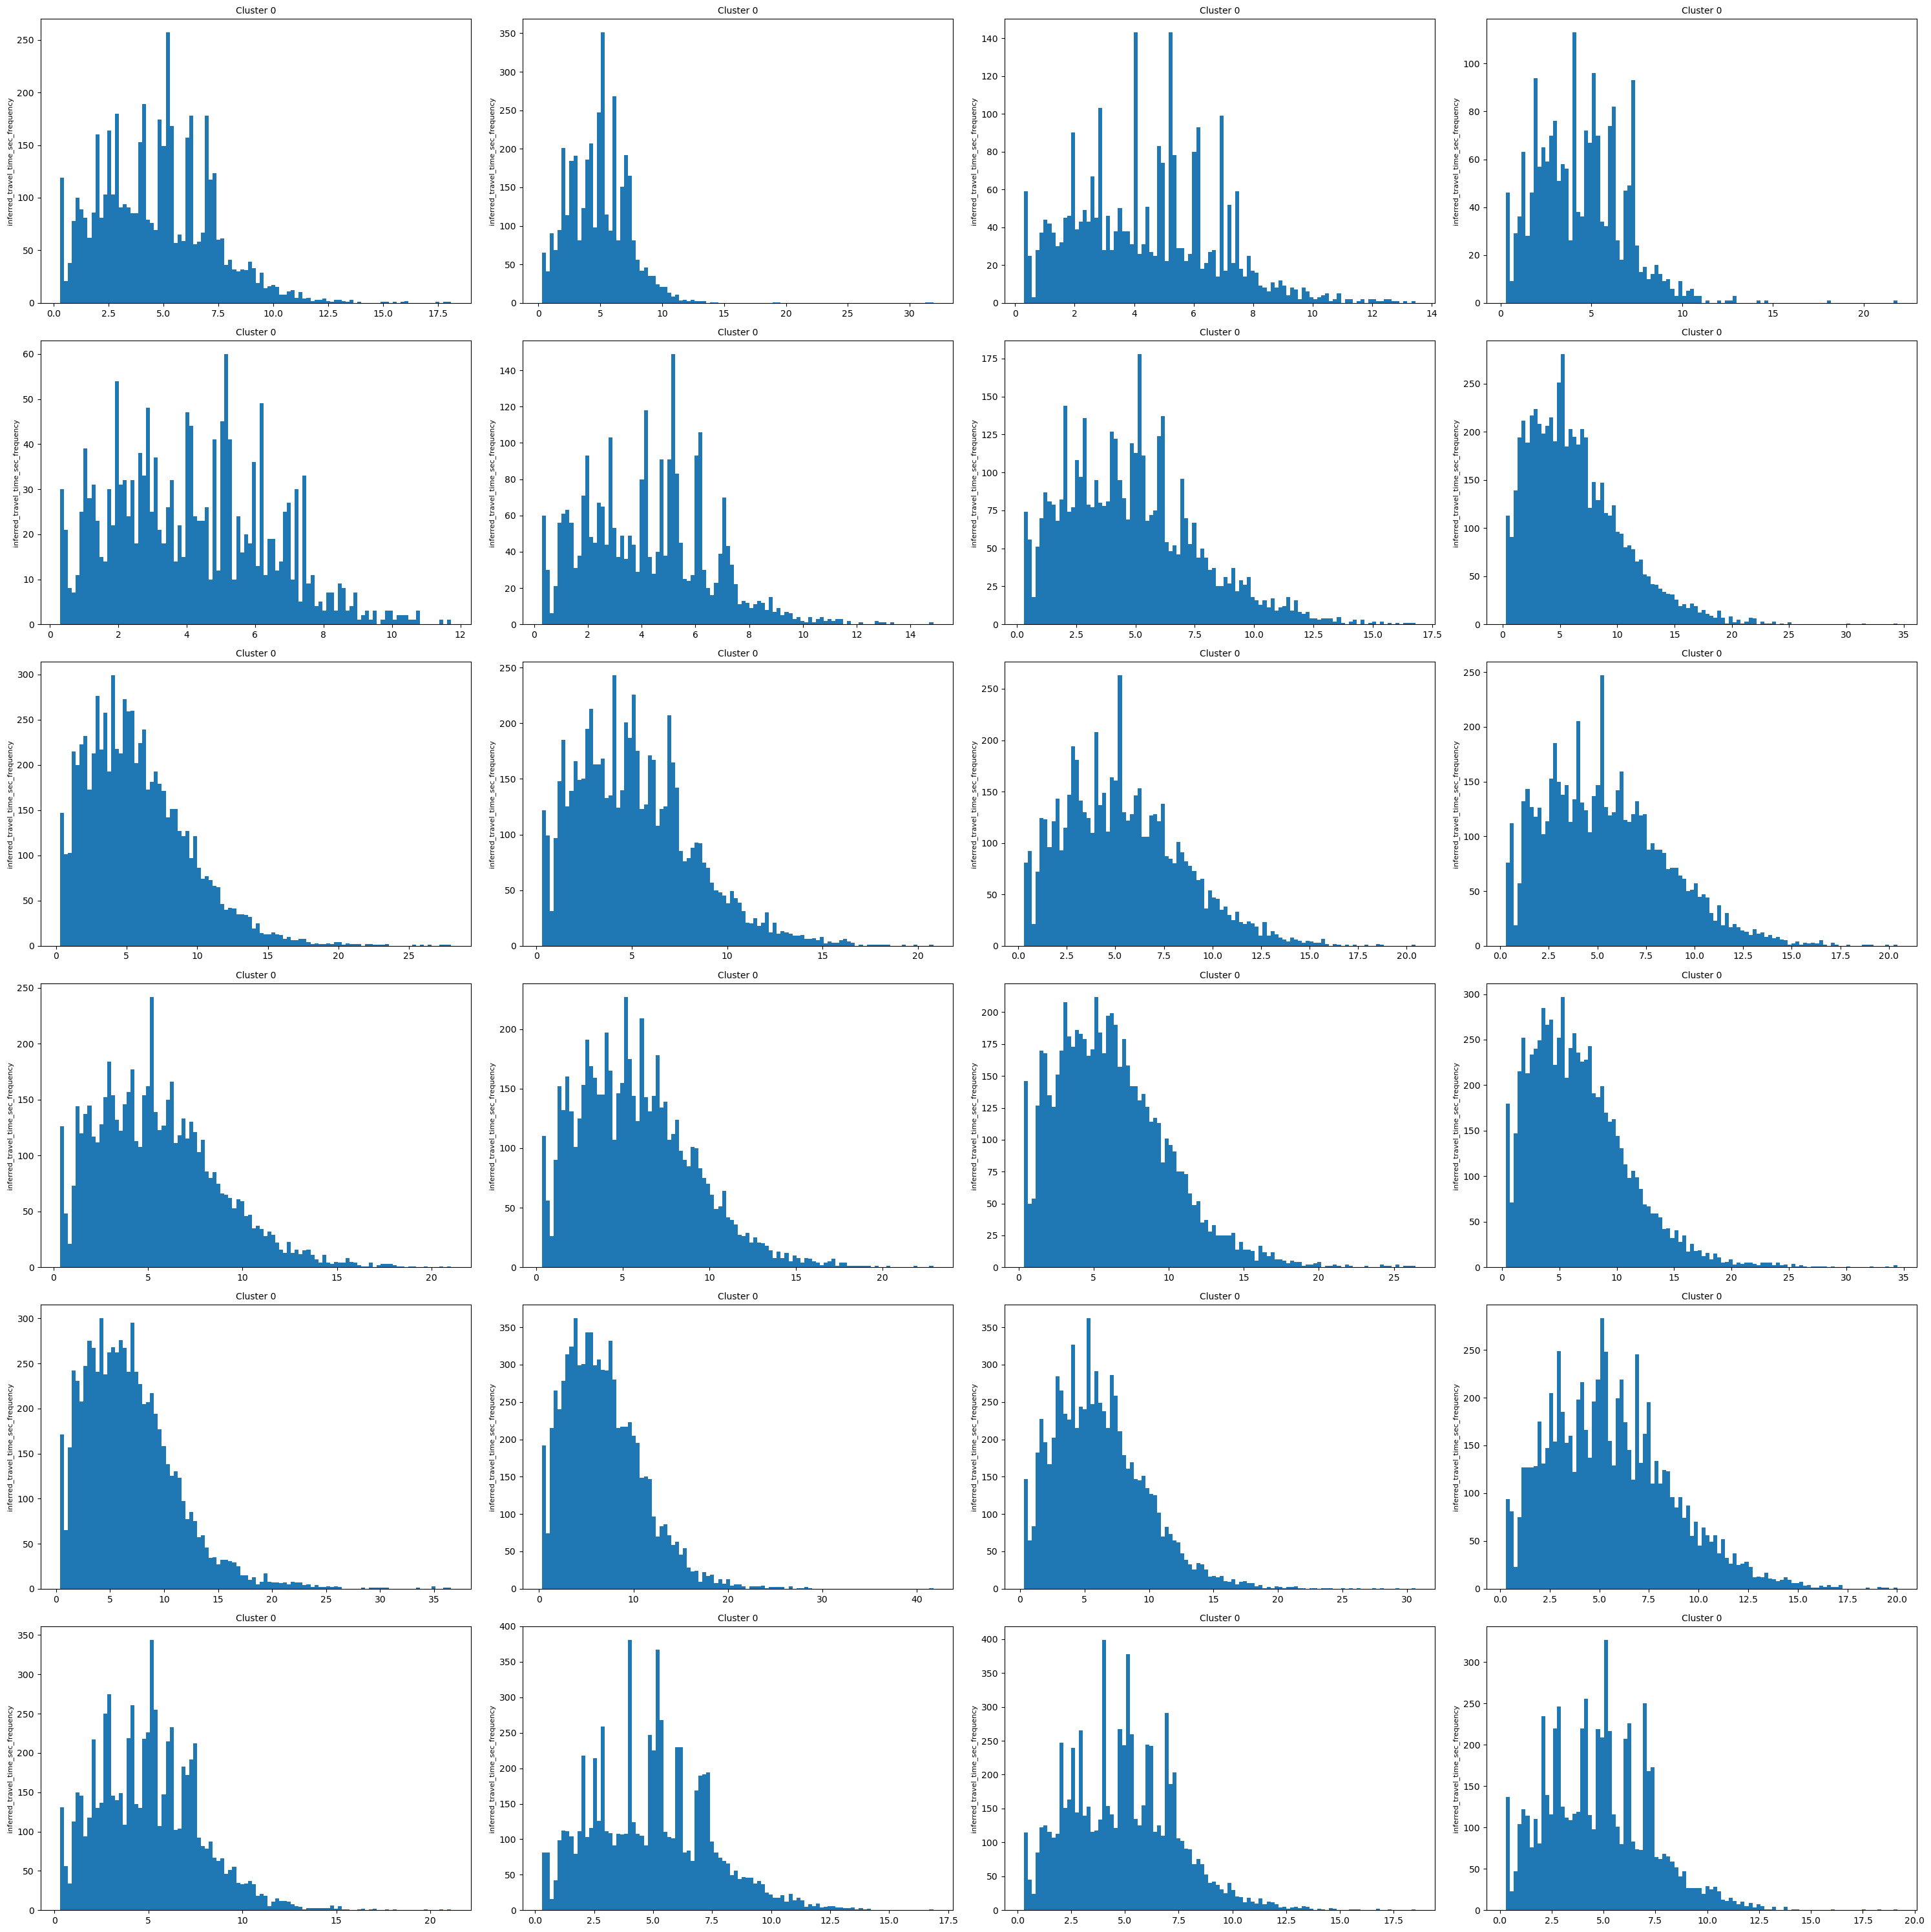

In [62]:
# check the clustering accuracy by plotting the inferred_travel_time_sec histogram 
##for each hour, expecting to see a bell shaped distribution 
fig, axs=plt.subplots(6, 4, figsize=(30,30))
for hour in range(24):
    row_ind=hour//4
    col_ind=hour%4
    ax=axs[row_ind, col_ind]
    filtered_cluster_hour=filtered_cluster[filtered_cluster['hour_start']==hour]
    filtered_cluster_hour['inferred_travel_time_sec'].plot(ax=ax, kind='hist', bins=100)
    ax.set_title(f'Cluster {cluster}', fontsize=10)
    ax.set_ylabel('inferred_travel_time_sec_frequency', fontsize=8)
# Adjust layout
plt.tight_layout()
plt.show()

<Axes: ylabel='Frequency'>

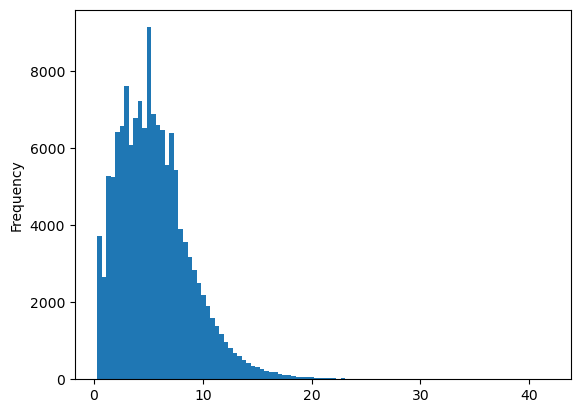

In [63]:
#check the overal histogram for all hours
filtered_cluster['inferred_travel_time_sec'].plot( kind='hist', bins=100)

In [64]:
filtered_cluster['inferred_travel_time_sec'].describe().drop('count')

mean     5.607028
std      3.365375
min      0.300000
25%      3.057829
50%      5.200000
75%      7.400000
max     41.757469
Name: inferred_travel_time_sec, dtype: float64

Analysis:
- for the hourly histograms, if all of them comply with a bell shape, we can say the clustering works well by grouping road segments with good travel time similarity.

In [ ]:
# further check the accuracy about aggregating the inferred_travel_time_sec by grouping duplicated timestamp

# check the duplicated trip_start_timestamp 
filtered_cluster['trip_start_timestamp'].value_counts()

In [ ]:
#randomly pick a timestamp sample to check the accuracy
sample_time='2023-11-11 18:45:00' 
filtered_cluster[filtered_cluster['trip_start_timestamp']==sample_time]['inferred_travel_time_sec'].plot(kind='hist', bins=50)

In [ ]:
med=filtered_cluster[filtered_cluster['trip_start_timestamp']==sample_time]['inferred_travel_time_sec'].median()
avg=filtered_cluster[filtered_cluster['trip_start_timestamp']==sample_time]['inferred_travel_time_sec'].median()
print(f'median: {med}, mean: {avg}')

Analysis:
- from the above histogram, we can see the variance of the inferred travel time with the same timestamps is not significant.
- the mean and medain are close to each other, and each of them can be a good representative for the group.

In [65]:
# convert the trip_start_timestamp column to datetime format
filtered_cluster['trip_start_timestamp'] = pd.to_datetime(filtered_cluster['trip_start_timestamp'])
# add a new column that extracts the day of a month for the following analysis
filtered_cluster['day']=filtered_cluster['trip_start_timestamp'].dt.day

C:\Users\cclin\AppData\Local\Temp\ipykernel_16092\1206880396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cluster['trip_start_timestamp'] = pd.to_datetime(filtered_cluster['trip_start_timestamp'])
C:\Users\cclin\AppData\Local\Temp\ipykernel_16092\1206880396.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cluster['day']=filtered_cluster['trip_start_timestamp'].dt.day


In [66]:
# aggregate the rows with the same timestamp
filtered_cluster_groupbytime=pd.DataFrame({'inferred_traveltime_sec_updated': 
                                                 filtered_cluster.groupby('trip_start_timestamp')['inferred_travel_time_sec'].median()})
# Set the trip_start_timestamp column as the index
filtered_cluster.set_index('trip_start_timestamp', inplace=True)
# Sort the DataFrame by the index in ascending order
filtered_cluster.sort_index(inplace=True)
# update the filtered_cluster dataframe after groupby timestamp so as to remove the columns 
##which are specific to individual road segment since the aggregation operation made these columns meaningless
filtered_cluster_updatedbytime=pd.merge(filtered_cluster_groupbytime, filtered_cluster.loc[:, 
                                                            ['temp', 'dwpt', 'rhum', 'prcp', 'wdir',  'pres', 'year', 'month','dayname', 'day', 'hour_start']].copy(),
                                                            left_index=True, right_index=True)
# drop the rows with duplicated timestamp
filtered_cluster_updatedbytime=filtered_cluster_updatedbytime[~filtered_cluster_updatedbytime.index.duplicated(keep='first')]
filtered_cluster_updatedbytime

C:\Users\cclin\AppData\Local\Temp\ipykernel_16092\3902622495.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cluster.sort_index(inplace=True)


inferred_traveltime_sec_updated  temp  dwpt  rhum  prcp  \
trip_start_timestamp                                                            
2023-05-01 00:30:00                          2.750000   6.1   2.2  76.0   0.4   
2023-05-01 05:45:00                          7.844275   5.6   1.7  76.0   0.0   
2023-05-01 06:30:00                          7.582883   5.6   1.1  73.0   0.0   
2023-05-01 07:15:00                         10.843412   5.6   1.1  73.0   0.0   
2023-05-01 08:00:00                          6.121863   5.0   1.7  79.0   0.0   
...                                               ...   ...   ...   ...   ...   
2024-04-30 20:00:00                          5.100000  21.7   9.6  46.0   0.0   
2024-04-30 21:45:00                          6.082825  23.3  11.0  46.0   0.0   
2024-04-30 22:00:00                          3.306761  23.9  10.6  43.0   0.0   
2024-04-30 22:30:00                          5.864083  22.8  11.2  48.0   0.0   
2024-04-30 23:45:00                          7.040816  22.8  11.8  50.0   0.0   

                       wdir    pres  year  month  dayname  day  hour_start  
trip_start_timestamp                                                        
2023-05-01 00:30:00   290.0   997.0  2023      5   Monday    1           0  
2023-05-01 05:45:00   310.0   997.0  2023      5   Monday    1           5  
2023-05-01 06:30:00   310.0   996.5  2023      5   Monday    1           6  
2023-05-01 07:15:00   290.0   996.5  2023      5   Monday    1           7  
2023-05-01 08:00:00   300.0   996.0  2023      5   Monday    1           8  
...                     ...     ...   ...    ...      ...  ...         ...  
2024-04-30 20:00:00   260.0  1013.0  2024      4  Tuesday   30          20  
2024-04-30 21:45:00   270.0  1011.5  2024      4  Tuesday   30          21  
2024-04-30 22:00:00   180.0  1011.5  2024      4  Tuesday   30          22  
2024-04-30 22:30:00   190.0  1011.0  2024      4  Tuesday   30          22  
2024-04-30 23:45:00   190.0  1010.0  2024      4  Tuesday   30          23  

[15990 rows x 12 columns]

In [67]:
# aggregate rows with the same hour time of the same day since we want to focus on hourly data 
filtered_cluster_groupbyhour=filtered_cluster_updatedbytime.groupby(['year', 'month', 'day', 'hour_start'])[[
    'inferred_traveltime_sec_updated', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'pres']].median()
filtered_cluster_groupbyhour=filtered_cluster_groupbyhour.reset_index()
filtered_cluster_updatedbyhour=pd.merge(filtered_cluster_updatedbytime.loc[:, 
                                                            [ 'year', 'month','day', 'hour_start', 'dayname']].reset_index(), filtered_cluster_groupbyhour,
                                                            on=['year', 'month', 'day', 'hour_start'])
filtered_cluster_updatedbyhour=filtered_cluster_updatedbyhour.set_index('trip_start_timestamp').drop_duplicates()
filtered_cluster_updatedbyhour

year  month  day  hour_start  dayname  \
trip_start_timestamp                                          
2023-05-01 00:30:00   2023      5    1           0   Monday   
2023-05-01 05:45:00   2023      5    1           5   Monday   
2023-05-01 06:30:00   2023      5    1           6   Monday   
2023-05-01 07:15:00   2023      5    1           7   Monday   
2023-05-01 08:00:00   2023      5    1           8   Monday   
...                    ...    ...  ...         ...      ...   
2024-04-30 19:30:00   2024      4   30          19  Tuesday   
2024-04-30 20:00:00   2024      4   30          20  Tuesday   
2024-04-30 21:45:00   2024      4   30          21  Tuesday   
2024-04-30 22:00:00   2024      4   30          22  Tuesday   
2024-04-30 23:45:00   2024      4   30          23  Tuesday   

                      inferred_traveltime_sec_updated   temp  dwpt  rhum  \
trip_start_timestamp                                                       
2023-05-01 00:30:00                          2.750000   6.10   2.2  76.0   
2023-05-01 05:45:00                          7.844275   5.60   1.7  76.0   
2023-05-01 06:30:00                          7.582883   5.60   1.1  73.0   
2023-05-01 07:15:00                         10.843412   5.60   1.1  73.0   
2023-05-01 08:00:00                          4.087558   5.00   1.7  79.0   
...                                               ...    ...   ...   ...   
2024-04-30 19:30:00                          4.565143  21.70   9.6  46.0   
2024-04-30 20:00:00                          5.100000  21.70   9.6  46.0   
2024-04-30 21:45:00                          6.082825  23.30  11.0  46.0   
2024-04-30 22:00:00                          4.585422  23.35  10.9  45.5   
2024-04-30 23:45:00                          7.040816  22.80  11.8  50.0   

                      prcp   wdir     pres  
trip_start_timestamp                        
2023-05-01 00:30:00    0.4  290.0   997.00  
2023-05-01 05:45:00    0.0  310.0   997.00  
2023-05-01 06:30:00    0.0  310.0   996.50  
2023-05-01 07:15:00    0.0  290.0   996.50  
2023-05-01 08:00:00    0.0  300.0   996.00  
...                    ...    ...      ...  
2024-04-30 19:30:00    0.0  260.0  1013.00  
2024-04-30 20:00:00    0.0  260.0  1013.00  
2024-04-30 21:45:00    0.0  270.0  1011.50  
2024-04-30 22:00:00    0.0  185.0  1011.25  
2024-04-30 23:45:00    0.0  190.0  1010.00  

[7483 rows x 12 columns]

### 5.2 EDA for feature engineering

In [68]:
# create a copy of the processed cluster dataset from above and define it as df for an easier access in the folloiwng
df=filtered_cluster_updatedbyhour.copy()
df.head()

year  month  day  hour_start dayname  \
trip_start_timestamp                                         
2023-05-01 00:30:00   2023      5    1           0  Monday   
2023-05-01 05:45:00   2023      5    1           5  Monday   
2023-05-01 06:30:00   2023      5    1           6  Monday   
2023-05-01 07:15:00   2023      5    1           7  Monday   
2023-05-01 08:00:00   2023      5    1           8  Monday   

                      inferred_traveltime_sec_updated  temp  dwpt  rhum  prcp  \
trip_start_timestamp                                                            
2023-05-01 00:30:00                          2.750000   6.1   2.2  76.0   0.4   
2023-05-01 05:45:00                          7.844275   5.6   1.7  76.0   0.0   
2023-05-01 06:30:00                          7.582883   5.6   1.1  73.0   0.0   
2023-05-01 07:15:00                         10.843412   5.6   1.1  73.0   0.0   
2023-05-01 08:00:00                          4.087558   5.0   1.7  79.0   0.0   

                       wdir   pres  
trip_start_timestamp                
2023-05-01 00:30:00   290.0  997.0  
2023-05-01 05:45:00   310.0  997.0  
2023-05-01 06:30:00   310.0  996.5  
2023-05-01 07:15:00   290.0  996.5  
2023-05-01 08:00:00   300.0  996.0

Text(0.5, 1.0, 'inferred travel time in sec vs. timestamp for the whole year data in region 1 cluster 0')

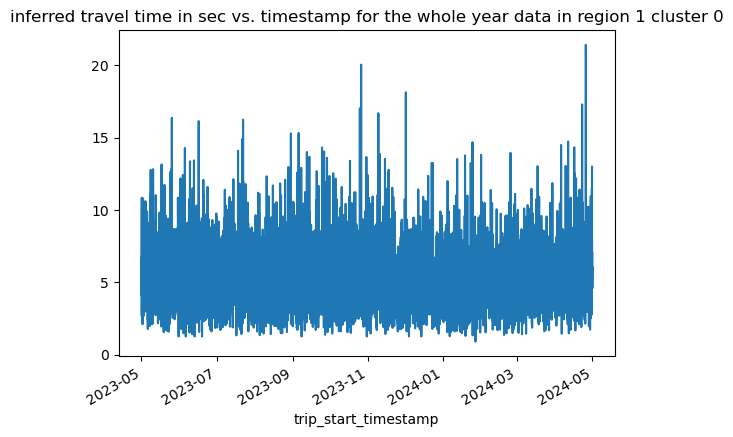

In [69]:
#check the plot of inferred_traveltime_sec_updated vs. timestamp for the whole data:
df['inferred_traveltime_sec_updated'].plot()
plt.title(f'inferred travel time in sec vs. timestamp for the whole year data in region {region} cluster {cluster}')

Text(0.5, 1.0, 'inferred travel time in sec vs. timestamp for a month data in region 1 cluster 0')

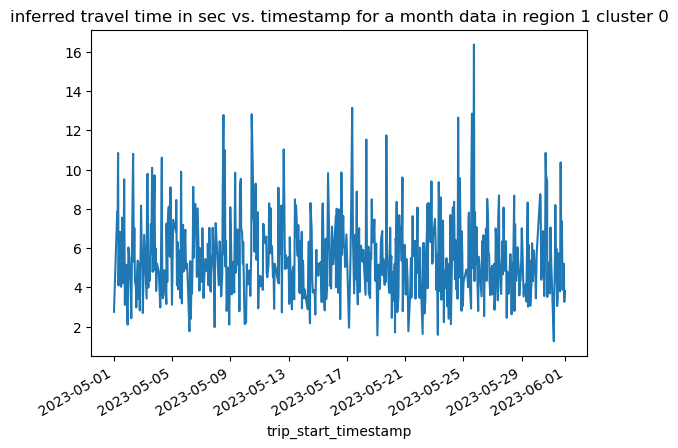

In [70]:
# check to see one month data by randomly picking one month
month_sample=5
df[df.index.month == month_sample]['inferred_traveltime_sec_updated'].plot()
plt.title(f'inferred travel time in sec vs. timestamp for a month data in region {region} cluster {cluster}')

Text(0.5, 1.0, 'inferred travel time in sec vs. timestamp for a week data in region 1 cluster 0')

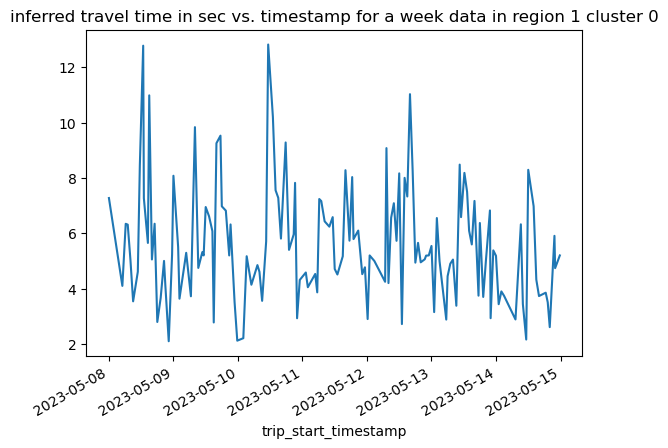

In [71]:
# check to see one week data by randomly picking one week
# Filter data for a specific week in May (e.g., May 8–14)
df["2023-05-08":"2023-05-14"]['inferred_traveltime_sec_updated'].plot()
plt.title(f'inferred travel time in sec vs. timestamp for a week data in region {region} cluster {cluster}')

Text(0.5, 1.0, 'inferred travel time in sec vs. timestamp for a day data in region 1 cluster 0')

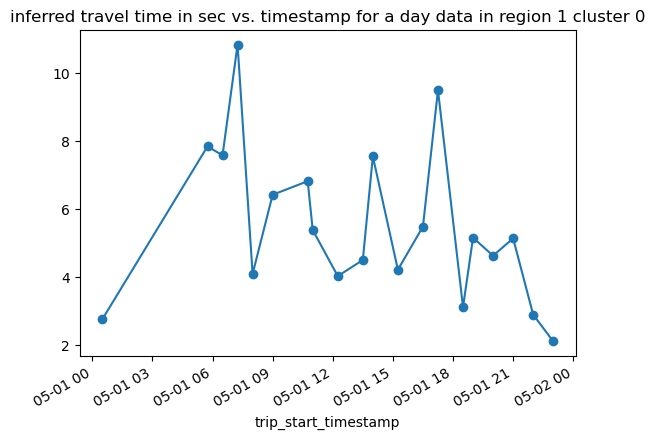

In [72]:
# check to see one day data by randomly picking one day
df['2023-05-01 00:00:00': '2023-05-01 23:00:00']['inferred_traveltime_sec_updated'].plot(marker='o')
plt.title(f'inferred travel time in sec vs. timestamp for a day data in region {region} cluster {cluster}')

Analysis:
- it seems the inferred_travel_time_sec shows a stable trend over time and appears a seasonal pattern with period of 24hours.

<Axes: xlabel='month'>

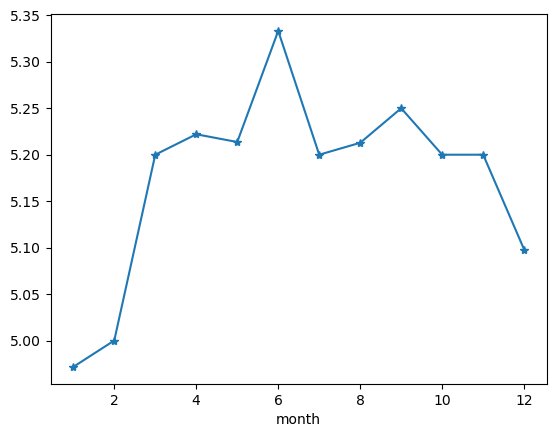

In [73]:
# check the aggregated inferred_traveltime_sec_updated vs. months
df.groupby('month')['inferred_traveltime_sec_updated'].median().plot(kind='line', marker='*')

<Axes: xlabel='dayname'>

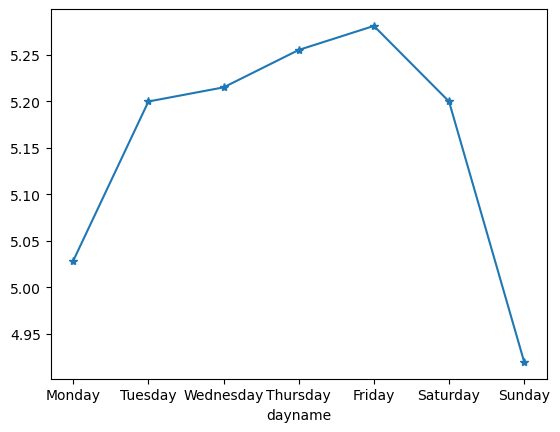

In [74]:
# check the aggregated inferred_traveltime_sec_updated vs. day of week
df.groupby('dayname')['inferred_traveltime_sec_updated'].median().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(kind='line', marker='*')

Text(0, 0.5, 'aggregated inferred time in sec')

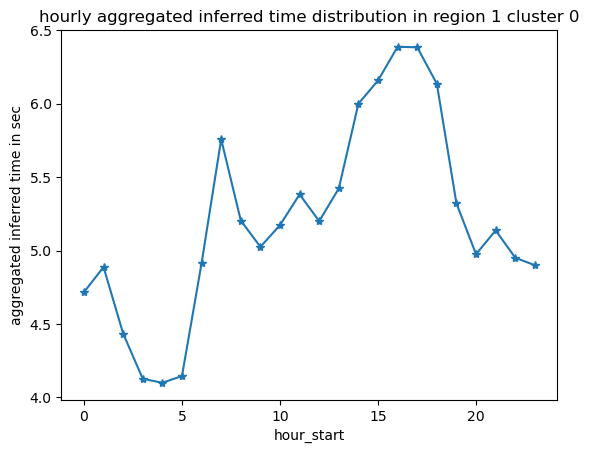

In [75]:
# check the aggregated inferred_traveltime_sec_updated vs. hours
df.groupby('hour_start')['inferred_traveltime_sec_updated'].median().plot(kind='line', marker='*')
plt.title(f'hourly aggregated inferred time distribution in region {region} cluster {cluster}')
plt.ylabel('aggregated inferred time in sec')

Analysis:
- although we can see some seasonal pattern of the inferred travel time by months and day of week, they are  insignificant by comparing with the pattern by hours.
- from the plot, we can divide a day into morning, afternoon, and night timeframes, and in each timeframe, there are two peak_hours as below:
morning=[6,7,8,9,10,11]
morning_peak=[7,8]
afternoon=[12,13,14,15,16,17]
afternoon_peak=[16, 17]
night=[18,19,20,21,22,23,0,1,2,3,4,5]
night_peak=[18,19]

In [76]:
# check the completeness of temporal information
#create a dataframe month_day_hour to display the temporal information by month, day, and hour.
month_day_hour=df.groupby(['month','day'])['hour_start'].count().reset_index()
for month in range(1, 13):
    num_days=len(month_day_hour[month_day_hour['month']==month])
    avg_num_hours=round(month_day_hour[month_day_hour['month']==month]['hour_start'].mean(),2)
    min_num_hours=month_day_hour[month_day_hour['month']==month]['hour_start'].min()
    print(f'month {month}, num_days: {num_days}, avg_num_hours: {avg_num_hours}, min_num_hours: {min_num_hours}')

month 1, num_days: 31, avg_num_hours: 20.55, min_num_hours: 16
month 2, num_days: 29, avg_num_hours: 20.69, min_num_hours: 18
month 3, num_days: 31, avg_num_hours: 20.87, min_num_hours: 17
month 4, num_days: 30, avg_num_hours: 19.9, min_num_hours: 17
month 5, num_days: 31, avg_num_hours: 20.06, min_num_hours: 17
month 6, num_days: 30, avg_num_hours: 20.37, min_num_hours: 16
month 7, num_days: 31, avg_num_hours: 19.68, min_num_hours: 16
month 8, num_days: 31, avg_num_hours: 19.87, min_num_hours: 15
month 9, num_days: 30, avg_num_hours: 21.1, min_num_hours: 17
month 10, num_days: 31, avg_num_hours: 20.52, min_num_hours: 17
month 11, num_days: 30, avg_num_hours: 20.77, min_num_hours: 18
month 12, num_days: 31, avg_num_hours: 21.0, min_num_hours: 17


Analysis:
- the hourly temporal data is incomplete (~90%). 
- we need to fill up the missing values first for an easier operation in the following (like to create the lag features)

#### 5.2.1 fill up missing hours

In [77]:
# generate a full range of hours for each day
full_hours = (
   df.groupby(['year', 'month', 'day'])['hour_start']
    .apply(lambda x: pd.Series(np.arange(24)))
    .reset_index(level=-1, drop=True)  # Drop the original hours index from apply
    .reset_index()
)
full_hours

year  month  day  hour_start
0     2023      5    1           0
1     2023      5    1           1
2     2023      5    1           2
3     2023      5    1           3
4     2023      5    1           4
...    ...    ...  ...         ...
8779  2024      4   30          19
8780  2024      4   30          20
8781  2024      4   30          21
8782  2024      4   30          22
8783  2024      4   30          23

[8784 rows x 4 columns]

In [78]:
# merge the full_hours with the original dataframe to find missing rows
df_fh = pd.merge(full_hours, df, on=['year', 'month', 'day', 'hour_start'], how='left')

In [79]:
# fill na for weather related features, use forward-fill or backward-fill directly
weather_features=['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'pres']
df_fh[weather_features]=df_fh[weather_features].ffill().bfill()

In [80]:
df_fh[weather_features].isnull().sum()

temp    0
dwpt    0
rhum    0
prcp    0
wdir    0
pres    0
dtype: int64

In [81]:
#create timeframe and peak_hours columns to indicate 
##which timeframe the current hour is from and whether it is peak hour
df_fh['timeframe']=df_fh['hour_start'].apply(
    lambda x: 'morning' if 6<=x<12 else 'afternoon' if 12<=x<18 else 'night')
df_fh['peak_hours']=df_fh['hour_start'].apply(lambda x: 1 if x in [7,8,16,17,18,19] else 0)

In [82]:
# fill na for inferred_traveltime_sec_updated based on peak_hours and non_peak_hours in different timeframes

# split into peak and non-peak sub datasets for each timeframe
morning_peak = df_fh[(df_fh['timeframe']=='morning') & (df_fh['peak_hours']==1)].copy()
morning_non_peak = df_fh[(df_fh['timeframe']=='morning') & (df_fh['peak_hours']==0)].copy()

afternoon_peak = df_fh[(df_fh['timeframe']=='afternoon') & (df_fh['peak_hours']==1)].copy()
afternoon_non_peak = df_fh[(df_fh['timeframe']=='afternoon') & (df_fh['peak_hours']==0)].copy()

night_peak = df_fh[(df_fh['timeframe']=='night') & (df_fh['peak_hours']==1)].copy()
night_non_peak = df_fh[(df_fh['timeframe']=='night') & (df_fh['peak_hours']==0)].copy()

# fill na of inferred_traveltime_sec_updated for peak hours
morning_peak['inferred_traveltime_sec_updated'] = morning_peak['inferred_traveltime_sec_updated'].ffill().bfill()
afternoon_peak['inferred_traveltime_sec_updated'] = afternoon_peak['inferred_traveltime_sec_updated'].ffill().bfill()
night_peak['inferred_traveltime_sec_updated'] = night_peak['inferred_traveltime_sec_updated'].ffill().bfill()

# fill na of inferred_traveltime_sec_updated for non-peak hours
morning_non_peak['inferred_traveltime_sec_updated'] = morning_non_peak['inferred_traveltime_sec_updated'].ffill().bfill()
afternoon_non_peak['inferred_traveltime_sec_updated'] = afternoon_non_peak['inferred_traveltime_sec_updated'].ffill().bfill()
night_non_peak['inferred_traveltime_sec_updated'] = night_non_peak['inferred_traveltime_sec_updated'].ffill().bfill()

# Combine the data
df_fh_filled = pd.concat([morning_peak, morning_non_peak, afternoon_peak, afternoon_non_peak, 
                          night_peak, night_non_peak]).sort_index()
df_fh_filled

year  month  day  hour_start  dayname  inferred_traveltime_sec_updated  \
0     2023      5    1           0   Monday                         2.750000   
1     2023      5    1           1      NaN                         2.750000   
2     2023      5    1           2      NaN                         2.750000   
3     2023      5    1           3      NaN                         2.750000   
4     2023      5    1           4      NaN                         2.750000   
...    ...    ...  ...         ...      ...                              ...   
8779  2024      4   30          19  Tuesday                         4.565143   
8780  2024      4   30          20  Tuesday                         5.100000   
8781  2024      4   30          21  Tuesday                         6.082825   
8782  2024      4   30          22  Tuesday                         4.585422   
8783  2024      4   30          23  Tuesday                         7.040816   

       temp  dwpt  rhum  prcp   wdir     pres timeframe  peak_hours  
0      6.10   2.2  76.0   0.4  290.0   997.00     night           0  
1      6.10   2.2  76.0   0.4  290.0   997.00     night           0  
2      6.10   2.2  76.0   0.4  290.0   997.00     night           0  
3      6.10   2.2  76.0   0.4  290.0   997.00     night           0  
4      6.10   2.2  76.0   0.4  290.0   997.00     night           0  
...     ...   ...   ...   ...    ...      ...       ...         ...  
8779  21.70   9.6  46.0   0.0  260.0  1013.00     night           1  
8780  21.70   9.6  46.0   0.0  260.0  1013.00     night           0  
8781  23.30  11.0  46.0   0.0  270.0  1011.50     night           0  
8782  23.35  10.9  45.5   0.0  185.0  1011.25     night           0  
8783  22.80  11.8  50.0   0.0  190.0  1010.00     night           0  

[8784 rows x 14 columns]

In [83]:
# fill na in 'dayname' column based on year, month, and day
df_fh_filled['dayname'] = (
    df_fh_filled.groupby(['year', 'month', 'day'])['dayname']
    .transform(lambda x: x.ffill().bfill())
)

In [84]:
df_fh_filled.isnull().sum()

year                               0
month                              0
day                                0
hour_start                         0
dayname                            0
inferred_traveltime_sec_updated    0
temp                               0
dwpt                               0
rhum                               0
prcp                               0
wdir                               0
pres                               0
timeframe                          0
peak_hours                         0
dtype: int64

#### 5.2.2 Generate lag and rolling features

In [85]:
# rename 'hour_start' to 'hour'
df_fh_filled = df_fh_filled.rename(columns={'hour_start': 'hour'})

# create a datetime index
df_fh_filled['datetime'] = pd.to_datetime(df_fh_filled[['year', 'month', 'day', 'hour']])

# set 'datetime' as the index
df_fh_filled = df_fh_filled.set_index('datetime')

# sort the dataframe by the new datetime index
df_fh_filled = df_fh_filled.sort_index()

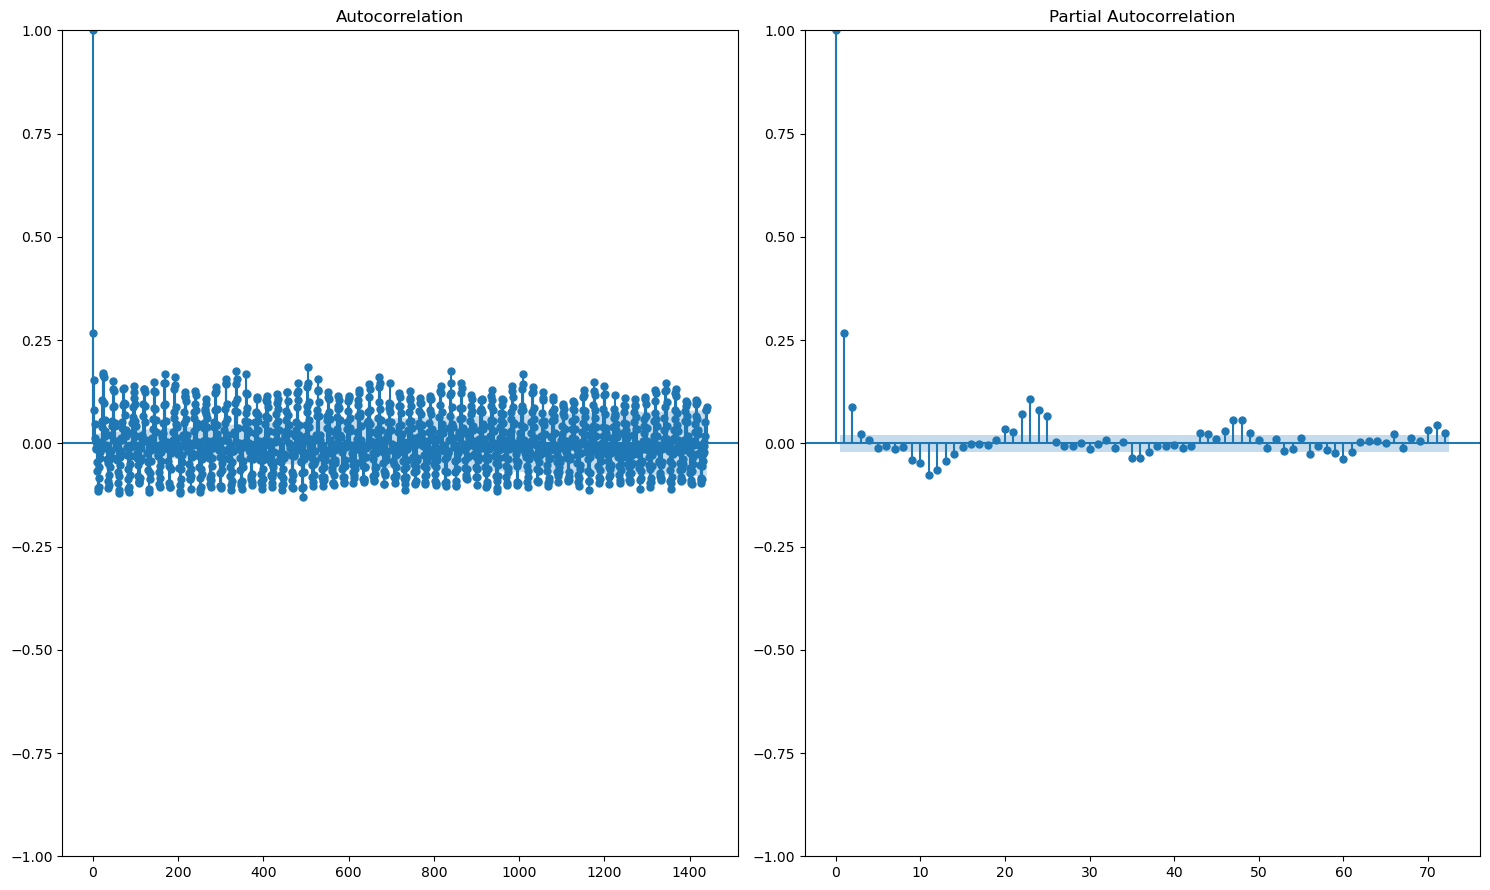

In [86]:
# create a time series data
timeseries = df_fh_filled['inferred_traveltime_sec_updated']

# plot ACF and PACF
plt.figure(figsize=(15, 9))

plt.subplot(121)
plot_acf(timeseries, lags=24*60, ax=plt.gca()) # create 60 days autocorrelation
plt.title('Autocorrelation')

plt.subplot(122)
plot_pacf(timeseries, lags=24*3, ax=plt.gca()) # create 3 days partial autocorrelation
plt.title('Partial Autocorrelation')

plt.tight_layout()
plt.show()

Analysis:
- from the ACF plot, it seems the rolling window of 1 month is good enough since we can clearly see the second month is close to the confidence interval band.
- from the PCF plot, it seems lag1, lag2,  lag23, lag24 are good options since all the others are close to the confidence interval band.

In [87]:
# Create lag features for inferred_traveltime_sec_updated
lags = [1, 2, 23, 24]
for lag in lags:
    df_fh_filled[f'lag_{lag}'] = df_fh_filled['inferred_traveltime_sec_updated'].shift(lag)
df_fh_filled

year  month  day  hour  dayname  \
datetime                                               
2023-05-01 00:00:00  2023      5    1     0   Monday   
2023-05-01 01:00:00  2023      5    1     1   Monday   
2023-05-01 02:00:00  2023      5    1     2   Monday   
2023-05-01 03:00:00  2023      5    1     3   Monday   
2023-05-01 04:00:00  2023      5    1     4   Monday   
...                   ...    ...  ...   ...      ...   
2024-04-30 19:00:00  2024      4   30    19  Tuesday   
2024-04-30 20:00:00  2024      4   30    20  Tuesday   
2024-04-30 21:00:00  2024      4   30    21  Tuesday   
2024-04-30 22:00:00  2024      4   30    22  Tuesday   
2024-04-30 23:00:00  2024      4   30    23  Tuesday   

                     inferred_traveltime_sec_updated   temp  dwpt  rhum  prcp  \
datetime                                                                        
2023-05-01 00:00:00                         2.750000   6.10   2.2  76.0   0.4   
2023-05-01 01:00:00                         2.750000   6.10   2.2  76.0   0.4   
2023-05-01 02:00:00                         2.750000   6.10   2.2  76.0   0.4   
2023-05-01 03:00:00                         2.750000   6.10   2.2  76.0   0.4   
2023-05-01 04:00:00                         2.750000   6.10   2.2  76.0   0.4   
...                                              ...    ...   ...   ...   ...   
2024-04-30 19:00:00                         4.565143  21.70   9.6  46.0   0.0   
2024-04-30 20:00:00                         5.100000  21.70   9.6  46.0   0.0   
2024-04-30 21:00:00                         6.082825  23.30  11.0  46.0   0.0   
2024-04-30 22:00:00                         4.585422  23.35  10.9  45.5   0.0   
2024-04-30 23:00:00                         7.040816  22.80  11.8  50.0   0.0   

                      wdir     pres timeframe  peak_hours     lag_1  \
datetime                                                              
2023-05-01 00:00:00  290.0   997.00     night           0       NaN   
2023-05-01 01:00:00  290.0   997.00     night           0  2.750000   
2023-05-01 02:00:00  290.0   997.00     night           0  2.750000   
2023-05-01 03:00:00  290.0   997.00     night           0  2.750000   
2023-05-01 04:00:00  290.0   997.00     night           0  2.750000   
...                    ...      ...       ...         ...       ...   
2024-04-30 19:00:00  260.0  1013.00     night           1  4.666244   
2024-04-30 20:00:00  260.0  1013.00     night           0  4.565143   
2024-04-30 21:00:00  270.0  1011.50     night           0  5.100000   
2024-04-30 22:00:00  185.0  1011.25     night           0  6.082825   
2024-04-30 23:00:00  190.0  1010.00     night           0  4.585422   

                         lag_2    lag_23    lag_24  
datetime                                            
2023-05-01 00:00:00        NaN       NaN       NaN  
2023-05-01 01:00:00        NaN       NaN       NaN  
2023-05-01 02:00:00   2.750000       NaN       NaN  
2023-05-01 03:00:00   2.750000       NaN       NaN  
2023-05-01 04:00:00   2.750000       NaN       NaN  
...                        ...       ...       ...  
2024-04-30 19:00:00  13.003847  2.405951  7.016443  
2024-04-30 20:00:00   4.666244  3.056724  2.405951  
2024-04-30 21:00:00   4.565143  5.046633  3.056724  
2024-04-30 22:00:00   5.100000  5.200000  5.046633  
2024-04-30 23:00:00   6.082825  4.100000  5.200000  

[8784 rows x 18 columns]

In [88]:
# define rolling windows in hours
windows = {'1w': 7*24, '1m': 30*24}  # Weekly, Monthly (in hours)

# create rolling median for each window, also the rolling window only includes the same hour as the current hour
for window_name, window_size in windows.items():
    # rolling median
    df_fh_filled[f'rolling_median_{window_name}'] = (
        df_fh_filled.groupby('hour')['inferred_traveltime_sec_updated']
        .transform(lambda x: x.rolling(window=window_size, min_periods=1).median())
    )
    
df_fh_filled

year  month  day  hour  dayname  \
datetime                                               
2023-05-01 00:00:00  2023      5    1     0   Monday   
2023-05-01 01:00:00  2023      5    1     1   Monday   
2023-05-01 02:00:00  2023      5    1     2   Monday   
2023-05-01 03:00:00  2023      5    1     3   Monday   
2023-05-01 04:00:00  2023      5    1     4   Monday   
...                   ...    ...  ...   ...      ...   
2024-04-30 19:00:00  2024      4   30    19  Tuesday   
2024-04-30 20:00:00  2024      4   30    20  Tuesday   
2024-04-30 21:00:00  2024      4   30    21  Tuesday   
2024-04-30 22:00:00  2024      4   30    22  Tuesday   
2024-04-30 23:00:00  2024      4   30    23  Tuesday   

                     inferred_traveltime_sec_updated   temp  dwpt  rhum  prcp  \
datetime                                                                        
2023-05-01 00:00:00                         2.750000   6.10   2.2  76.0   0.4   
2023-05-01 01:00:00                         2.750000   6.10   2.2  76.0   0.4   
2023-05-01 02:00:00                         2.750000   6.10   2.2  76.0   0.4   
2023-05-01 03:00:00                         2.750000   6.10   2.2  76.0   0.4   
2023-05-01 04:00:00                         2.750000   6.10   2.2  76.0   0.4   
...                                              ...    ...   ...   ...   ...   
2024-04-30 19:00:00                         4.565143  21.70   9.6  46.0   0.0   
2024-04-30 20:00:00                         5.100000  21.70   9.6  46.0   0.0   
2024-04-30 21:00:00                         6.082825  23.30  11.0  46.0   0.0   
2024-04-30 22:00:00                         4.585422  23.35  10.9  45.5   0.0   
2024-04-30 23:00:00                         7.040816  22.80  11.8  50.0   0.0   

                      wdir     pres timeframe  peak_hours     lag_1  \
datetime                                                              
2023-05-01 00:00:00  290.0   997.00     night           0       NaN   
2023-05-01 01:00:00  290.0   997.00     night           0  2.750000   
2023-05-01 02:00:00  290.0   997.00     night           0  2.750000   
2023-05-01 03:00:00  290.0   997.00     night           0  2.750000   
2023-05-01 04:00:00  290.0   997.00     night           0  2.750000   
...                    ...      ...       ...         ...       ...   
2024-04-30 19:00:00  260.0  1013.00     night           1  4.666244   
2024-04-30 20:00:00  260.0  1013.00     night           0  4.565143   
2024-04-30 21:00:00  270.0  1011.50     night           0  5.100000   
2024-04-30 22:00:00  185.0  1011.25     night           0  6.082825   
2024-04-30 23:00:00  190.0  1010.00     night           0  4.585422   

                         lag_2    lag_23    lag_24  rolling_median_1w  \
datetime                                                                
2023-05-01 00:00:00        NaN       NaN       NaN           2.750000   
2023-05-01 01:00:00        NaN       NaN       NaN           2.750000   
2023-05-01 02:00:00   2.750000       NaN       NaN           2.750000   
2023-05-01 03:00:00   2.750000       NaN       NaN           2.750000   
2023-05-01 04:00:00   2.750000       NaN       NaN           2.750000   
...                        ...       ...       ...                ...   
2024-04-30 19:00:00  13.003847  2.405951  7.016443           5.158685   
2024-04-30 20:00:00   4.666244  3.056724  2.405951           4.910171   
2024-04-30 21:00:00   4.565143  5.046633  3.056724           5.008694   
2024-04-30 22:00:00   5.100000  5.200000  5.046633           4.897351   
2024-04-30 23:00:00   6.082825  4.100000  5.200000           4.838769   

                     rolling_median_1m  
datetime                                
2023-05-01 00:00:00           2.750000  
2023-05-01 01:00:00           2.750000  
2023-05-01 02:00:00           2.750000  
2023-05-01 03:00:00           2.750000  
2023-05-01 04:00:00           2.750000  
...                                ...  
2024-04-30 19:00:00           5.3367

In [89]:
# since the number of rows with na values is insignificant, we just drop them directly 
df_fh_filled.dropna(inplace=True)
df_fh_filled

year  month  day  hour  dayname  \
datetime                                               
2023-05-02 00:00:00  2023      5    2     0  Tuesday   
2023-05-02 01:00:00  2023      5    2     1  Tuesday   
2023-05-02 02:00:00  2023      5    2     2  Tuesday   
2023-05-02 03:00:00  2023      5    2     3  Tuesday   
2023-05-02 04:00:00  2023      5    2     4  Tuesday   
...                   ...    ...  ...   ...      ...   
2024-04-30 19:00:00  2024      4   30    19  Tuesday   
2024-04-30 20:00:00  2024      4   30    20  Tuesday   
2024-04-30 21:00:00  2024      4   30    21  Tuesday   
2024-04-30 22:00:00  2024      4   30    22  Tuesday   
2024-04-30 23:00:00  2024      4   30    23  Tuesday   

                     inferred_traveltime_sec_updated   temp  dwpt  rhum  prcp  \
datetime                                                                        
2023-05-02 00:00:00                         6.029239   9.40   3.4  66.0   0.0   
2023-05-02 01:00:00                         6.029239   9.40   3.4  66.0   0.0   
2023-05-02 02:00:00                         5.434096   9.40   1.1  56.0   0.0   
2023-05-02 03:00:00                         4.100000   8.90   1.1  58.0   0.0   
2023-05-02 04:00:00                         4.100000   8.90   1.1  58.0   0.0   
...                                              ...    ...   ...   ...   ...   
2024-04-30 19:00:00                         4.565143  21.70   9.6  46.0   0.0   
2024-04-30 20:00:00                         5.100000  21.70   9.6  46.0   0.0   
2024-04-30 21:00:00                         6.082825  23.30  11.0  46.0   0.0   
2024-04-30 22:00:00                         4.585422  23.35  10.9  45.5   0.0   
2024-04-30 23:00:00                         7.040816  22.80  11.8  50.0   0.0   

                      wdir     pres timeframe  peak_hours     lag_1  \
datetime                                                              
2023-05-02 00:00:00  300.0   998.50     night           0  2.100000   
2023-05-02 01:00:00  300.0   998.50     night           0  6.029239   
2023-05-02 02:00:00  300.0   999.50     night           0  6.029239   
2023-05-02 03:00:00  300.0   999.50     night           0  5.434096   
2023-05-02 04:00:00  300.0   999.50     night           0  4.100000   
...                    ...      ...       ...         ...       ...   
2024-04-30 19:00:00  260.0  1013.00     night           1  4.666244   
2024-04-30 20:00:00  260.0  1013.00     night           0  4.565143   
2024-04-30 21:00:00  270.0  1011.50     night           0  5.100000   
2024-04-30 22:00:00  185.0  1011.25     night           0  6.082825   
2024-04-30 23:00:00  190.0  1010.00     night           0  4.585422   

                         lag_2    lag_23    lag_24  rolling_median_1w  \
datetime                                                                
2023-05-02 00:00:00   2.889487  2.750000  2.750000           4.389619   
2023-05-02 01:00:00   2.100000  2.750000  2.750000           4.389619   
2023-05-02 02:00:00   6.029239  2.750000  2.750000           4.092048   
2023-05-02 03:00:00   6.029239  2.750000  2.750000           3.425000   
2023-05-02 04:00:00   5.434096  7.844275  2.750000           3.425000   
...                        ...       ...       ...                ...   
2024-04-30 19:00:00  13.003847  2.405951  7.016443           5.158685   
2024-04-30 20:00:00   4.666244  3.056724  2.405951           4.910171   
2024-04-30 21:00:00   4.565143  5.046633  3.056724           5.008694   
2024-04-30 22:00:00   5.100000  5.200000  5.046633           4.897351   
2024-04-30 23:00:00   6.082825  4.100000  5.200000           4.838769   

                     rolling_median_1m  
datetime                                
2023-05-02 00:00:00           4.389619  
2023-05-02 01:00:00           4.389619  
2023-05-02 02:00:00           4.092048  
2023-05-02 03:00:00           3.425000  
2023-05-02 04:00:00           3.425000  
...                                ...  
2024-04-30 19:00:00           5.3367

#### 5.2.3 EDA on individual features and correlation between features

##### 5.2.3.1 Exploring single numerical features

In [90]:
df_fh_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2023-05-02 00:00:00 to 2024-04-30 23:00:00
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             8760 non-null   int64  
 1   month                            8760 non-null   int64  
 2   day                              8760 non-null   int32  
 3   hour                             8760 non-null   int32  
 4   dayname                          8760 non-null   object 
 5   inferred_traveltime_sec_updated  8760 non-null   float64
 6   temp                             8760 non-null   float64
 7   dwpt                             8760 non-null   float64
 8   rhum                             8760 non-null   float64
 9   prcp                             8760 non-null   float64
 10  wdir                             8760 non-null   float64
 11  pres                             8760 non-null

In [91]:
num_features=df_fh_filled.select_dtypes(['float64'])
num_features

inferred_traveltime_sec_updated   temp  dwpt  rhum  prcp  \
datetime                                                                        
2023-05-02 00:00:00                         6.029239   9.40   3.4  66.0   0.0   
2023-05-02 01:00:00                         6.029239   9.40   3.4  66.0   0.0   
2023-05-02 02:00:00                         5.434096   9.40   1.1  56.0   0.0   
2023-05-02 03:00:00                         4.100000   8.90   1.1  58.0   0.0   
2023-05-02 04:00:00                         4.100000   8.90   1.1  58.0   0.0   
...                                              ...    ...   ...   ...   ...   
2024-04-30 19:00:00                         4.565143  21.70   9.6  46.0   0.0   
2024-04-30 20:00:00                         5.100000  21.70   9.6  46.0   0.0   
2024-04-30 21:00:00                         6.082825  23.30  11.0  46.0   0.0   
2024-04-30 22:00:00                         4.585422  23.35  10.9  45.5   0.0   
2024-04-30 23:00:00                         7.040816  22.80  11.8  50.0   0.0   

                      wdir     pres     lag_1      lag_2    lag_23    lag_24  \
datetime                                                                       
2023-05-02 00:00:00  300.0   998.50  2.100000   2.889487  2.750000  2.750000   
2023-05-02 01:00:00  300.0   998.50  6.029239   2.100000  2.750000  2.750000   
2023-05-02 02:00:00  300.0   999.50  6.029239   6.029239  2.750000  2.750000   
2023-05-02 03:00:00  300.0   999.50  5.434096   6.029239  2.750000  2.750000   
2023-05-02 04:00:00  300.0   999.50  4.100000   5.434096  7.844275  2.750000   
...                    ...      ...       ...        ...       ...       ...   
2024-04-30 19:00:00  260.0  1013.00  4.666244  13.003847  2.405951  7.016443   
2024-04-30 20:00:00  260.0  1013.00  4.565143   4.666244  3.056724  2.405951   
2024-04-30 21:00:00  270.0  1011.50  5.100000   4.565143  5.046633  3.056724   
2024-04-30 22:00:00  185.0  1011.25  6.082825   5.100000  5.200000  5.046633   
2024-04-30 23:00:00  190.0  1010.00  4.585422   6.082825  4.100000  5.200000   

                     rolling_median_1w  rolling_median_1m  
datetime                                                   
2023-05-02 00:00:00           4.389619           4.389619  
2023-05-02 01:00:00           4.389619           4.389619  
2023-05-02 02:00:00           4.092048           4.092048  
2023-05-02 03:00:00           3.425000           3.425000  
2023-05-02 04:00:00           3.425000           3.425000  
...                                ...                ...  
2024-04-30 19:00:00           5.158685           5.336764  
2024-04-30 20:00:00           4.910171           4.945770  
2024-04-30 21:00:00           5.008694           5.100000  
2024-04-30 22:00:00           4.897351           4.986315  
2024-04-30 23:00:00           4.838769           4.900000  

[8760 rows x 13 columns]

array([[<Axes: title={'center': 'inferred_traveltime_sec_updated'}>,
        <Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'dwpt'}>,
        <Axes: title={'center': 'rhum'}>],
       [<Axes: title={'center': 'prcp'}>,
        <Axes: title={'center': 'wdir'}>,
        <Axes: title={'center': 'pres'}>,
        <Axes: title={'center': 'lag_1'}>],
       [<Axes: title={'center': 'lag_2'}>,
        <Axes: title={'center': 'lag_23'}>,
        <Axes: title={'center': 'lag_24'}>,
        <Axes: title={'center': 'rolling_median_1w'}>],
       [<Axes: title={'center': 'rolling_median_1m'}>, <Axes: >,
        <Axes: >, <Axes: >]], dtype=object)

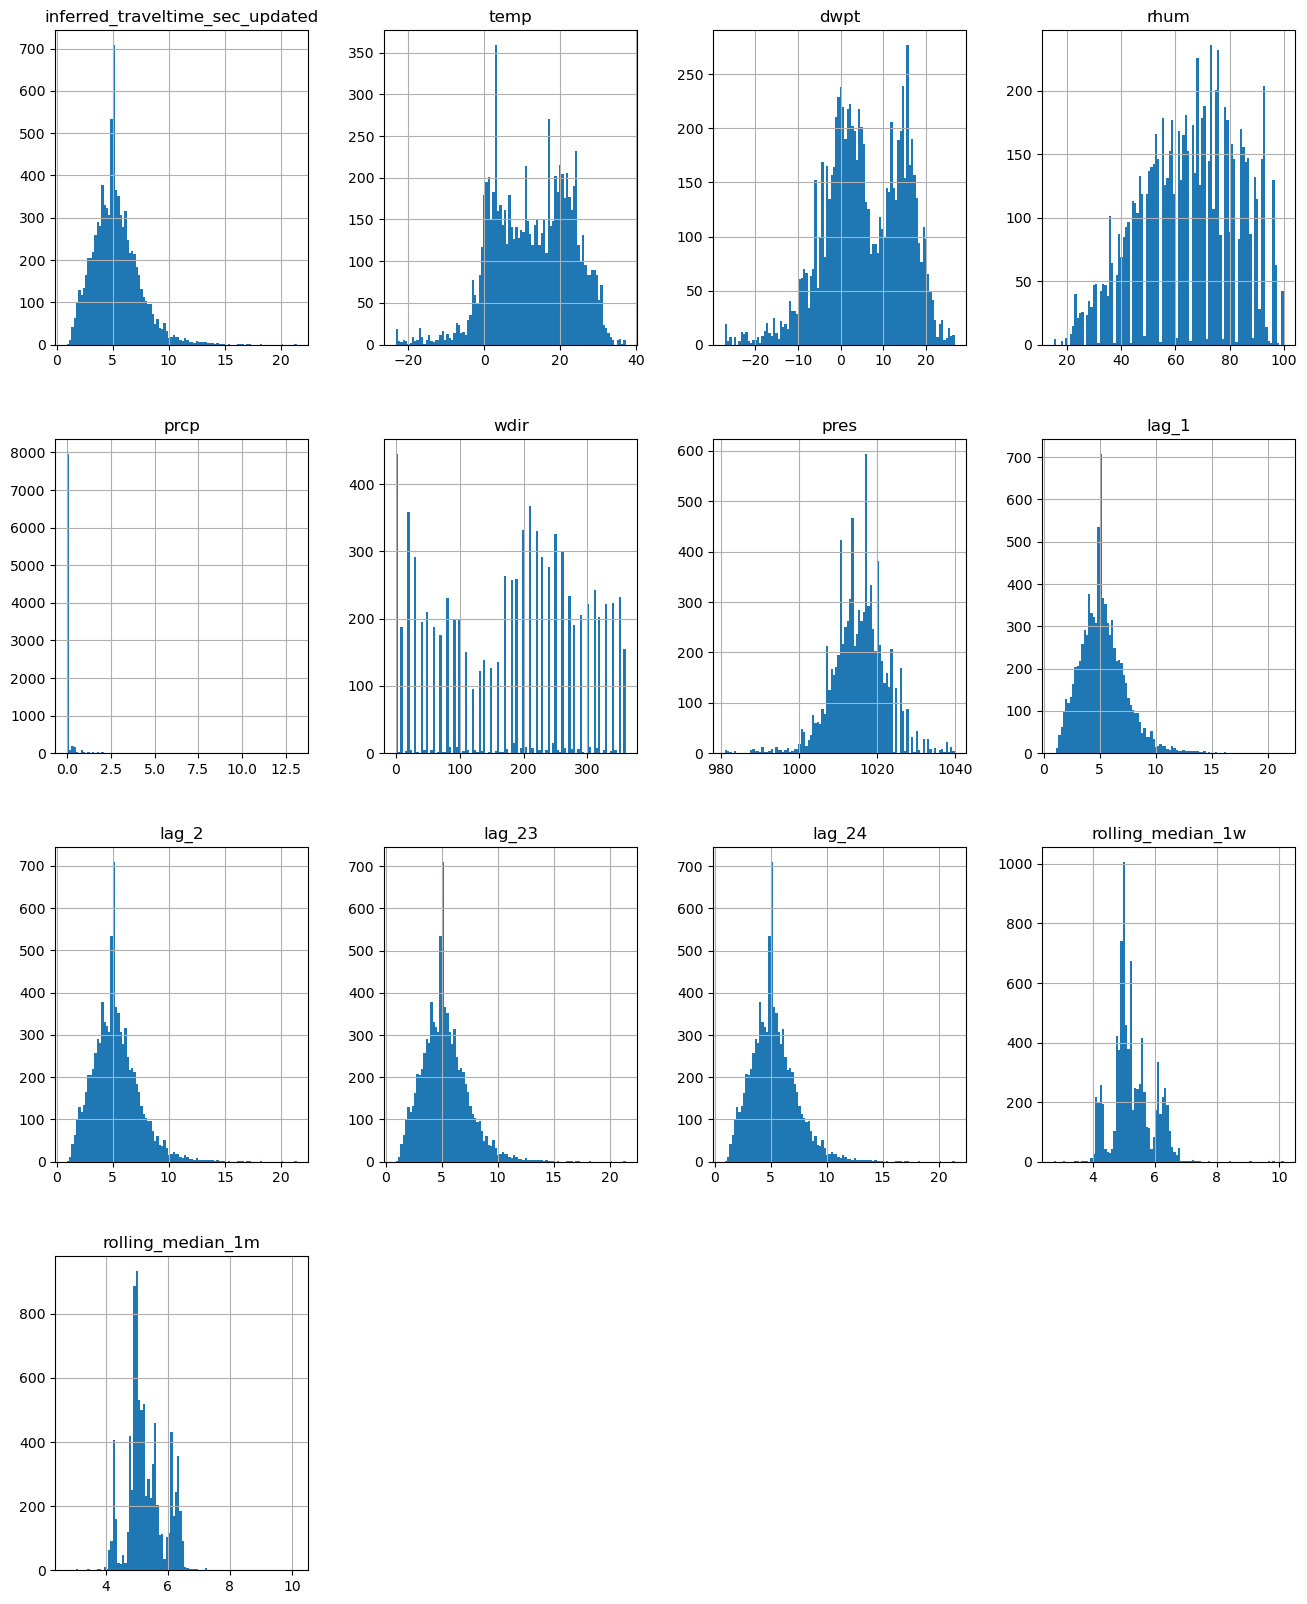

In [92]:
num_features.hist(figsize=(16, 20), bins=100)

In [93]:
# calculate the skewness for each feature
num_features.skew() 

inferred_traveltime_sec_updated     1.003389
temp                               -0.291385
dwpt                               -0.335869
rhum                               -0.230382
prcp                               11.130918
wdir                               -0.157384
pres                               -0.353823
lag_1                               1.003409
lag_2                               1.003292
lag_23                              1.001287
lag_24                              1.001105
rolling_median_1w                   0.476230
rolling_median_1m                   0.488952
dtype: float64

Analysis:
- it seems the prcp feature is highly skewed, followed by the inferred_traveltime_sec_updated and its lag features.
- all weather related features show clear seasonal pattern.
- rolling_median_1w and rolling_median_1m have very similar distribution, they might be duplicated.

##### 5.2.3.2 Exploring the correlation between features

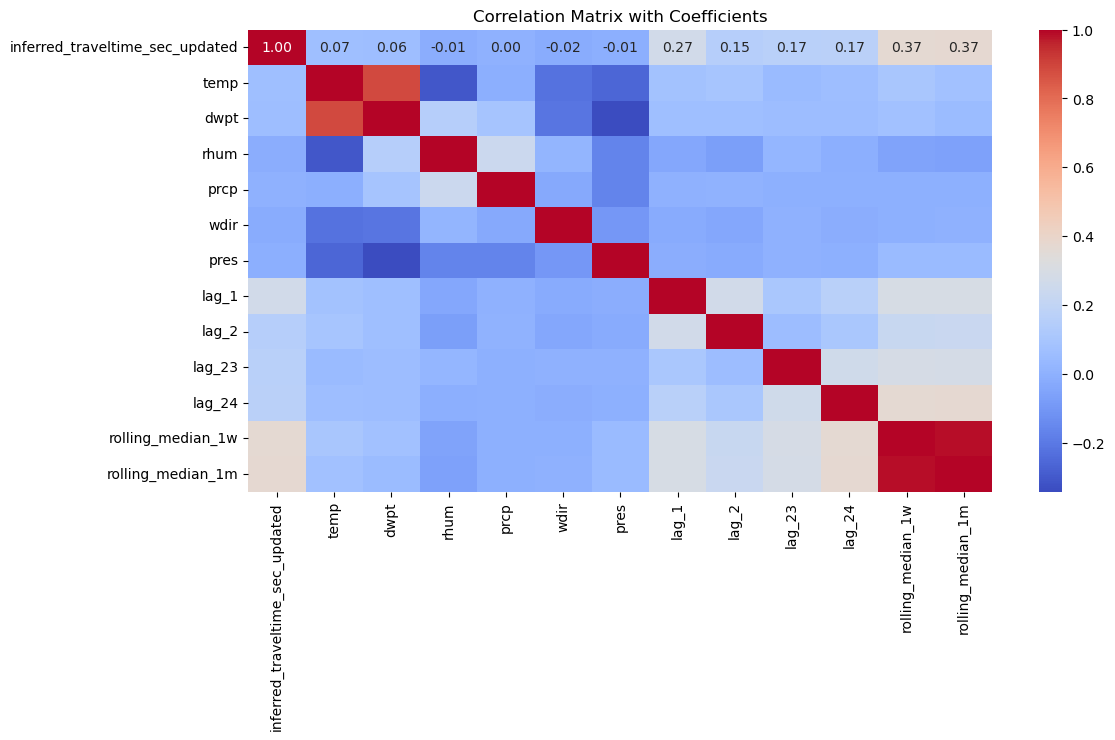

In [94]:
# calculate the correlation matrix
corr = num_features.corr()

# plot the heatmap with annotations
plt.figure(figsize=(12, 6))
sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True, 
    annot_kws={"size": 10} 
)
plt.title("Correlation Matrix with Coefficients")
plt.show()

C:\Users\cclin\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


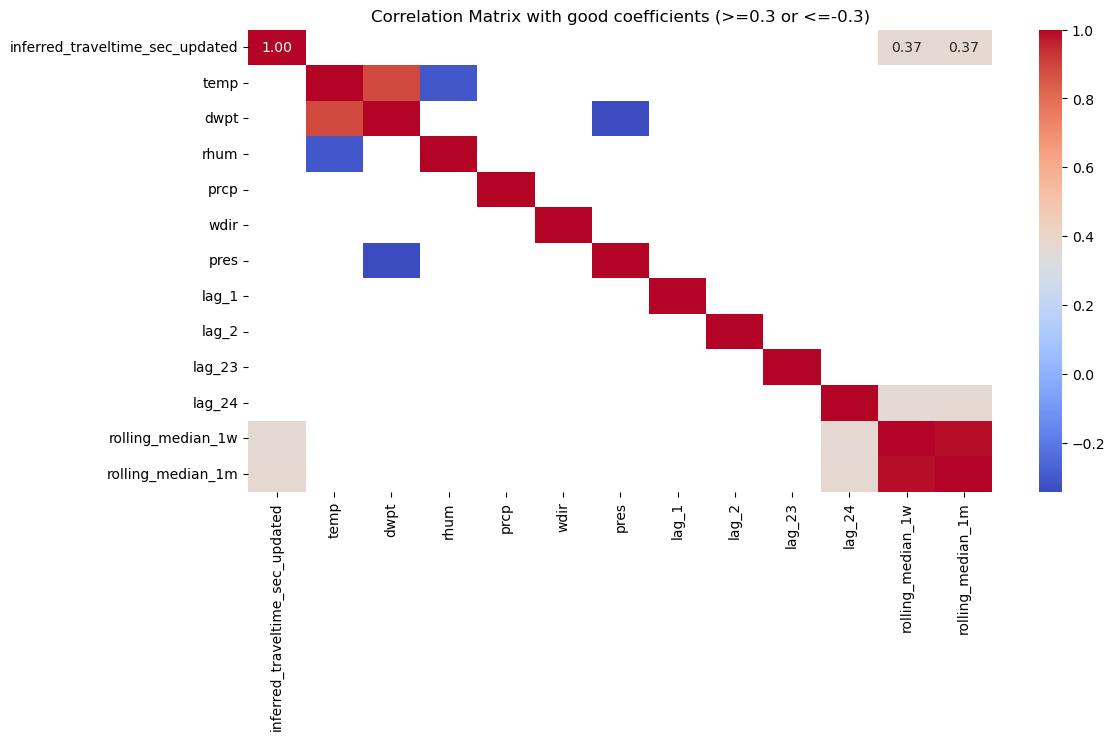

In [95]:
#For a better visualization, we need to do some filtering to only display the high correlation values: 
plt.figure(figsize=(12, 6))
sns.heatmap(
    corr[abs(corr)>=0.3], 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True, 
    annot_kws={"size": 10} 
)
plt.title("Correlation Matrix with good coefficients (>=0.3 or <=-0.3)")
plt.show()

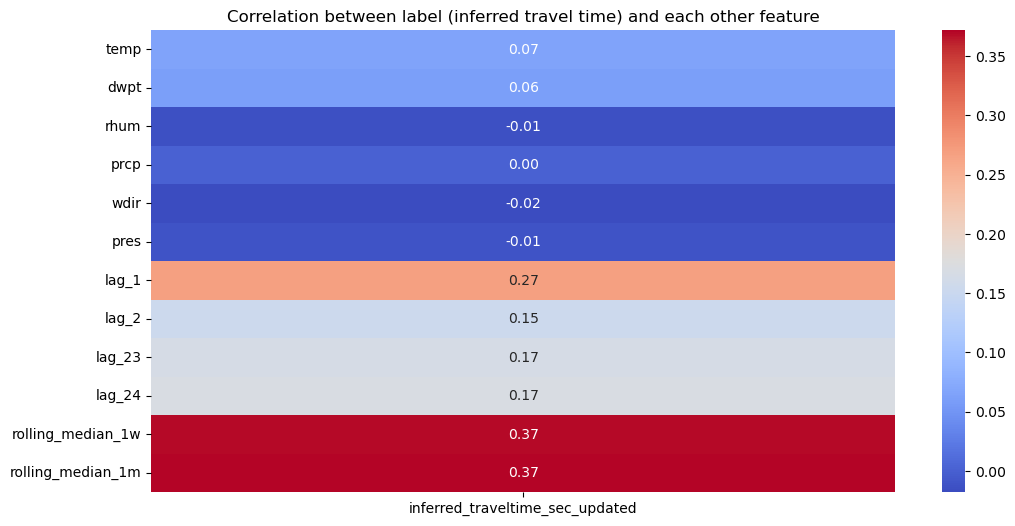

In [96]:
#if we want to see which features are highly correlated with the label, we can do: 
plt.figure(figsize=(12, 6))
sns.heatmap(
    corr[['inferred_traveltime_sec_updated']].iloc[1:], 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True, 
    annot_kws={"size": 10} 
)
plt.title("Correlation between label (inferred travel time) and each other feature")
plt.show()

Analysis: from all above heatmaps, it seems
- the inferred_traveltime_sec_updated has insignificant relationship with all weather related features.
- the inferred_traveltime_sec_updated has stronger linear relationship with rolling_median_1w and rolling_median_1m, following by lag_1 and lag_24, then followed by lag_2 and lag_23.
- there exists a very strong linear relationship between rolling_median_1w and rolling_median_1m (over 99%), we can consider dropping one of them to avoid duplication.
- temp and dwpt also have a strong linear relationship (over 88%), we can consider dropping one of them.

C:\Users\cclin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cclin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cclin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cclin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

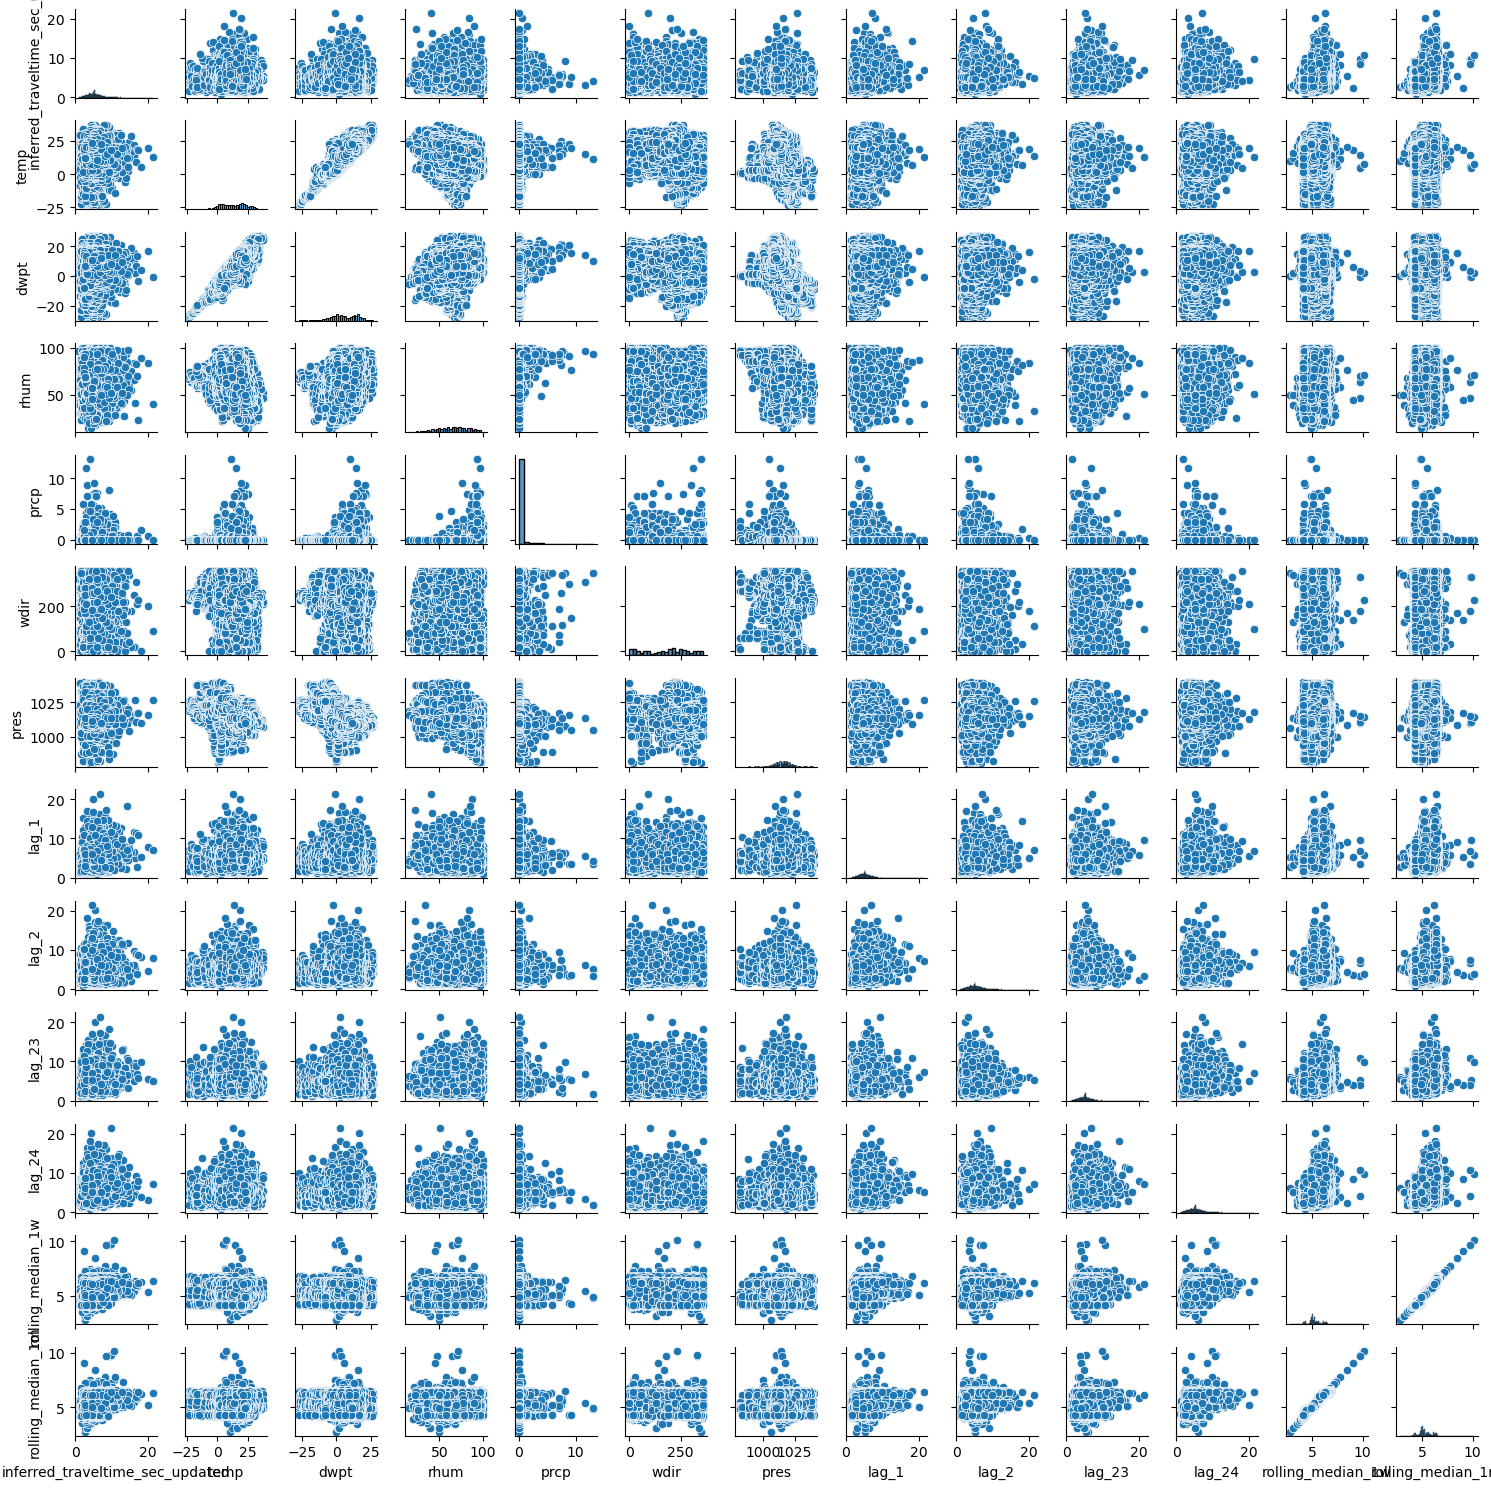

In [97]:
#check scatter plots between different features:
sns.pairplot(num_features, height=3, aspect=1.5) 
plt.gcf().set_size_inches(15, 15) 
plt.tight_layout() 
plt.show()

Analysis:
- clearly temp and dwpt, rolling_median_1w and rolling_medain_1m  are linearly correlated. 

In summary:
- we can drop rolling_median_1w while keepping rolling_median_1m (since rolling_median_1m has more data points to be aggregated).
- the features rolling_median_1m, lag_1, lag_24,  lag_2 and lag_23 showed relatively stronger linearly relationship with the target inferred travel time.
- temp and dwpt are highly correlated one of which can be dropped.
- all weather related feaures showed insignificant correlation with the target inferred travel time.

##### 5.2.3.3 Use Xgboost as the base model to do feature engneering

In [98]:
# create a new copy of the na filled dataframe from above and rename it as data
data=df_fh_filled.copy()

#from the above analysis, we can drop rolling_median_1w and temp due to the duplication.
data.drop(['rolling_median_1w', 'temp'], axis=1, inplace=True)

# drop features according to the feature importances analysis
##you can comment this line for the initial run to check the feature importances
#data.drop(['year', 'month', 'rhum',  'prcp', 'pres', 'peak_hours', 'lag_1', 'lag_2'], axis=1, inplace=True)

#convert the categorical features into 'category' dtype
data['dayname'] = data['dayname'].astype('category')
data['timeframe'] = data['timeframe'].astype('category')

# split data into features and label  
X = data.drop('inferred_traveltime_sec_updated', axis=1)
y = data['inferred_traveltime_sec_updated']

# Train-test split (85% train, 15% test), shuffle=False for time-series
X_trainfull, X_test, y_trainfull, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=False)
# train-validation split (85% train, 15% validation in trainfull)
X_train, X_val, y_train, y_val = train_test_split(X_trainfull, y_trainfull, test_size=0.15, random_state=42, shuffle=False)

In [99]:
# Initialize the model
## the following parameters were chose based on experiments that proved to work well
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.003,
    max_depth=4,
    enable_categorical=True,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = xgb_model.predict(X_val)

# Evaluate the model
mae=mean_absolute_error(y_val, y_val_pred)
me_ae=median_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}sec")
print(f"Median Abosolute Error: {me_ae:.2f}sec")
print(f'r2_score: {r2:.2f}')

Mean Absolute Error (MAE): 1.29sec
Median Abosolute Error: 1.07sec
r2_score: 0.17


Analysis:
- the MAE performance is pretty good.
- the r2_score isnt promising, however, this is likely due to the inherently low variance within each cluster. Since each cluster groups road segments with strong similarities in inferred travel time, much of the data variance has been effectively removed.

<Figure size 1000x800 with 0 Axes>

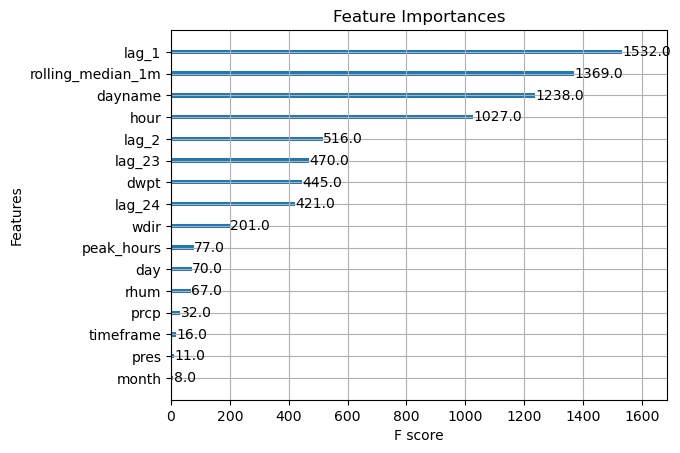

In [100]:
# Plot feature importances
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight')
plt.title("Feature Importances")
plt.show()

Analysis:
- rolling and lag features are more important.
- weather related features are insignificant except dwpt and wdir.
- even though lag_1, lag_2 are important, they are difficult for real-time implementation, we can consider dropping them to see whether it would affect the prediction performance largely.
- we can consider just keeping the following features and try again:
  - rolling_median_1m
  - dayname
  - hour
  - lag_24
  - lag_23
  - dwpt
  - timeframe
  - day
  - wdir

By repeating the above procedures for each cluster in region 1, we got the following results:
Regon 1:
- cluster 0: mean=6sec over all inferred travel time within the cluster
  - with original features (only dropped rolling_median_1w and temp):
    - Mean Absolute Error (MAE): 1.40sec
    - Median Abosolute Error: 1.15sec
    - r2_score: 0.18
  - after dropping ['year', 'month', 'rhum',  'pres', 'prcp', 'peak_hours'] features:
    - Mean Absolute Error (MAE): 1.40sec
    - Median Abosolute Error: 1.15sec
    - r2_score: 0.18
  - after further droping ['lag_1', 'lag_2'] which are difficult to implement in reality:
    - Mean Absolute Error (MAE): 1.42sec
    - Median Abosolute Error: 1.14sec
    - r2_score: 0.16
- cluster 1: mean=38sec over all inferred travel time within the cluster
  - with original features (only dropped rolling_median_1w and temp):
    - Mean Absolute Error (MAE): 4.71sec
    - Median Abosolute Error: 3.72sec
    - r2_score: 0.44
  - after ['year',  'rhum',  'pres', 'prcp', 'peak_hours', 'lag_1', 'lag_2' ] features removal:
    - Mean Absolute Error (MAE): 4.96sec
    - Median Abosolute Error: 4.07sec
    - r2_score: 0.41
- cluster 2: mean=16sec over all inferred travel time within the cluster
  - with original features (only dropped rolling_median_1w and temp):
    - Mean Absolute Error (MAE): 1.84sec
    - Median Abosolute Error: 1.49sec
    - r2_score: 0.49
  - after ['year',  'rhum',  'pres', 'prcp', 'peak_hours', 'lag_1', 'lag_2' ] features removal:
    - Mean Absolute Error (MAE): 1.85sec
    - Median Abosolute Error: 1.53sec
    - r2_score: 0.48
- **cluster 3 (with around 40% missing hours): mean=66sec over all inferred travel time within the cluster**
  - with original features (only dropped rolling_median_1w and temp):
    - Mean Absolute Error (MAE): 10.77sec
    - Median Abosolute Error: 8.24sec
    - r2_score: 0.37
  - after ['year',  'rhum',  'pres', 'prcp',  'lag_1', 'lag_2' ] features removal:
     - Mean Absolute Error (MAE): 11.90sec
    - Median Abosolute Error: 9.87sec
    - r2_score: 0.27
- cluster 4: mean=27sec
  - with original features (only dropped rolling_median_1w):
    - Mean Absolute Error (MAE): 3.50sec
    - Median Abosolute Error: 2.98sec
    - r2_score: 0.42
  - after ['year', 'month',  'rhum',  'prcp',  'lag_1', 'lag_2' ] features removal:
    - Mean Absolute Error (MAE): 3.60sec
    - Median Abosolute Error: 3.06sec
    - r2_score: 0.40

### 5.3 Machine Learning Modeling

#### 5.3.1 Xgboost model with Bayesian optimization (BayesSearchCV)

In [ ]:
# define time-series cross-validation
n_splits = 5  # number of splits for time-series CV
tscv = TimeSeriesSplit(n_splits=n_splits)

# define XGBoost model
xgb_model = xgb.XGBRegressor(enable_categorical=True, random_state=42)

# define hyperparameter search space
param_space = {
    'n_estimators': (100, 1000),  # Number of trees
    'learning_rate': (0.001, 0.1, 'log-uniform'),  # Learning rate
    'max_depth': (3, 10),  # Tree depth
    'subsample': (0.6, 1.0, 'uniform'),  # Fraction of samples
    'colsample_bytree': (0.6, 1.0, 'uniform')  # Fraction of features
}

# define custom scoring function (e.g., Mean Absolute Error)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# set up Bayesian optimization with cross-validation
opt = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_space,
    cv=tscv,
    n_iter=50,  # Number of iterations for optimization
    scoring=scorer,
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# fit the Bayesian optimization with the full training data
opt.fit(X_trainfull, y_trainfull)


In [ ]:
# retrieve the cross-validation results specifically for the best estimator
# index of the best estimator
best_index = opt.best_index_
# best hyperparameters and model
best_params = opt.best_params_
best_model = opt.best_estimator_

# results for the best estimator
best_mean_test_score = -opt.cv_results_['mean_test_score'][best_index]  # Negate to get positive MAE
best_std_test_score = opt.cv_results_['std_test_score'][best_index]

print("Best Parameters:", best_params)
print(f"Best Mean MAE: {best_mean_test_score:.2f} sec")
print(f"Best Std MAE: {best_std_test_score:.2f} sec")

Region 1:
- cluster 0:
Best Mean MAE: 1.52 sec
Best Std MAE: 0.08 sec
- cluster 1:
Best Mean MAE: 4.87 sec
Best Std MAE: 0.18 sec
- cluster 2:
Best Mean MAE: 1.98 sec
Best Std MAE: 0.10 sec
- **cluster 3 (more missing hours)**:
Best Mean MAE: 12.32 sec
Best Std MAE: 0.80 sec
- cluster 4:
Best Mean MAE: 3.63 sec
Best Std MAE: 0.12 sec

In [ ]:
# Save the best estimator to a file
joblib.dump(best_model, f'best_xgb_model_region{region}_cluster{cluster}.pkl')
# Load the model back when needed
#loaded_model = joblib.load('best_xgb_model_region1_cluster0.pkl')


In [ ]:
# Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_test_pred)
me_ae = median_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} sec")
print(f"Median Absolute Error: {me_ae:.2f} sec")
print(f"R2 Score: {r2:.2f}")

#### 5.3.2 Prophet model

The Prophet model is preferable for several reasons:
- Automatic Seasonal Pattern Extraction: It can automatically identify and extract seasonal temporal patterns, eliminating the need to manually create lag and rolling features that capture the 24-hour seasonal cycle.
- Built-in Handling of Missing Hours: The model can internally manage missing hours, provided the data has a uniform hourly spacing. This removes the need for manual imputation of missing hours.
- Minimal External Regressor Requirement: Only a few external regressors, such as weather-related features and an hour feature indicating peak and non-peak hours, need to be added. These are beyond the model's natural ability to extract patterns.

In [101]:
# use df here because prophet can automatically handel the missing hours,
## so that we dont have to use data which is with manual na filled
df=filtered_cluster_updatedbyhour.copy()
df.head()

year  month  day  hour_start dayname  \
trip_start_timestamp                                         
2023-05-01 00:30:00   2023      5    1           0  Monday   
2023-05-01 05:45:00   2023      5    1           5  Monday   
2023-05-01 06:30:00   2023      5    1           6  Monday   
2023-05-01 07:15:00   2023      5    1           7  Monday   
2023-05-01 08:00:00   2023      5    1           8  Monday   

                      inferred_traveltime_sec_updated  temp  dwpt  rhum  prcp  \
trip_start_timestamp                                                            
2023-05-01 00:30:00                          2.750000   6.1   2.2  76.0   0.4   
2023-05-01 05:45:00                          7.844275   5.6   1.7  76.0   0.0   
2023-05-01 06:30:00                          7.582883   5.6   1.1  73.0   0.0   
2023-05-01 07:15:00                         10.843412   5.6   1.1  73.0   0.0   
2023-05-01 08:00:00                          4.087558   5.0   1.7  79.0   0.0   

                       wdir   pres  
trip_start_timestamp                
2023-05-01 00:30:00   290.0  997.0  
2023-05-01 05:45:00   310.0  997.0  
2023-05-01 06:30:00   310.0  996.5  
2023-05-01 07:15:00   290.0  996.5  
2023-05-01 08:00:00   300.0  996.0

In [102]:
# drop insignifant features and make uniform hourly spacing
df_up=df.drop(['year', 'month', 'day', 'dayname', 'temp', 'rhum', 'prcp', 'pres'], axis=1)
df_hourly = df_up.reset_index().resample('h', on='trip_start_timestamp').mean().reset_index()

df_hourly

trip_start_timestamp  hour_start  inferred_traveltime_sec_updated  dwpt  \
0     2023-05-01 00:00:00         0.0                         2.750000   2.2   
1     2023-05-01 01:00:00         NaN                              NaN   NaN   
2     2023-05-01 02:00:00         NaN                              NaN   NaN   
3     2023-05-01 03:00:00         NaN                              NaN   NaN   
4     2023-05-01 04:00:00         NaN                              NaN   NaN   
...                   ...         ...                              ...   ...   
8779  2024-04-30 19:00:00        19.0                         4.565143   9.6   
8780  2024-04-30 20:00:00        20.0                         5.100000   9.6   
8781  2024-04-30 21:00:00        21.0                         6.082825  11.0   
8782  2024-04-30 22:00:00        22.0                         4.585422  10.9   
8783  2024-04-30 23:00:00        23.0                         7.040816  11.8   

       wdir  
0     290.0  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
8779  260.0  
8780  260.0  
8781  270.0  
8782  185.0  
8783  190.0  

[8784 rows x 5 columns]

In [103]:
# drop na after resampling
df_hourly.dropna(inplace=True)
df_cp=df_hourly.copy()
df_cp

trip_start_timestamp  hour_start  inferred_traveltime_sec_updated  dwpt  \
0     2023-05-01 00:00:00         0.0                         2.750000   2.2   
5     2023-05-01 05:00:00         5.0                         7.844275   1.7   
6     2023-05-01 06:00:00         6.0                         7.582883   1.1   
7     2023-05-01 07:00:00         7.0                        10.843412   1.1   
8     2023-05-01 08:00:00         8.0                         4.087558   1.7   
...                   ...         ...                              ...   ...   
8779  2024-04-30 19:00:00        19.0                         4.565143   9.6   
8780  2024-04-30 20:00:00        20.0                         5.100000   9.6   
8781  2024-04-30 21:00:00        21.0                         6.082825  11.0   
8782  2024-04-30 22:00:00        22.0                         4.585422  10.9   
8783  2024-04-30 23:00:00        23.0                         7.040816  11.8   

       wdir  
0     290.0  
5     310.0  
6     310.0  
7     290.0  
8     300.0  
...     ...  
8779  260.0  
8780  260.0  
8781  270.0  
8782  185.0  
8783  190.0  

[7483 rows x 5 columns]

In [104]:
# prepare data for Prophet
df_prophet = df_cp.rename(columns={'trip_start_timestamp': 'ds', 'inferred_traveltime_sec_updated': 'y'})
df_prophet

ds  hour_start          y  dwpt   wdir
0    2023-05-01 00:00:00         0.0   2.750000   2.2  290.0
5    2023-05-01 05:00:00         5.0   7.844275   1.7  310.0
6    2023-05-01 06:00:00         6.0   7.582883   1.1  310.0
7    2023-05-01 07:00:00         7.0  10.843412   1.1  290.0
8    2023-05-01 08:00:00         8.0   4.087558   1.7  300.0
...                  ...         ...        ...   ...    ...
8779 2024-04-30 19:00:00        19.0   4.565143   9.6  260.0
8780 2024-04-30 20:00:00        20.0   5.100000   9.6  260.0
8781 2024-04-30 21:00:00        21.0   6.082825  11.0  270.0
8782 2024-04-30 22:00:00        22.0   4.585422  10.9  185.0
8783 2024-04-30 23:00:00        23.0   7.040816  11.8  190.0

[7483 rows x 5 columns]

In [105]:
# select the external regressors 
regressors = ['dwpt', 'wdir', 'hour_start']

# scale the external regressors
# initialize the scaler
scaler = StandardScaler()

# fit and transform the regressors
scaled_regressors = scaler.fit_transform(df_prophet[regressors])

# add scaled regressors back to the dataframe
df_prophet[['dwpt_scaled', 'wdir_scaled', 'hour_scaled']] = scaled_regressors

#drop useless columns
df_prophet.drop(['hour_start', 'dwpt',  'wdir'], axis=1, inplace=True)
df_prophet

ds          y  dwpt_scaled  wdir_scaled  hour_scaled
0    2023-05-01 00:00:00   2.750000    -0.344640     1.006885    -1.868524
5    2023-05-01 05:00:00   7.844275    -0.398041     1.191188    -1.113523
6    2023-05-01 06:00:00   7.582883    -0.462122     1.191188    -0.962523
7    2023-05-01 07:00:00  10.843412    -0.462122     1.006885    -0.811523
8    2023-05-01 08:00:00   4.087558    -0.398041     1.099036    -0.660522
...                  ...        ...          ...          ...          ...
8779 2024-04-30 19:00:00   4.565143     0.445690     0.730431     1.000480
8780 2024-04-30 20:00:00   5.100000     0.445690     0.730431     1.151480
8781 2024-04-30 21:00:00   6.082825     0.595212     0.822582     1.302480
8782 2024-04-30 22:00:00   4.585422     0.584531     0.039295     1.453480
8783 2024-04-30 23:00:00   7.040816     0.680653     0.085371     1.604480

[7483 rows x 5 columns]

In [106]:
# ensure the dataframe is ordered by ascending on datetime  
df_prophet = df_prophet.sort_values(by=['ds'])

# split data into train and test subsets
# define the split point
split_point = '2024-02-17 00:00:00'  # 80% for training, 20% for testing

# Training and test datasets
test = df_prophet[df_prophet['ds']>=split_point]
train = df_prophet[df_prophet['ds']<split_point]

In [ ]:
train

In [ ]:
test

In [ ]:
len(test)/len(df_prophet)

In [107]:
# perform cross-validation

# initialize Prophet model
model = Prophet()

# add scaled external regressors
model.add_regressor('dwpt_scaled')
model.add_regressor('wdir_scaled')
model.add_regressor('hour_scaled')

# fit the model to the full training dataset
model.fit(train)  # for prophet objects initialization

# perform cross-validation
prophet_cv = cross_validation(
    model=model,
    initial='150 days',  # initial training period
    period='30 days',    # spacing between splits
    horizon='7 days'    # forecast horizon for test sets
)

# view the cross-validation results
prophet_cv

19:13:24 - cmdstanpy - INFO - Chain [1] start processing
19:13:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

19:13:25 - cmdstanpy - INFO - Chain [1] start processing
19:13:25 - cmdstanpy - INFO - Chain [1] done processing
19:13:25 - cmdstanpy - INFO - Chain [1] start processing
19:13:25 - cmdstanpy - INFO - Chain [1] done processing
19:13:26 - cmdstanpy - INFO - Chain [1] start processing
19:13:26 - cmdstanpy - INFO - Chain [1] done processing
19:13:26 - cmdstanpy - INFO - Chain [1] start processing
19:13:27 - cmdstanpy - INFO - Chain [1] done processing
19:13:27 - cmdstanpy - INFO - Chain [1] start processing
19:13:28 - cmdstanpy - INFO - Chain [1] done processing


ds      yhat  yhat_lower  yhat_upper         y  \
0   2023-10-13 00:00:00  4.898589    2.589466    7.485116  6.857107   
1   2023-10-13 02:00:00  4.545153    1.931523    6.985013  4.398185   
2   2023-10-13 05:00:00  4.872411    2.347012    7.373886  3.826101   
3   2023-10-13 07:00:00  5.980112    3.417924    8.469230  8.107699   
4   2023-10-13 08:00:00  6.116650    3.434281    8.441810  5.651397   
..                  ...       ...         ...         ...       ...   
721 2024-02-16 19:00:00  5.426687    2.881526    7.874821  4.506734   
722 2024-02-16 20:00:00  4.898545    2.563000    7.423348  4.813722   
723 2024-02-16 21:00:00  4.586345    2.217067    7.062248  3.390266   
724 2024-02-16 22:00:00  4.575339    2.274689    7.035407  4.523390   
725 2024-02-16 23:00:00  4.752401    2.583740    7.245831  5.570779   

                 cutoff  
0   2023-10-12 23:00:00  
1   2023-10-12 23:00:00  
2   2023-10-12 23:00:00  
3   2023-10-12 23:00:00  
4   2023-10-12 23:00:00  
..                  ...  
721 2024-02-09 23:00:00  
722 2024-02-09 23:00:00  
723 2024-02-09 23:00:00  
724 2024-02-09 23:00:00  
725 2024-02-09 23:00:00  

[726 rows x 6 columns]

In [108]:
# set the display option to show all rows
#pd.set_option('display.max_rows', None)
# get performance metrics
prophet_performance = performance_metrics(prophet_cv)
prophet_performance

horizon       mse      rmse       mae      mape     mdape  \
0   0 days 18:00:00  2.566118  1.601911  1.305557  0.292949  0.214816   
1   0 days 19:00:00  2.806796  1.675349  1.361246  0.302565  0.220969   
2   0 days 20:00:00  2.875544  1.695743  1.386597  0.306360  0.226090   
3   0 days 21:00:00  2.968775  1.723013  1.402922  0.301510  0.220969   
4   0 days 22:00:00  2.991674  1.729646  1.415214  0.311351  0.220969   
..              ...       ...       ...       ...       ...       ...   
146 6 days 20:00:00  2.894690  1.701379  1.432508  0.319805  0.218119   
147 6 days 21:00:00  2.873949  1.695272  1.409303  0.305502  0.217266   
148 6 days 22:00:00  2.649133  1.627616  1.351185  0.271303  0.205009   
149 6 days 23:00:00  2.469585  1.571491  1.308483  0.256717  0.202312   
150 7 days 00:00:00  2.416376  1.554470  1.292090  0.258978  0.198514   

        smape  coverage  
0    0.252744  0.936111  
1    0.259275  0.916667  
2    0.261929  0.902778  
3    0.259896  0.888889  
4    0.265817  0.891667  
..        ...       ...  
146  0.269496  0.861111  
147  0.259650  0.861111  
148  0.241721  0.883333  
149  0.233302  0.900000  
150  0.233707  0.902778  

[151 rows x 8 columns]

In [109]:
prophet_performance.set_index('horizon').describe().drop('count')

mse      rmse       mae      mape     mdape     smape  coverage
mean  3.379181  1.828030  1.422501  0.344218  0.222728  0.282199  0.850189
std   0.730309  0.194260  0.151447  0.039902  0.031037  0.026296  0.048769
min   2.095971  1.447747  1.186679  0.256717  0.172826  0.227775  0.722222
25%   2.855895  1.689939  1.309922  0.312902  0.198489  0.263123  0.820833
50%   3.002251  1.732700  1.386597  0.340649  0.216255  0.276774  0.861111
75%   3.826856  1.956235  1.484045  0.371153  0.255217  0.301728  0.888889
max   4.935238  2.221540  1.815321  0.433496  0.284386  0.342353  0.947222

Text(0, 0.5, 'MAE (sec)')

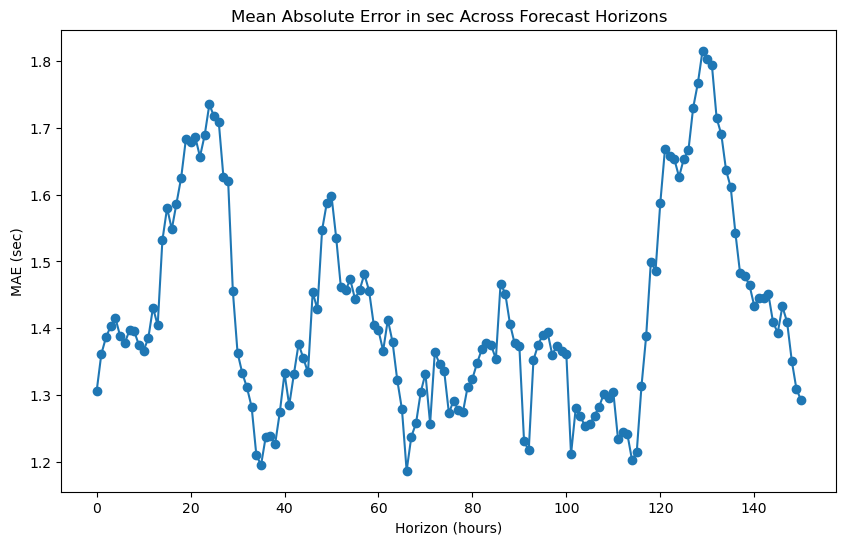

In [110]:
# plot MAE over horizons
plt.figure(figsize=(10, 6))
prophet_performance['mae'].plot(marker='o')
plt.title('Mean Absolute Error in sec Across Forecast Horizons')
plt.xlabel('Horizon (hours)')
plt.ylabel('MAE (sec)')

Text(0, 0.5, 'inferred_traveltime_sec_updated')

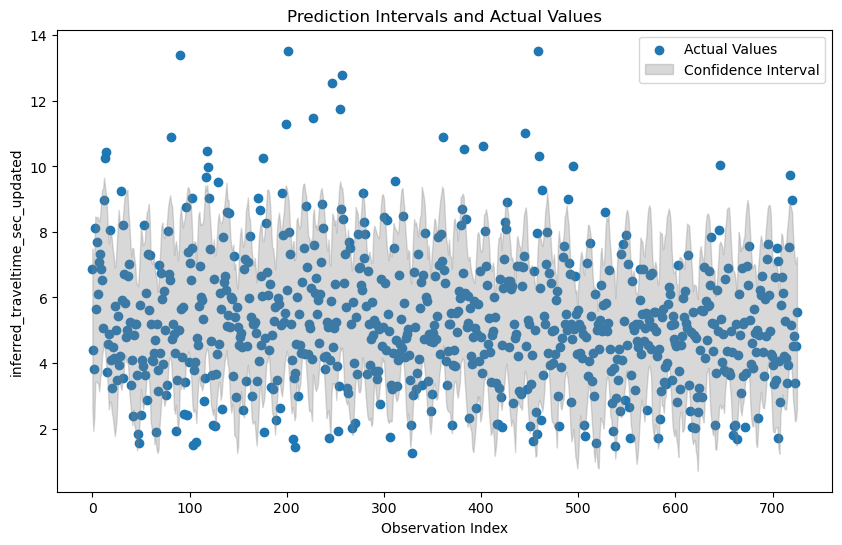

In [111]:
# plot the actual values and prediction intervals
plt.figure(figsize=(10, 6))
plt.scatter(prophet_cv.index, prophet_cv['y'], label='Actual Values', marker='o')
plt.fill_between(prophet_cv.index, prophet_cv['yhat_lower'], prophet_cv['yhat_upper'], color='gray', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.title('Prediction Intervals and Actual Values')
plt.xlabel('Observation Index')
plt.ylabel('inferred_traveltime_sec_updated')

In [112]:
# refit the model on the entire training dataset:
final_model = Prophet()
final_model.fit(train)

# predict on the test dataset:
future = test
forecast = final_model.predict(future)

19:14:00 - cmdstanpy - INFO - Chain [1] start processing
19:14:01 - cmdstanpy - INFO - Chain [1] done processing


In [113]:
test_merge=pd.merge(test, forecast[['ds', 'yhat']], on=['ds']) 
# evaluate the model
mae=mean_absolute_error(test_merge['y'], test_merge['yhat'])
r2 = r2_score(test_merge['y'], test_merge['yhat'])

print(f"Mean Absolute Error (MAE): {mae:.2f}sec")
print(f'r2_score: {r2:.2f}')

Mean Absolute Error (MAE): 1.49sec
r2_score: 0.04


In [ ]:
# create the dictionary test_regions_clusters is to save the test prediction results from all clusters for the following analysis
test_regions_clusters={}

In [ ]:
# save the prediction results from each cluster within each region to the dictionary
test_regions_clusters[f'region_{region}_cluster_{cluster}']=test_merge

In [ ]:
# Save the dictionary for each region to a file
joblib.dump(test_regions_clusters, f'test_region{region}_clusters.pkl')

## **Model Comparison: Prophet vs. XGBoost for Region 1**

| **Cluster**   | **Prophet MAE** | **Prophet STD** | **XGBoost Best MAE** | **XGBoost Std of Best MAE** |
|---------------|-----------------|-----------------|---------------------------|--------------------------|
| **Cluster 0** | 1.52 sec        | 0.14 sec        | 1.52 sec                  | 0.08 sec                 |
| **Cluster 1** | 5.09 sec        | 0.71 sec        | 4.87 sec                  | 0.18 sec                 |
| **Cluster 2** | 2.13 sec        | 0.21 sec        | 1.98 sec                  | 0.10 sec                 |
| **Cluster 3** | **13.30 sec**   | **2.00 sec**    | **12.32 sec**             | **0.80 sec**             |
| **Cluster 4** | 3.71 sec        | 0.39 sec        | 3.63 sec                  | 0.12 sec                 |


### 5.4 Use the prediction results to do route optimization and compare the results with that based on the inferred travel time

#### 5.4.1 Merge the prediction results for each cluster to the original regional dataset

In [114]:
# select a specific regional dataset to be merged with the prediction results
region=1
region_withcluster=pd.read_csv(f'region_{region}_withcluster.csv')

In [115]:
# prepare data for merging

# add 'day' column
region_withcluster['trip_start_timestamp']=pd.to_datetime(region_withcluster['trip_start_timestamp'])
region_withcluster['day']=region_withcluster['trip_start_timestamp'].dt.day

# add 'datetime' column that has a uniform hourly spacing so as to merge with the prediction results that with uniform hourly spacing
region_withcluster.rename(columns={'hour_start': 'hour'}, inplace=True)
region_withcluster['datetime']=pd.to_datetime(region_withcluster[['year', 'month', 'day', 'hour']])

# groupby datetime for each road segment to create a dataframe with uique hourly datetime for each segment
region_data_groupbytime=region_withcluster.groupby(['u', 'v', 'datetime'])[['speed_kph', 'travel_time',  'inferred_travel_time_sec', 
                                                                            'year', 'month', 'day', 'hour', 'cluster']].mean().reset_index()

In [116]:
# merge with our prediction results

# Load the prediction results for this specific regional dataset
test_regions_clusters = joblib.load(f'test_region{region}_clusters.pkl')

# filter the regional dataset for the test section only to match with the prediction results
split_point = '2024-02-17 00:00:00'
region_data_groupbytime_test=region_data_groupbytime[region_data_groupbytime['datetime']>=split_point].sort_values(by=['datetime'])

#remember to update num_clusters for different regions
num_clusters=5
# create region_data_ls to save the merged data for each cluster within the same region
region_data_ls=[]
for cluster in range(num_clusters):
    # add 'cluster' column to the prediction results for merging later on
    test_regions_clusters[f'region_{region}_cluster_{cluster}']['cluster']=cluster
    region_data=pd.merge(region_data_groupbytime_test, test_regions_clusters[f'region_{region}_cluster_{cluster}'][['ds', 'cluster', 'yhat']], 
                         left_on=['datetime', 'cluster'], right_on=['ds', 'cluster'])
    region_data_ls.append(region_data)
region_data_merge=pd.concat(region_data_ls)    

In [117]:
region_data_merge

u           v            datetime  speed_kph  travel_time  \
0       5434376510  1591454838 2024-02-17 00:00:00       43.8          7.4   
1        316328500   261210229 2024-02-17 00:00:00       31.9          1.4   
2        316328401   261308480 2024-02-17 00:00:00       31.9          1.9   
3      12089548403   261164817 2024-02-17 00:00:00       40.2          5.2   
4       5421580791  2898342291 2024-02-17 00:00:00       40.2          4.0   
...            ...         ...                 ...        ...          ...   
52401    261191268   261193479 2024-04-30 23:00:00       43.8          8.4   
52402    316319220   261194276 2024-04-30 23:00:00       48.3          7.6   
52403   1369108730   316328403 2024-04-30 23:00:00       43.8          8.4   
52404    316325936   316319220 2024-04-30 23:00:00       48.3          7.4   
52405   1369108736   460467901 2024-04-30 23:00:00       43.8          8.3   

       inferred_travel_time_sec    year  month   day  hour  cluster  \
0                      7.400000  2024.0    2.0  17.0   0.0      0.0   
1                      1.833738  2024.0    2.0  17.0   0.0      0.0   
2                      2.488645  2024.0    2.0  17.0   0.0      0.0   
3                      5.200000  2024.0    2.0  17.0   0.0      0.0   
4                      4.000000  2024.0    2.0  17.0   0.0      0.0   
...                         ...     ...    ...   ...   ...      ...   
52401                 14.435844  2024.0    4.0  30.0  23.0      4.0   
52402                 14.269388  2024.0    4.0  30.0  23.0      4.0   
52403                 14.435844  2024.0    4.0  30.0  23.0      4.0   
52404                 13.893878  2024.0    4.0  30.0  23.0      4.0   
52405                 14.263988  2024.0    4.0  30.0  23.0      4.0   

                       ds       yhat  
0     2024-02-17 00:00:00   4.657263  
1     2024-02-17 00:00:00   4.657263  
2     2024-02-17 00:00:00   4.657263  
3     2024-02-17 00:00:00   4.657263  
4     2024-02-17 00:00:00   4.657263  
...                   ...        ...  
52401 2024-04-30 23:00:00  11.170779  
52402 2024-04-30 23:00:00  11.170779  
52403 2024-04-30 23:00:00  11.170779  
52404 2024-04-30 23:00:00  11.170779  
52405 2024-04-30 23:00:00  11.170779  

[133364 rows x 13 columns]

#### 5.4.2 Compare the route optimization results by using the predition results on cluster level and the inferred travel time on segment level

##### 5.4.2.1 Analyze the difference between the inferred_travel_time_sec and the predicted travel time for each segment

In [118]:
# add a new column 'abs_diff_sec_actual_pred' to indicate the absolute difference in sec between 
## the actual inferred_travel_time_sec and the prediction for each segment 
region_data_merge['abs_diff_sec_actual_pred']=abs(region_data_merge['yhat']-
                                                  region_data_merge['inferred_travel_time_sec'])

Text(0.5, 0, 'abs_diff_sec_actual_pred for each road segment')

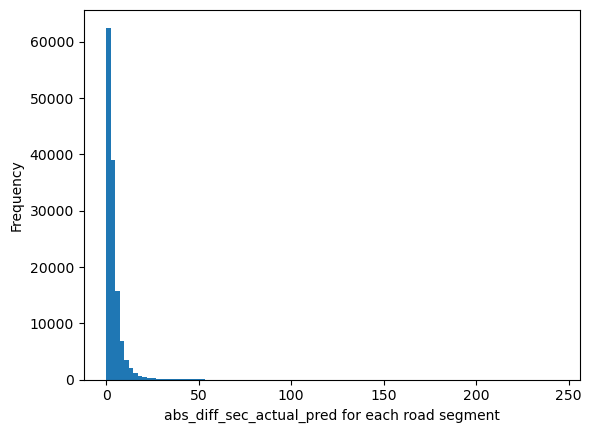

In [119]:
region_data_merge['abs_diff_sec_actual_pred'].plot(kind='hist', bins=100)
plt.xlabel('abs_diff_sec_actual_pred for each road segment')

In [120]:
region_data_merge['abs_diff_sec_actual_pred'].describe().drop('count')

mean      3.859702
std       5.178576
min       0.000009
25%       1.244129
50%       2.631091
75%       4.714385
max     243.688732
Name: abs_diff_sec_actual_pred, dtype: float64

From the results above, we observe that within Region 1, the mean absolute difference between the actual and predicted inferred travel time for each road segment is approximately 4 seconds, with the 75th percentile around 5 seconds. This indicates effective clustering, as the road segments with high similarity in travel time were grouped together, contributing to strong prediction accuracy.

##### 5.4.2.2 Compare the route optimization results by the prediction and the inferred travel time

In [ ]:
#create an OSMnx graph for Chicago city
place = 'Chicago, Illinois, USA'
G = ox.graph_from_place(place, network_type='drive')
# create geo-dataframe for both nodes and edges 
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# add geometry from edges to G for plot in the following
for idx, row in edges.reset_index().iterrows():
    u, v, key = row['u'], row['v'], row['key']
    G[u][v][key]['geometry'] = row['geometry']

In [121]:
#define a function to create a directed graph based on the given merged regional dataset.
def create_subset_graph_with_given_data(G, data):
    # Extract relevant edges (u, v) from the given data
    relevant_edges = [(row['u'], row['v']) for _, row in data.iterrows()]
    relevant_nodes = set([node for edge in relevant_edges for node in edge])

    # Handle multi-edge graph by selecting the shortest edge for each (u, v)
    subset_edges = []
    for u, v in relevant_edges:
        if G.has_edge(u, v):  
            # Find the edge with the minimum 'length'  since this aligns with how we created the shortest route earlier
            min_edge_key = min(G[u][v], key=lambda k: G[u][v][k].get('length', float('inf')))
            subset_edges.append((u, v, min_edge_key))

    # Create the subset graph with the selected edges
    G_c = G.edge_subgraph(subset_edges).copy()

    # Add the inferred_travel_time_sec and yhat attributes to the edges in G_c
    for _, row in data.iterrows():
        u, v = row['u'], row['v']
        edge_keys = list(G_c[u][v].keys())  
        first_key = edge_keys[0]  # Since there is only one key in each edge of G_c, just take the first key
        G_c[u][v][first_key]['inferred_travel_time_sec'] = row['inferred_travel_time_sec']
        G_c[u][v][first_key]['prediction_in_sec'] = row['yhat']
     
    # Ensure all relevant nodes are included
    for node in relevant_nodes:
        if node not in G_c.nodes and node in G:
            G_c.add_node(node, **G.nodes[node])

    return G_c

In [122]:
region_data_merge['datetime'].value_counts()

datetime
2024-03-22 16:00:00    338
2024-03-15 08:00:00    332
2024-03-04 08:00:00    315
2024-02-17 19:00:00    287
2024-02-23 11:00:00    283
                      ... 
2024-04-22 23:00:00      1
2024-04-21 06:00:00      1
2024-03-17 06:00:00      1
2024-04-15 23:00:00      1
2024-03-31 16:00:00      1
Name: count, Length: 1617, dtype: int64

In [123]:
# pick a specific time between '2024-02-17 00:00:00' and  '2024-04-30 23:00:00'
timestamp='2024-03-04 08:00:00'
region_data_merge_specifictime=region_data_merge[region_data_merge['datetime']==timestamp]
# create a subgraph corresponding to the specified timestamp
G_c = create_subset_graph_with_given_data(G, region_data_merge_specifictime)
print(f"Subset graph has {G_c.number_of_nodes()} nodes and {G_c.number_of_edges()} edges.")

Subset graph has 287 nodes and 315 edges.


In [124]:
# Example to inspect an edge's attributes
u, v, key = next(iter(G_c.edges))
print(f"Edge ({u}, {v}) attributes: {G_c[u][v][key]}")

Edge (261253127, 261203104) attributes: {'osmid': [428504739, 428504732, 428504749], 'lanes': '5', 'name': 'North Central Avenue', 'highway': 'secondary', 'oneway': False, 'reversed': False, 'length': 177.034, 'geometry': <LINESTRING (-87.766 41.919, -87.766 41.919, -87.766 41.919, -87.766 41.92, ...>, 'speed_kph': 43.8, 'travel_time': 14.6, 'region': 1, 'inferred_travel_time_sec': 28.843031784841067, 'prediction_in_sec': 20.347261511699426}


In [125]:
# define a function to find pairs of nodes (start_node, end_node) with multiple routes
def find_pairs_with_multiple_routes(G_c, num_pairs=1000):   
    # initialize an empty list to store the pairs
    node_pairs = []
    # get unique list of nodes
    unique_nodes = list(set(G_c.nodes))  
    # iterate through unique pairs of nodes
    for i, start_node in enumerate(unique_nodes):
        for end_node in unique_nodes[i + 1:]:  # check unique pairs (start_node, end_node)
            # Find all simple paths between the nodes:
            ## cutoff=80 means limit to paths of max 80 edges,
            ## 80 was chosen based on the fact that the average trip_duration from the original dataset is 12min, 
            ## 80 cutoff  created pairs of nodes with a similar trip_duration 
            paths = list(nx.all_simple_paths(G_c, source=start_node, target=end_node, cutoff=80)) 
            if len(paths) > 1:  # Check if there are multiple paths
                node_pairs.append((start_node, end_node))    
            # Stop when we have enough pairs
            if len(node_pairs) >= num_pairs:
                return node_pairs    
    # If less than `num_pairs` are found, return what we have
    return node_pairs

In [126]:
node_pairs = find_pairs_with_multiple_routes(G_c)
len(node_pairs)

1000

In [127]:
# define a function to calculate the shortest route between a given pair of nodes in a given graph based on a given weight
def calculate_shortest_route(G_c, start_node, end_node, weight):

    # calculate the shortest path
    path = nx.shortest_path(G_c, source=start_node, target=end_node, weight=weight)
    
    # calculate the total weight of the path
    total_time = nx.shortest_path_length(G_c, source=start_node, target=end_node, weight=weight)
    
    return path, total_time

In [128]:
# path_inferred_ls is used to save the fastest path calculated by the inferred travel time
path_inferred_ls=[]
# path_prediction_ls is used to save the fastest path calculated by the predicted travel time
path_prediction_ls=[]
# time_inferred_ls is used to save the total actual inferred travel time 
time_inferred_ls=[]
#abs_timediff_percent_predtime_inferredtime means the absolute percentage error between 
##the predicted travel time and the actual inferred total travel time. 
abs_timediff_percent_predtime_inferredtime_ls=[]
#abs_timediff_percent__predpath_inferredpath means the absolute percentage difference in travel time between
##the predicted fastest path and the actual fastest path 
abs_timediff_percent_predpath_inferredpath_ls=[]
#abs_timediff_sec_predpath_inferredpath means the absolute travel time difference in sec between
##the predicted fastest path and the actual fastest path. 
abs_timediff_sec_predpath_inferredpath_ls=[]
#abs_timediff_sec_predtime_inferredtime means the absolute difference in sec between
##the predicted travel time and the actual inferred total travel time. 
abs_timediff_sec_predtime_inferredtime_ls=[]
#comp_ls is used to save the boolean results by comparing the predicted fastest path and actual fastest path
comp_ls=[]
# loop through each of the obtained node_pairs to apply the defined function for 
##calculating the fastest route based on the actual inferred travel time and the predicted travel time respectively
for i in range(len(node_pairs)):
   # shortest route based on inferred traffic time
    path_inferred, time_inferred = calculate_shortest_route(G_c, node_pairs[i][0], node_pairs[i][1], weight='inferred_travel_time_sec')
    path_inferred_ls.append(path_inferred)
    time_inferred_ls.append(time_inferred)
   # shortest route based on predicted travel time
    path_prediction, time_prediction = calculate_shortest_route(G_c, node_pairs[i][0], node_pairs[i][1], weight='prediction_in_sec')
    path_prediction_ls.append(path_prediction)
    comp_ls.append(path_inferred==path_prediction)
   # calculate the actual total inferred travel time for the calculated shortest route by predicted travel time
    inferred_travel_time_fromprediction = 0
    for j in range(len(path_prediction) - 1): 
        u = path_prediction[j]  
        v = path_prediction[j + 1]
        edge_keys = list(G_c[u][v].keys())  
        first_key = edge_keys[0]  
        inferred_travel_time_fromprediction += G_c[u][v][first_key]['inferred_travel_time_sec']
    abs_timediff_percent_predpath_inferredpath_ls.append(abs(inferred_travel_time_fromprediction-time_inferred)/time_inferred)
    abs_timediff_percent_predtime_inferredtime_ls.append(abs(time_prediction-inferred_travel_time_fromprediction)/
                                                         inferred_travel_time_fromprediction)
    abs_timediff_sec_predpath_inferredpath_ls.append(abs(inferred_travel_time_fromprediction-time_inferred))
    abs_timediff_sec_predtime_inferredtime_ls.append(abs(time_prediction-inferred_travel_time_fromprediction))

In [129]:
# check the average trip_duration from the generated pairs
np.mean(time_inferred_ls)/60

15.649470050957003

In [130]:
# evaluate the prediction performance by comparing the route optimization results between using actual travel time and using predictions
prediction_perf=pd.DataFrame({'absolute percentage time difference between the predicted path and the actual fastest path': 
                              abs_timediff_percent_predpath_inferredpath_ls, 
                              'absolute percentage error between the predicted travel time and the actual inferred travel time':
                              abs_timediff_percent_predtime_inferredtime_ls,
                              'absolute time difference in sec between the predicted path and the actual fastest path': 
                              abs_timediff_sec_predpath_inferredpath_ls, 
                              'absolute time difference in sec between the predicted travel time and the actual inferred travel time':
                              abs_timediff_sec_predtime_inferredtime_ls})
prediction_perf


absolute percentage time difference between the predicted path and the actual fastest path  \
0                                                  0.0                                            
1                                                  0.0                                            
2                                                  0.0                                            
3                                                  0.0                                            
4                                                  0.0                                            
..                                                 ...                                            
995                                                0.0                                            
996                                                0.0                                            
997                                                0.0                                            
998                                                0.0                                            
999                                                0.0                                            

     absolute percentage error between the predicted travel time and the actual inferred travel time  \
0                                             0.096507                                                 
1                                             0.202146                                                 
2                                             0.211941                                                 
3                                             0.214433                                                 
4                                             0.090371                                                 
..                                                 ...                                                 
995                                           0.029890                                                 
996                                           0.036694                                                 
997                                           0.041633                                                 
998                                           0.057606                                                 
999                                           0.032746                                                 

     absolute time difference in sec between the predicted path and the actual fastest path  \
0                                                  0.0                                        
1                                                  0.0                                        
2                                                  0.0                                        
3                                                  0.0                                        
4                                                  0.0                                        
..                                                 ...                                        
995                                                0.0                                        
996                                                0.0                                        
997                                                0.0                                        
998                                                0.0                                        
999                                                0.0                                        

     absolute time difference in sec between the predicted travel time and the actual inferred travel time  
0                                            17.723298                                                      
1                                            15.978995                                                      
2                                            37.620639                                             

In [131]:
prediction_perf.describe()

absolute percentage time difference between the predicted path and the actual fastest path  \
count                                             1000.0                                            
mean                                                 0.0                                            
std                                                  0.0                                            
min                                                  0.0                                            
25%                                                  0.0                                            
50%                                                  0.0                                            
75%                                                  0.0                                            
max                                                  0.0                                            

       absolute percentage error between the predicted travel time and the actual inferred travel time  \
count                                        1000.000000                                                 
mean                                            0.052892                                                 
std                                             0.040055                                                 
min                                             0.000005                                                 
25%                                             0.024300                                                 
50%                                             0.045127                                                 
75%                                             0.072046                                                 
max                                             0.223471                                                 

       absolute time difference in sec between the predicted path and the actual fastest path  \
count                                             1000.0                                        
mean                                                 0.0                                        
std                                                  0.0                                        
min                                                  0.0                                        
25%                                                  0.0                                        
50%                                                  0.0                                        
75%                                                  0.0                                        
max                                                  0.0                                        

       absolute time difference in sec between the predicted travel time and the actual inferred travel time  
count                                        1000.000000                                                      
mean                                           43.236596                                                      
std                                            26.603030                                                      
min                                             0.004066                                                      
25%                                            21.674841                                                      
50%                                            40.645448                                                      
75%                                            61.022079                                                      
max                                           139.516746

In [132]:
# percentage of the shortest route calculated by prediction matches with that by inferred travel time
len(list(filter(lambda x: True if x is True else False, comp_ls)))/len(comp_ls)

1.0

In [133]:
# Define a function to display the calculated shortest routes on a map with traffic info
def display_shortest_routes_with_traveltime_info(G_c, start_node, end_node):

    # Initialize map centered at the start node
    start_coords = (G_c.nodes[start_node]['y'], G_c.nodes[start_node]['x'])  # (latitude, longitude)
    m = folium.Map(location=start_coords, zoom_start=13)

    # Define weights and their visualization styles
    route_styles = {
        'inferred_travel_time_sec': {'color': '#E65100', 'dash_array': None},  # Solid line
        'prediction_in_sec': {'color': '#E65100', 'dash_array': '5,10'},  # Dashed line
    }

    total_times = {}  # Dictionary to store total travel times for each weight

    for weight, style in route_styles.items():
        # calculate shortest path and its nodes
        path = nx.shortest_path(G_c, source=start_node, target=end_node, weight=weight)
        
        # initialize total travel time
        total_time = 0

        # extract edges and their corresponding traffic information
        for u, v in zip(path[:-1], path[1:]):  # iterate over consecutive nodes in the path
            edge_data = G_c[u][v]  # access edge data
            edge_keys = list(G_c[u][v].keys())
            first_key = edge_keys[0]  # get the first key
            edge_geometry = edge_data[first_key].get("geometry")

            # extract traffic information
            inferred_time = edge_data[first_key].get("inferred_travel_time_sec", 0)
            prediction_time = edge_data[first_key].get("prediction_in_sec", 0)

            # add time to the total for the current weight
            travel_time = edge_data[first_key].get(weight, 0)  
            total_time += travel_time

            # add the edge as a polyline to the map
 
            line_coords = list(edge_geometry.coords)
            line_coords_reversed = [[lat, lon] for lon, lat in line_coords]  # Reverse for folium
            folium.PolyLine(
                locations=line_coords_reversed,
                color=style['color'],
                weight=5,
                dash_array=style['dash_array'],
                tooltip=f"<b>Route by {weight}</b><br>"
                            f"Start: {u}, End: {v}<br>"
                            f"Inferred Time: {inferred_time} sec<br>"
                            f"Predicted Time: {prediction_time} sec<br>"
                ).add_to(m)

        # store the total travel time in minutes
        total_times[weight] = total_time / 60  # convert seconds to minutes

    # add markers for start and end nodes
    folium.Marker(location=start_coords, popup="Start Node", icon=folium.Icon(color="blue")).add_to(m)
    end_coords = (G_c.nodes[end_node]['y'], G_c.nodes[end_node]['x'])

    # add total travel time popup at the End Node
    total_time_popup = "<br>".join(
        [f"<b>Route by {weight}</b>: {total_time:.2f} min" for weight, total_time in total_times.items()]
    )
    folium.Marker(
        location=end_coords,
        popup=f"<b>End Node</b><br>{total_time_popup}",
        icon=folium.Icon(color="blue")
    ).add_to(m)

    # Add title
    title_html = f"""
        <h3 align="center" style="font-size:16px"><b>Region {region} Route Optimization Comparison at 2024-03-04 08:00:00 am<br></h3>
        """
    m.get_root().html.add_child(folium.Element(title_html))

    return m


# Example usage
map_routes = display_shortest_routes_with_traveltime_info(G_c, node_pairs[40][0], node_pairs[40][1])
map_routes.save("shortest_routes_comparison.html")  # Save as an interactive HTML
map_routes
